# Mask or Enhance: Data Curation Aiding the Discovery of Piezoresponse Force Microscopy Contributors

## Load libraries, dataset, and function definitions

In [1]:
## Import libraries for analysis and plotting
import sys
import bepy as be
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from matplotlib.ticker import StrMethodFormatter
from sklearn.preprocessing import MinMaxScaler
import time
from tqdm.notebook import tqdm
from tabulate import tabulate

### Load Data

In [2]:
# Grid size
gridSize = 50

# File path
path= '//Users//kevinligonde//Dropbox (GaTech)//ME-DboxMgmt-Bassiri-Gharb//BE_Active//Kevin//60PMN40PT//03-30-2021//Grid_1//Measurements//'

samp = be.Sample(path, gridSize, adjustphase=False)

## Check data was properly loaded
print("The grid measurements are: ", list(samp._gridmeasurements.keys()))
print("The scan (or line) measurement are: ", list(samp._linemeasurements.keys()))

The grid measurements are:  ['SSPFM']
The scan (or line) measurement are:  ['SN024_4', 'SN024_1', 'SN024_3', 'SN024_2']


### Grid Measurement Setup--Filtering and Cleaning

In [3]:
# Assign appropriate sample name
sampName = 'SSPFM'

In [4]:
############## Function Definitions #########################

## GetDataSubset function extracts dataframes for 
## future plotting and analysis
## meas = measurement/sample name
## inout = 1 for infield and 0 for outfield
## indices = Acquisitions/measurement locations. Can make smaller 
##           dataframe for localized analysis
def make_df(meas,inout,indices=None):
    # List of parameters
    var_list=["Amp","Phase","PR","Res","Q","errQ"] 
    # Dataframe construction
    df=samp._gridmeasurements[meas].GetDataSubset(inout=inout,stack=var_list)
    
    # Reordering of multidimensional dataset
    # As of 6/28/21 this is how data from bepy app is loaded
    df.columns = df.columns.droplevel("InOut")
    df.columns = df.columns.swaplevel(1,2)
     
    # Conversions
    df["Res"]=df["Res"]/1000 # Hz -> kHz
    df["Phase"]=df["Phase"]*180/np.pi # radians -> degrees
    
    if indices == None: 
         df = df
    else:
        df=df.iloc[indices[0]:indices[1],:]
    return df

## Remove Q: Remove chirps with poor SHO fits 
## Reasoning: Q values that are nonsensical (negative or extremely large) are
## discarded to minimize error
def remove_q(df):
    # Map chirps from the dataframe with Q values larger than 500 or less than 0
    # and set them to Not-a-Number
    test = df['Q'].applymap(lambda x: np.nan if x < 0 or x >= 500 else x)
    
    # Make a copy of the input dataframe so the original dataframe stays intact 
    df_nan=df.copy()
    
    # Adding NaN where poor fits were found
    for var in ['Amp','Phase','PR','Res','Q']:
        df_var=df[var].copy()                 # Create a copy of the variable/parameter 
        df_var[test.isnull()]=np.nan          # Use test df as a mask and assign variable NaN in same locations
        df_nan[var]=df_var                    # Replace master DataFrame values with masked values (includes NaN)
    
    # Calculating mean and std for additional outliers
    mean = df_nan['Q'].mean(skipna=True).mean(skipna=True)
    std = df_nan['Q'].std(skipna=True).mean(skipna=True)
    
    upper = mean + (3*std)
    lower = mean - (3*std)

    # Map and remove points in DataFrame with Q values outside the bounds
    test = df_nan['Q'].applymap(lambda x: np.nan if x < lower or x > upper else x)

    for var in ['Amp','Phase','PR','Res','Q']:
        df_var=df_nan[var].copy()                       # Create a copy of the variable/parameter 
        df_var[test.isnull()]=np.nan                # Use test df as a mask and assign variable NaN in same locations
        df_nan[var]=df_var                         # Replace master DataFrame value with masked value (includes NaN)

    return df_nan

## Linear fill: A linear interpolation is done to replace the Chirps with poor SHO fitting 
## (they should be currently set to NaN)
def linear_fill(df):
    
    # Make a copy of the input df so original stays intact  
    df_fill=df.copy()
    
    for var in ['Amp','Phase','PR','Res','Q']:
        df_fill[var]=df_fill[var].interpolate(method='linear',limit=2 ,limit_direction='forward',limit_area='inside', axis=1)
        df_fill[var]=df_fill[var].fillna(method='backfill',axis=1)     # Axis = columns to back fill from the next DC bias in the waveform at the same point
        df_fill[var]=df_fill[var].fillna(method='ffill',axis=1)        # Forward fill to get the last chirps
        
    return df_fill

def reorder_rows(df, order):
    #Reorder rows of dataframe according to order passed and reset indices

    # Returns:
    #   Reordered dataframe
    
    df = df.reindex(order)
    df = df.reset_index(drop=True)
    return df

def invert_every_n_rows_order(n, last_index):
    #Skips n rows, inverts next n and repeats to last_index. Returns new list.

     #  Args:
     #   n (int): Number of indices to jump, then invert.
     #  last_index (int): last (non-inclusive) index.

     #  Returns:
     #    Reordered list.

    return_list = []
    increment_of_n = 0
    for i in range(last_index):
        if i % n == 0 and i != 0:
            increment_of_n += 1
        if increment_of_n % 2 == 0:
            return_list.append(i)
        else:
            if n * (increment_of_n + 1) < last_index:
              # n*(increment_of_n + 1) - 1 is the index where we switch back to 
              # normal indexing
              # i - increment_of_n*n is a value between 0 and n
              # n*increment_of_n - 1 - (i - increment_of_n*n) 
              # = 2*n*(increment_of_n + 1) + n - i - 1, which decrements 
              # rows from n+n->n
                val = 2 * n * increment_of_n + n - i - 1
                return_list.append(val)
            else:
                # handles when last_index % n != 0
                val = (last_index-1) + n*increment_of_n - i
                return_list.append(val)
        
    return return_list


### Make dataframe and perform outlier removal via Q and Phase detection

In [26]:
############### Generating dataframes for infield and outfield response
infield  = make_df(sampName,1)
outfield = make_df(sampName,0)

# As of 6/28/21, after the data is imported an inversion operation
# is done every other row of each dataframe
# During scanning, the instrument scans in serpentine shape.
# By inverting every other row, the locations are reorganized
# so that "scanning" along each row is consistent (i.e. left to right rather than serpentine)
new_order = invert_every_n_rows_order(gridSize, len(infield))

# Perform reordering operation for the infield and outfield response
new_infield = reorder_rows(infield.copy(), new_order)
new_outfield = reorder_rows(outfield.copy(), new_order)

# Replace data points with nonsensical Q values (Q<0 or Q>500) and replace with NaN
in_nan=remove_q(new_infield)
out_nan=remove_q(new_outfield)

# Perform linear fill operation to replace NaN cells
out_fill = linear_fill(out_nan)
in_fill = linear_fill(in_nan)

In [6]:
# Adjusting the phase
from scipy import stats
from scipy.stats import norm
from scipy.optimize import fsolve
    
# Second round with phase filtering
def adjustPhase(df, top = False, bottom = True):
    # Length of measurement cycle
    cycle_len = 150

    # Grab Phase response and make a copy
    df_phase = df['Phase'].copy() # Should be in degrees

    # Step 1 - phase correction is done at all locations
    for pnt in range(len(df_phase)):

        # Grab the phase response at that point
        loc_response = df_phase.iloc[pnt]

        # Phase adjustment - there are 3 cycles of measurement
        for i in range(3):
            resp = loc_response.loc[i].values

            for k in range(len(resp)):
                if resp[k] > 180:
                    resp[k]-=360
                elif resp[k] < -180:
                    resp[k]+=360
            # After correcting phase, replace        
            loc_response.loc[i]=resp

        # Grab average phase at that location
        loc_avg = np.mean(loc_response)

        # Grab responses from lower and higher end of phase distribution
        lower_end=loc_response.values[np.where(loc_response<loc_avg)[0]]
        higher_end=loc_response.values[np.where(loc_response>loc_avg)[0]]

        # Grab the quantiles from lower and higher end
        q_min=np.quantile(lower_end,0.02)
        q_max=np.quantile(higher_end,0.98)

        # Flag points that are outliers 
        if bottom == True:
            loc_response=loc_response.apply(lambda x: np.nan if (x < q_min) else x)
        if bottom == True:
            loc_response=loc_response.apply(lambda x: np.nan if (x > q_max) else x)

        df_phase.iloc[pnt]=loc_response

    # Reassign to main df
    df['Phase'] = df_phase

    # Make mask or locations with NaN
    mask = df_phase.isnull()

    #Adding NaN where poor fits were found
    for var in ['Amp','Phase','PR','Res','Q']:
        df_var=df[var].copy()                 # Create a copy of the variable/parameter 
        df_var[mask]=np.nan          # Use test df as a mask and assign variable NaN in same locations
        df[var]=df_var                    # Replace master DataFrame values with masked values (includes NaN)

    # Then perform linear fill and return df
    df_new = linear_fill(df)

    return df_new

# Calculate Phase Offset
def PhaseOffsetCorrection(df, field=0):
    # Response parameters - assuming 3 cycles of measurement
    num_cycles = 3

    temp = df['Phase'].replace([np.inf, -np.inf], np.nan)

    # The assumption is that the data is in degrees and will be converted to radians
    temp_deg=temp.copy()
    temp = temp*np.pi/180 # Conversion from deg to rad

    # For each point in the Phase dataframe we will calculate the optimal phase offset
    theta_opt=np.zeros((len(temp),1))
    
    for i in np.arange(len(temp)):
       # 1. Build a histogram of phase data
        ydata=temp.iloc[i].values # Full response at that location

        bw = np.pi/180 # bin width for histogram (1 deg in radian)
        n, bins = np.histogram(ydata, bins=int(2*np.pi/bw))

        ph_1_idx = np.argmax(n[1:int(len(n)/2)])
        ph_2_idx = int(len(n)/2)+np.argmax(n[int(len(n)/2):-1])
        
        mids = 0.5*(bins[1:] + bins[:-1])
        interval = 22

        if interval > ph_1_idx:
            interval_min = ph_1_idx
        else:
            interval_min= interval
            
        if interval+ph_2_idx >= 360:
            interval_max = 360-ph_2_idx
        else:
            interval_max = interval

        mu_1 = np.average(mids[ph_1_idx-interval_min:ph_1_idx+interval], weights=n[ph_1_idx-interval_min:ph_1_idx+interval])
        mu_2 = np.average(mids[ph_2_idx-interval:ph_2_idx+interval_max], weights=n[ph_2_idx-interval:ph_2_idx+interval_max])

        # 2. Compute mean phase at each polarity
        if field==0:
            theta_in = mu_2
            theta_out = mu_1
        if field==1:
            theta_in = mu_1
            theta_out = mu_2

        # 3. Determine the optimal angle
        if field==0:
            def equations(p):
                # The only argument being passed is the optimal angle
                theta_opt=p 
                return (np.cos(theta_in+theta_opt)+np.cos(theta_out+theta_opt))

            theta_guess = -theta_in    

        if field==1:
            def equations(p):
                # The only argument being passed is the optimal angle
                theta_opt=p 
                return (np.cos(theta_in+theta_opt)+np.cos(theta_out+theta_opt))

            theta_guess = -theta_out

        theta_optimal =  fsolve(equations, theta_guess)

        theta_opt[i] = theta_optimal*180/np.pi # Conversion to deg
        
    Phase_offset = np.mean(theta_opt)

    df_new=df.copy()
    df_new['Phase']=df_new['Phase'].add(np.mean(theta_opt))
    
    return df_new, Phase_offset

* Check if slope is positive or negative
* If s is negative:
    np.cos(theta_in+theta_opt)-1
        return theta_opt
    
* if s is positive: 
    np.cos(theta_in+np.pi+theta_opt)-1
        return np.pi+theta_opt

* Check order of operations for phase transformation:
    * Perform inversion, then subtract necessary phase until cos condition is met
    * Subtract positive peak to zero, then compute the inversion by theta=-theta
    

In [27]:
# Adjust loop orientation to due phase wrapping
out_fill = adjustPhase(out_fill, top = True, bottom = True)
in_fill = adjustPhase(in_fill, top = True, bottom = True)

# Phase correction due to electrostatics
#out_fill = PhaseOffsetCorrection(out_fill,field = 0)
in_fill, Ph_offset = PhaseOffsetCorrection(in_fill,field = 1)
#out_fill, Ph_offset = PhaseOffsetCorrection(out_fill,field = 0)
# The same phase offset from On-Field response should be added to Off-F
# Ref: Quantification of the Electromechanical Measurements  by Piezoresponse Force Microscopy
out_fill['Phase']=out_fill['Phase'].add(Ph_offset)

In [28]:
# For this particualar dataset, we observe the out_fill array has size 451
# The last response is from an additional chirp that was added to the waveform
# and is a repeat of the preceding chirp so we can remove it
out_fill.drop(columns=1051,inplace=True, axis=1,level=2)
in_fill.drop(columns=1051,inplace=True, axis=1,level=2)

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.hist(out_fill['Phase'].loc[1687].values,bins=100);

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
pnt=5
# Grab the phase response at that point
loc_response = out_fill['Phase'].iloc[pnt]
# Extract the voltage response and chirpnumbers
xdata = loc_response.index.get_level_values(level=2).astype(float)[0:150]

# Original
i=0
#ax.plot(xdata, loc_response[i].values[::-1])
ax.plot(xdata, loc_response[i].values)
# With reversal
#ax.plot(xdata, loc_response[i].values[::-1])

### Plotting Functions and Phase Adjust

In [102]:
######### Plotting Functions - Part 1 ######################

# Dictionary of units for each variable/parameter
#units={"Amp":'(a.u.)',"PR":'(a.u.)',"Phase":'($\circ$)',"Res":'(kHz)',"Q":''}
units={"Amp":'($\mu$V)',"PR":'($\mu$V)',"Phase":'($\circ$)',"Res":'(kHz)',"Q":''}

# Generate evenly spaced ticks 
def gen_ticks(vmin,vmax,var):
    ticks=[] # Create empty list
    
    if var == 'Res':
        vmin=round(vmin,1)
        vmax=round(vmax,1)
    else:
        vmin=round(vmin,1)
        vmax=round(vmax,1)
        
    ticks.append(vmin)    
    ticks.append(vmax)
        
    return ticks  

# Average response of DataFrame across all locations. Must specify whether input or output
def ave_plot_gs(df,var):
    
    # Here we assume 3 cycles of data were collected at each location
    # and we compute the mean values
    ydata = df[var][0].mean() 
    xdata = df[var][0].columns.get_level_values('xaxis').astype(float)
    ydata1 = df[var][1].mean() 
    xdata1 = df[var][1].columns.get_level_values('xaxis').astype(float)
    ydata2 = df[var][2].mean() 
    xdata2 = df[var][2].columns.get_level_values('xaxis').astype(float)      
    
    # Create an empty list that will find the min/max 
    # value of each parameter, essentially setting the bounds
    # of the y-axis plots
    lims_list=[]

    for i in [ydata,ydata1,ydata2]: #,ydata1,ydata2]:
        lims_list.append(i.max())
        lims_list.append(i.min())

    ymin=min(lims_list)
    ymax=max(lims_list)
        
# Plotting the variable response
    plt.plot(xdata,ydata,label="Cycle 1",linewidth=2.0,color="darkorange")
    plt.plot(xdata,ydata1,label="Cycle 2",linewidth=2.0,color='yellowgreen')
    plt.plot(xdata2,ydata2,label="Cycle 3",linewidth=2.0,color='dodgerblue')
    
# Set the y and x axis limits
    ax = plt.gca()
    yrange = np.abs(ymin-ymax)
    incr_range = yrange*0.08    
    #ax.set_ylim([ymin-incr_range,ymax+incr_range]) # set y-axis limits
    ax.set_xlim([-13.5,13.5])                          # Here we assume voltage range during measurement - adjust as needed
    ax.set_xticks([-12,-6,0,6,12])                 # Adjust ticks as needed as well
    
# Set the y-ticks and labels at regular intervals 
    ax.yaxis.tick_right()
    ticks=gen_ticks(ymin,ymax,var)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)
    if var=="Res": # We format the value of Resonance parameter so it's only within 1 decimal point [KHz range]
        ax.yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    else:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%0.0f'))

# Response at individual location. Must specify whether input or output
def pnt_plot_gs(df,pnt,var):
    
    # Here we assume 3 cycles of data were collected
    # and we compute the mean values of each cycle
    ydata = df[var][0].iloc[pnt:pnt+1,:].values[0] 
    xdata = df[var][0].columns.get_level_values('xaxis').astype(float)
    ydata1 = df[var][1].iloc[pnt:pnt+1,:].values[0]
    xdata1 = df[var][1].columns.get_level_values('xaxis').astype(float)
    ydata2 = df[var][2].iloc[pnt:pnt+1,:].values[0]
    xdata2 = df[var][2].columns.get_level_values('xaxis').astype(float) 
    
    # Create an empty list that will find the min/max 
    # value of each parameter, essentially setting the bounds
    # of the y-axis plots
    lims_list=[]

    for i in [ydata,ydata1,ydata2]: #,ydata1,ydata2]:
        lims_list.append(i.max())
        lims_list.append(i.min())


    ymin=min(lims_list)
    ymax=max(lims_list)

    markersize = 8
# Plotting the variable response
    plt.plot(xdata,ydata,label="Cycle 1",linewidth=1.0,color='darkorange',marker='.',markersize=markersize)
    plt.plot(xdata1,ydata1,label="Cycle 2",linewidth=1.0,color='yellowgreen',marker='.',markersize=markersize)
    plt.plot(xdata2,ydata2,label="Cycle 3",linewidth=1.0,color='dodgerblue',marker='.',markersize=markersize)
    
# Set the y and x axis limits
    ax = plt.gca()
    yrange = np.abs(ymin-ymax)
    incr_range = yrange*0.08    
    ax.set_ylim([ymin-incr_range,ymax+incr_range]) # set y-axis limits
    ax.set_xlim([-13.5,13.5])                          # Here we assume voltage range during measurement - adjust as needed
    ax.set_xticks([-12,-6,0,6,12])                 # Adjust ticks as needed as well
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
# Plotting x and y axes labels
    plt.xlabel('Bias (V)',fontsize=14)
    
    
# Scatter Function showing all data including filled values
def plot_parameters(df,comp,c,param):   
    if param == "P1":
        y1=df['P1_c1'].iloc[comp:comp+1].values[0] # cycle 1
        y2=df['P1_c2'].iloc[comp:comp+1].values[0] # cycle 2
        y3=df['P1_c3'].iloc[comp:comp+1].values[0] # cycle 2
        
        x=df['P1_c1'].iloc[comp:comp+1].columns.get_level_values('xaxis').astype(float)
        x3=df['P1_c3'].iloc[comp:comp+1].columns.get_level_values('xaxis').astype(float)
        
        
    elif param == "P2": 
        y1=df['P2_c1'].iloc[comp:comp+1].values[0] # cycle 1
        y2=df['P2_c2'].iloc[comp:comp+1].values[0] # cycle 2
        y3=df['P2_c3'].iloc[comp:comp+1].values[0] # cycle 3
        
        x=df['P2_c1'].iloc[comp:comp+1].columns.get_level_values('xaxis').astype(float)
        x3=df['P2_c3'].iloc[comp:comp+1].columns.get_level_values('xaxis').astype(float)
        
    elif param == "P3":   
        y1=df['P3_c1'].iloc[comp:comp+1].values[0] #cycle 1
        y2=df['P3_c2'].iloc[comp:comp+1].values[0] #cycle 2
        y3=df['P3_c3'].iloc[comp:comp+1].values[0] #cycle 3
        
        x=df['P3_c1'].iloc[comp:comp+1].columns.get_level_values('xaxis').astype(float)
        x3=df['P3_c3'].iloc[comp:comp+1].columns.get_level_values('xaxis').astype(float)
    
    elif param == "P4":   
        y1=df['P4_c1'].iloc[comp:comp+1].values[0] #cycle 1
        y2=df['P4_c2'].iloc[comp:comp+1].values[0] #cycle 2
        y3=df['P4_c3'].iloc[comp:comp+1].values[0] #cycle 3
        
        x=df['P4_c1'].iloc[comp:comp+1].columns.get_level_values('xaxis').astype(float)
        x3=df['P4_c3'].iloc[comp:comp+1].columns.get_level_values('xaxis').astype(float)

        # For Figure 1 and 6
   # plt.plot(x,y1,color=c,linestyle='dotted', linewidth=1.2, markersize=1.0,label='cycle 1')
   # plt.plot(x,y2,color=c,linestyle='dashed', linewidth=1.05, markersize=1.0,label='cycle 2')
   # plt.plot(x3,y3,color=c,linestyle='solid', linewidth=0.95, markersize=1.0,label='cycle 3')

        # For Figure 7
    plt.plot(x,y1,color=c,linestyle='dotted', linewidth=0.8, markersize=1.0,label='cycle 1')
    plt.plot(x,y2,color=c,linestyle='dashed', linewidth=0.8, markersize=1.0,label='cycle 2')
    plt.plot(x3,y3,color=c,linestyle='solid', linewidth=0.8, markersize=1.0,label='cycle 3')

        # For other figures
#     plt.plot(x,y1,color=c,linestyle='dotted', linewidth=1.0, markersize=1.0,label='cycle 1')
#     plt.plot(x,y2,color=c,linestyle='dashed', linewidth=1.0, markersize=1.0,label='cycle 2')
#     plt.plot(x3,y3,color=c,linestyle='solid', linewidth=1.0, markersize=1.0,label='cycle 3')
      
    
    list1=[]
    for i in range(n):
        data=np.concatenate((y1,y2,y3),axis=0)
        #data=y1
        list1.append(data.max())
        list1.append(data.min())

    fig = plt.gcf()
    ax = plt.gca()
    ymin=min(list1)
    ymax=max(list1)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_xlim([-12.65,12.65])
    ax.set_xticks([-10, 0, 10])
    return ymin,ymax

In [30]:
# Run this for colors later on
from scipy.spatial import KDTree
from webcolors import (
    css3_hex_to_names,
    hex_to_rgb,
)
def convert_rgb_to_names(rgb_tuple):
    
    # a dictionary of all the hex and their respective names in css3
    css3_db = css3_hex_to_names
    names = []
    rgb_values = []
    for color_hex, color_name in css3_db.items():
        names.append(color_name)
        rgb_values.append(hex_to_rgb(color_hex))
    
    kdt_db = KDTree(rgb_values)
    distance, index = kdt_db.query(rgb_tuple)
    return names[index]


### PR Calculation with Corrected Phase (run once)

In [31]:
# Off-Field 
out_fill['PR'] = out_fill.apply(lambda row: row['Amp'] * np.cos(row['Phase']*np.pi/180), axis=1)

In [32]:
# On-Field 
in_fill['PR'] = in_fill.apply(lambda row: row['Amp'] * np.cos(row['Phase']*np.pi/180), axis=1)

## Scaling Functions

In [33]:
# Scaling Functions
# Updated local normalization considering outliers
def normalize_local_modified(df,start_pnt,gridSize):
    startTime = time.time()
    df=df.copy()
    
    q=[0.02,0.98] # Quantiles for min/max
    for var in ['PR','Res','Q']: 
        df_var=df[var].copy()
        for i in np.arange(start_pnt,gridSize**2):
            x = df_var.iloc[i].values
            x_scaled = mod_MinMax(x,q)
            df_var.iloc[i]=x_scaled
        df[var]=df_var          
    
    # Amplitude
    df_var=df['Amp'].copy()
    for i in np.arange(start_pnt,gridSize**2):
        x_max=np.quantile(df_var.iloc[i].values,0.98)
        x_scaled = df_var.iloc[i].values/x_max
        df_var.iloc[i]=x_scaled
    df['Amp']=df_var    
    
    
    df_var=df['Phase'].copy()
    for i in np.arange(start_pnt,gridSize**2):
        ph_data = df_var.iloc[i].values
        n, bins = np.histogram(ph_data, bins=360)
        ph_1_idx = np.argmax(n[:int(len(n)/2)])
        ph_2_idx = int(len(n)/2)+np.argmax(n[int(len(n)/2):])
        ph_min = bins[ph_1_idx]
        ph_max = bins[ph_2_idx]
        ph_norm = ((ph_data-ph_min)/(ph_max-ph_min))
        df_var.iloc[i]=ph_norm
    
    df['Phase']=df_var
    
    executionTime = (time.time() - startTime)
    
    print('Execution time in seconds: ' + str(executionTime))
    return df

# Function to normalize from 0 to 1, using q-th quantile
def mod_MinMax(X,q):
    X_min,X_max=np.quantile(X,q)
    X_std = (X-X_min)/(X_max-X_min)
    return X_std

def normalize_global_modified(df,start_pnt,gridSize):
    df=df.copy()
    
    startTime = time.time()
    
    var='Amp'
    df_var=df[var].copy()
    Max=np.quantile(df[var].max(axis=1),0.98)
    
    for i in np.arange(start_pnt,gridSize**2):
        x= df_var.loc[i].values/Max
        df_var.loc[i]=x
        
    df['Amp']=df_var
        
    # Then, perform PR calculation
    df_var=df['PR'].copy()
         
    for i in np.arange(start_pnt,gridSize**2):
        df_var.loc[i]=df['Amp'].loc[i].values*np.cos(df['Phase'].loc[i].values*np.pi/180)/2
        
    Min = df_var.min().min()
    df_var=df_var.add(np.abs(Min))
    
    df['PR']=df_var
    
    # Phase Scaling
    df_var=df['Phase'].copy()
    ph_data = df_var.values.flatten()
    n, bins = np.histogram(ph_data, bins=720)
    ph_1_idx = np.argmax(n[:int(len(n)/2)])
    ph_2_idx = int(len(n)/2)+np.argmax(n[int(len(n)/2):])
    ph_min = bins[ph_1_idx]
    ph_max = bins[ph_2_idx]
    ph_norm = ((ph_data-ph_min)/(ph_max-ph_min)).reshape(gridSize**2,450) 

    for i in np.arange(0,gridSize**2):
        df_var.iloc[i]=ph_norm[i,:]
        
    df['Phase']=df_var
    
    q=[0.02,0.98]
    for var in ['Q', 'Res']:
        df_var=df[var].copy()
        resp = df_var.values.reshape(-1,1)
        resp_scaled = mod_MinMax(resp,q).reshape(gridSize**2,450)
        for i in np.arange(start_pnt,gridSize**2):
            df_var.loc[i]=resp_scaled[i,:]
        df[var]=df_var
        
    executionTime = (time.time() - startTime)
    
    print('Execution time in seconds: ' + str(executionTime))    
    return df

# Global Normalization Strict (so no quantiles)
def normalize_global_strict(df,start_pnt,gridSize):
    df=df.copy()
    df_scaler = MinMaxScaler()
    startTime = time.time()
    
    for var in ['Amp','PR', 'Phase', 'Q', 'Res']:
        df_var=df[var].copy()
        resp = df_var.values.reshape(-1,1)
        df_scaler.fit(resp)
        resp_scaled = df_scaler.transform(resp).reshape(gridSize**2,450)
        for i in np.arange(start_pnt,gridSize**2):
            df_var.loc[i]=resp_scaled[i,:]
        df[var]=df_var
        
    executionTime = (time.time() - startTime)
    
    print('Execution time in seconds: ' + str(executionTime))
    
    return df

# Global z-standardization
def z_standard_global(df):
    df = df.copy()
    startTime = time.time()
    for var in ['Amp', 'PR', 'Phase', 'Q', 'Res']:
        ######z-standardization
        mean_val = df[var].values.flatten().mean()             
        std_val = df[var].values.flatten().std()
        df[var]=df[var].sub(mean_val)/std_val   
    executionTime = (time.time() - startTime)
    print('Execution time in seconds: ' + str(executionTime))
    return df

# Local z-standardization
def z_standard_local(df):
    df = df.copy()
    startTime = time.time()
    for var in ['Amp', 'PR', 'Phase', 'Q', 'Res']:
        df_var = df[var].copy()
        for i in np.arange(0,gridSize**2):
            mean_val = df_var.iloc[i,:].mean()            
            std_val = df_var.iloc[i,:].std()
            resp = df_var.iloc[i,:].values
            scaled = (resp-mean_val)/std_val
            df_var.iloc[i]=scaled   
        df[var]=df_var
    executionTime = (time.time() - startTime)
    print('Execution time in seconds: ' + str(executionTime))
    return df

In [34]:
################## Data Processing for ML #########################
# Considering the parameters have values that are varying orders of magnitude,
# for instance Amplitude in microvolts or resonance in kHz, we need to 
# make sure they're on a similar scale for the machine learning algorithms
# to identify the various behaviors. So far we've looked at normalization and 
# z-standardization

# Global z-standardization
out_z_global=z_standard_global(out_fill)

# Local z-standardization
out_z_local=z_standard_local(out_fill)

# Local Normalization - Modified to minimize outliers - note phase is still globally normalized in this function
out_norm_local=normalize_local_modified(out_fill,0,gridSize)

# Global Normalization
out_norm_global=normalize_global_strict(out_fill,0,gridSize)

# Modified Normalization
out_norm=normalize_global_modified(out_fill,0,gridSize)

Execution time in seconds: 0.07387280464172363
Execution time in seconds: 4.16632604598999
Execution time in seconds: 2.076443910598755
Execution time in seconds: 0.4210479259490967
Execution time in seconds: 5.023097038269043


In [35]:
# If interested in inspecting the mean and standard deviation for each scaled dataset 
#for df in [in_norm,out_norm,in_norm_new,out_norm_new,in_z,out_z]:
for df in [out_z_global, out_z_local, out_norm_local, out_norm_global, out_norm]:
    for var in['Amp', 'PR', 'Phase', 'Q', 'Res']:
        print(var+'  Mean: ',round(df[var].mean(axis=1).mean(axis=0),10))
        print(var+'  STD: ',round(df[var].std(axis=1).mean(axis=0),5))
 

Amp  Mean:  0.0
Amp  STD:  0.9472
PR  Mean:  -0.0
PR  STD:  0.97327
Phase  Mean:  0.0
Phase  STD:  0.99663
Q  Mean:  0.0
Q  STD:  0.88158
Res  Mean:  -0.0
Res  STD:  0.68303
Amp  Mean:  -0.0
Amp  STD:  1.0
PR  Mean:  0.0
PR  STD:  1.0
Phase  Mean:  0.0
Phase  STD:  1.0
Q  Mean:  0.0
Q  STD:  1.0
Res  Mean:  0.0
Res  STD:  1.0
Amp  Mean:  0.5952530862
Amp  STD:  0.28012
PR  Mean:  0.5005828877
PR  STD:  0.36458
Phase  Mean:  0.4917228622
Phase  STD:  0.48367
Q  Mean:  0.5347200132
Q  STD:  0.24729
Res  Mean:  0.6811484165
Res  STD:  0.35196
Amp  Mean:  0.3793380893
Amp  STD:  0.18051
PR  Mean:  0.4596148292
PR  STD:  0.20265
Phase  Mean:  0.425856351
Phase  STD:  0.25956
Q  Mean:  0.493821337
Q  STD:  0.13267
Res  Mean:  0.8698049507
Res  STD:  0.02967
Amp  Mean:  0.4192288676
Amp  STD:  0.1995
PR  Mean:  0.5062549739
PR  STD:  0.22321
Phase  Mean:  0.4899653042
Phase  STD:  0.48291
Q  Mean:  0.5323692893
Q  STD:  0.21483
Res  Mean:  0.6282392372
Res  STD:  0.19197


### Characterizing Differential Loops

In [36]:

def PR_diff_loop_stats_linearFit(df): 
    num_rows = np.shape(df)[0]
    x=df.columns.get_level_values('xaxis').astype(float)
    y=np.zeros((num_rows,len(x)))
    y_max= np.zeros(num_rows)
    y_min= np.zeros(num_rows)
    line_eval=np.zeros((num_rows,len(x)))
    line_diff=np.zeros((num_rows,len(x)))
    y_mean = np.zeros(num_rows) # Mean response
    rss = np.zeros(num_rows) # Residual Sum Squares (least-squares fit)
    tss = np.zeros(num_rows) # Total Sum Squares
    R_squared = np.zeros(num_rows) # Total Sum Squares
    slope = np.zeros(num_rows) # Slope of each line
    y_intercept = np.zeros(num_rows) # y-intercept of each line

    for i in np.arange(0,num_rows):
        y[i,:]=df.iloc[i].values
        y_mean[i] = np.mean(y[i,:])
        y_max[i]= np.max(y[i,:])
        y_min[i]= np.min(y[i,:])
        for j in np.arange(len(y[i,:])):
            tss[i]+=(y[i,j]-y_mean[i])**2 
        linfit = np.polyfit(x, y[i,:], deg=1,full=True) # Linear fit
        slope[i]=linfit[0][0]
        y_intercept[i]=linfit[0][1]
        rss[i]=linfit[1][0]
        R_squared[i]=1-rss[i]/tss[i]
        line_eval[i,:] = np.polyval([slope[i], y_intercept[i]], x)
        line_diff[i,:]=y[i,:]-line_eval[i,:]
        
    return y_max,y_min,slope,R_squared,x,line_diff

def PR_diff_loop_stats_cubicFit(df): 
    num_rows = np.shape(df)[0]
    x=df.columns.get_level_values('xaxis').astype(float)
    y=np.zeros((num_rows,len(x)))
    y_max= np.zeros(num_rows)
    y_min= np.zeros(num_rows)
    line_eval=np.zeros((num_rows,len(x)))
    line_diff=np.zeros((num_rows,len(x)))
    y_mean = np.zeros(num_rows) # Mean response
    rss = np.zeros(num_rows) # Residual Sum Squares (least-squares fit)
    tss = np.zeros(num_rows) # Total Sum Squares
    R_squared = np.zeros(num_rows) # Total Sum Squares
    slope = np.zeros(num_rows) # Slope of each line
    y_intercept = np.zeros(num_rows) # y-intercept of each line

    for i in np.arange(0,num_rows):
        y[i,:]=df.iloc[i].values
        y_mean[i] = np.mean(y[i,:])
        y_max[i]= np.max(y[i,:])
        y_min[i]= np.min(y[i,:])
        for j in np.arange(len(y[i,:])):
            tss[i]+=(y[i,j]-y_mean[i])**2 
        cubefit = np.polyfit(x, y[i,:], deg=3,full=True) # Cubic fit
        slope[i]=cubefit[0][2]
        y_intercept[i]=cubefit[0][3]
        rss[i]=cubefit[1][0]
        R_squared[i]=1-rss[i]/tss[i]
        line_eval[i,:] = np.polyval([slope[i], y_intercept[i]], x)
        line_diff[i,:]=y[i,:]-line_eval[i,:]
        
    return y_max,y_min,slope,R_squared,x,line_diff

In [17]:
# This function will assume you're passing it clustered data unless you pull things beforehand
df = kmeans_comps


max_PR,min_PR,PR_slope,PR_R_squared,x,PR_line_diff=PR_diff_loop_stats_linearFit(df)



NameError: name 'kmeans_comps' is not defined

In [ ]:

#col_names=["N","Max (\u03BCV)","Min(\u03BCV)","Slope(\u03BCV/V)","R\u00b2"]
col_names=["N","Max","Min","Slope","R\u00b2"]
data=np.zeros((np.shape(df)[0],len(col_names)))

for i in np.arange(np.shape(df)[0]):
    data[i,0]= i+1
    data[i,1]= max_PR[reorder[i]]
    data[i,2]= min_PR[reorder[i]]
    data[i,3]= PR_slope[reorder[i]]
    data[i,4]= PR_R_squared[reorder[i]]
    
print(tabulate(data, headers=col_names,tablefmt="fancy_grid"))

In [ ]:
fig=plt.figure(figsize=(12,2.5))

## Second row is for K-Means results on off-F PR
gs= gridspec.GridSpec(1, n,hspace=0.15,wspace=0.15,top=0.95, bottom=0.1, left=0.05, right=0.80)

# fontsize
fontsize = 14

# Remaining figures - plots of components
for i in np.arange(0,n):
    color=c[reorder[i]]
    ax= fig.add_subplot(gs[0,i])
    
    ax.plot(x,PR_line_diff[reorder[i],:]/1e3,color=color)
    ax.annotate(r'$N_{'+str(i+1)+'}$',(0.50,1.05),xycoords='axes fraction',fontsize=fontsize,color=color)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    ax.set_ylabel('Differential from linear fit',fontsize=fontsize)
    ax.set_xlim([-14.5, 14.5])
    #ax.set_ylim([-1.3, 1.3])
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    if i !=n-1:
        ax.set_yticklabels([])
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel(' ')

In [ ]:
# Evolution of response for one component
fig=plt.figure(figsize=(5,5))

# fontsize
fontsize = 14

# Component of interest
comp = 4
line_diff_c1= PR_line_diff[reorder[comp],0:150]/1e3
line_diff_c2= PR_line_diff[reorder[comp],150:300]/1e3
line_diff_c3= PR_line_diff[reorder[comp],300:450]/1e3
x_c1 = x[0:150]
x_c2 = x[150:300]
x_c3 = x[300:450]

# Colors
c1='cyan'
c2='dodgerblue'
c3='blue'

# c1='khaki'
# c2='darkkhaki'
# c3='olive'

# Plotting
ax= fig.add_subplot()

ax.plot(x_c1,line_diff_c1,'*-',color=c1,label="cycle 1")
ax.plot(x_c2,line_diff_c2,'o-',color=c2,label="cycle 2")
ax.plot(x_c1,line_diff_c3,'s-',color=c3,label="cycle 3")
ax.annotate(r'$N_{'+str(comp+1)+'}$',(0.50,0.90),xycoords='axes fraction',fontsize=fontsize,color='black')
ax.yaxis.set_label_position("right")
ax.yaxis.set_ticks_position("right")
ax.set_ylabel('Differential from linear fit (mV)',fontsize=fontsize)
ax.set_xlim([-14.5, 14.5])
ax.set_ylim([-1.0, 1.0])
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(loc='lower center')
plt.show()

#### Figure 0.1 - Normalizing On and Off-F PR

In [ ]:
# Function Definitions
# Function to normalize from 0 to 1, using q-th quantile
def mod_MinMax(X,q):
    X_min,X_max=np.quantile(X,q)
    X_std = (X-X_min)/(X_max-X_min)
    return X_std

# Assume we are passed On and Off-F PR dataframe
# Version 1: Local scaling On and Off Field individually
def local_normalize_PR_v1(PR_on,PR_off):
    startTime = time.time()
    
    # Make copies of the dataframes
    PR_norm_on = PR_on.copy()
    PR_norm_off = PR_off.copy()
    
    # Scale the response based on these quantiles
    q=[0.02,0.98]
    for i in np.arange(0,gridSize**2):
        # Step 1 - Grab response at a location
        resp_on = PR_on.loc[i].values 
        resp_off= PR_off.loc[i].values 
        
        # Step 2 - Scale the response
        resp_scaled_on = mod_MinMax(resp_on,q)
        resp_scaled_off = mod_MinMax(resp_off,q)
        
        # Step 3 - Update the dataframe
        PR_norm_on.loc[i]=resp_scaled_on
        PR_norm_off.loc[i]=resp_scaled_off
        
    executionTime = (time.time() - startTime)
    print('Execution time in seconds: ' + str(executionTime))    
    return PR_norm_on,PR_norm_off

# Assume we are passed On and Off-F PR dataframe
# Version 2: Local scaling On and Off Field such that Off-F
#           and On-F maintain relative size compared to On-F
def local_normalize_PR_v2(PR_on,PR_off):
    startTime = time.time()
    
    # Make copies of the dataframes
    PR_norm_on = PR_on.copy()
    PR_norm_off = PR_off.copy()
    
    # Scale the response based on these quantiles
    q=[0.02,0.98]
    for i in np.arange(0,gridSize**2):
        # Step 1 - Grab response at a location
        resp_on = PR_on.loc[i].values 
        resp_off= PR_off.loc[i].values 
        
        # Step 2 - Scale the response
        resp_scaled_on = mod_MinMax(resp_on,q)
        X_min,X_max = np.quantile(resp_on,q)
        resp_scaled_off = (resp_off-X_min)/(X_max-X_min)
        
        # Step 3 - Update the dataframe
        PR_norm_on.loc[i]=resp_scaled_on
        PR_norm_off.loc[i]=resp_scaled_off
        
    executionTime = (time.time() - startTime)
    print('Execution time in seconds: ' + str(executionTime))    
    return PR_norm_on,PR_norm_off


def local_normalize_differential(df):
    startTime = time.time()
    df_scaled = df.copy()
    # Scale the response based on these quantiles
    q=[0.02,0.98]
    for i in np.arange(0,gridSize**2):
        resp = df.iloc[i].values 
        resp_scaled = mod_MinMax(resp,q)
        df_scaled.iloc[i]=resp_scaled      
    executionTime = (time.time() - startTime)
    print('Execution time in seconds: ' + str(executionTime))    
    return df_scaled

In [ ]:
# Normalize the PR 
df_on=in_fill['PR'].copy()
df_off=out_fill['PR'].copy()

df_norm_on, df_norm_off = local_normalize_PR_v2(df_on,df_off)

#df=df_norm_off
# For differential case
diff = df_norm_on.values - df_norm_off.values # differential
df = pd.DataFrame(diff,columns=out_fill['PR'].columns)

# # Visualizing normalized Responses
# # Here we assume 3 cycles of data were collected at each location
# # and we compute the mean values
# ydata = df[0].mean() 
# xdata = df[0].columns.get_level_values('xaxis').astype(float)
# ydata1 = df[1].mean() 
# xdata1 = df[1].columns.get_level_values('xaxis').astype(float)
# ydata2 = df[2].mean() 
# xdata2 = df[2].columns.get_level_values('xaxis').astype(float)      

# # Create an empty list that will find the min/max 
# # value of each parameter, essentially setting the bounds
# # of the y-axis plots
# lims_list=[]

# for i in [ydata,ydata1,ydata2]: #,ydata1,ydata2]:
#     lims_list.append(i.max())
#     lims_list.append(i.min())

# ymin=min(lims_list)
# ymax=max(lims_list)

# fig=plt.figure(figsize=(3.0,5.0))
# # Plotting the variable response
# plt.plot(xdata,ydata,label="Cycle 1",linewidth=2.0,color="darkorange")
# plt.plot(xdata,ydata1,label="Cycle 2",linewidth=2.0,color='yellowgreen')
# plt.plot(xdata2,ydata2,label="Cycle 3",linewidth=2.0,color='dodgerblue')

# # Set the y and x axis limits
# ax = plt.gca()
# yrange = np.abs(ymin-ymax)
# incr_range = yrange*0.08    
# ax.set_xlim([-13.5,13.5])                          # Here we assume voltage range during measurement - adjust as needed
# ax.set_xticks([-12,-6,0,6,12])                 # Adjust ticks as needed as well

# fontsize=14
# ax.tick_params(axis='both', which='major', labelsize=fontsize)
# # Set the y-ticks and labels at regular intervals 
# ax.yaxis.tick_right()
# ax.yaxis.set_label_position('right')
# ax.set_ylim([-0.1,1.1])  
# ax.set_ylabel('Off-F PR',fontsize=fontsize)

# plt.show()

In [ ]:
#diff = df_norm_on.values - df_norm_off.values # differential

# Create dataframe
#df = pd.DataFrame(diff,columns=out_fill['PR'].columns)

# Setup object for clustering
differential = pd.concat(dict(P1_c1=df[0],P1_c2=df[1],P1_c3=df[2]),axis=1)

# Local normalization on differential loops
# df = in_fill['PR'].values-out_fill['PR'].values
# df = pd.DataFrame(df,columns=out_fill['PR'].columns)
# diff=local_normalize_differential(df)
# differential = pd.concat(dict(P1_c1=diff[0],P1_c2=diff[1],P1_c3=diff[2]),axis=1)

##### Performing K-Means

# Number of clusters
n=7
kmeans = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
kmeans.fit(differential)

kmeans_comps=pd.DataFrame(kmeans.cluster_centers_,columns=differential.columns)

# Normalized v1
# if n==3:
#     c=['red','blue','gold']
# if n==4:
#     c=['red','gold','darkorange','dodgerblue']
# if n==5:
#     c=['red','dodgerblue','gold','salmon','darkturquoise']
# if n==6:
#     c=['red','salmon','dodgerblue','gold','darkorange','darkturquoise']

# Normalized v2
if n==3:
    c=['blue','red','gold']
if n==4:
    c=['blue','darkorange','firebrick','gold']
if n==5:
    c=['blue','gold','darkorange','olive','firebrick']
if n==6:
    c=['darkturquoise','olive','firebrick','gold','blue','darkorange']
if n==10:
    c=['darkturquoise','olive','black','gold','blue','darkorange','green','salmon','violet','brown']

# Normalized differential loops
# if n==3:
#     c=['blue','red','gold']
# if n==4:
#     c=['blue','red','gold','darkorange']
# if n==5:
#     c=['red','darkorange','blue','olive','gold']
# if n==6:
#     c=['red','darkorange','olive','gold','cyan','blue']

cscale = matplotlib.colors.ListedColormap(c)

# Quick check on image
fig=plt.figure()
ax= fig.add_subplot()
im=kmeans.labels_.reshape(gridSize,gridSize)
plt.imshow(im, cmap=cscale,origin='upper')
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])

In [ ]:
cscale = matplotlib.colors.ListedColormap(c)

# Normalized v1
# if n==3:
#     reorder=[2,0,1]
#     fig=plt.figure(figsize=(5,3))
# if n==4:
#     reorder=[2,1,0,3]
#     fig=plt.figure(figsize=(6,3))
# if n==5:
#     reorder=[2,3,4,0,1]
#     fig=plt.figure(figsize=(7,3))
# if n==6:
#     reorder=[4,3,1,5,0,2]
#     fig=plt.figure(figsize=(8,3))

# Normalized v2
if n==3:
    reorder=[2,1,0]
    fig=plt.figure(figsize=(5,3))
if n==4:
    reorder=[3,1,2,0]
    fig=plt.figure(figsize=(6,3))
if n==5:
    reorder=[3,1,2,4,0]
    fig=plt.figure(figsize=(7,3))
if n==6:
    reorder=[1,3,5,2,0,4]
    fig=plt.figure(figsize=(8,3))

fig=plt.figure(figsize=(14,3))
reorder = range(n)
# Normalized differential
# if n==3:
#     reorder=[2,1,0]
#     fig=plt.figure(figsize=(7,3))
# if n==4:
#     reorder=[2,3,1,0]
#     fig=plt.figure(figsize=(8,3))
# if n==5:
#     reorder=[3,4,1,0,2]
#     fig=plt.figure(figsize=(9,3))
# if n==6:
#     reorder=[2,3,1,0,5,4]
#     fig=plt.figure(figsize=(8,3))
    
## Second row is for K-Means results on off-F PR
gs= gridspec.GridSpec(1, n,hspace=0.15,wspace=0.15,top=0.95, bottom=0.1, left=0.05, right=0.80)

# fontsize
fontsize = 14

#ax= fig.add_subplot()

# Remaining figures - plots of components
for i in np.arange(0,n):
    color=c[reorder[i]]
    ax= fig.add_subplot(gs[0,i])
    
    plot_parameters_2(kmeans_comps,reorder[i],c=color,param="P1")
    ax.annotate(r'$N_{'+str(i+1)+'}$',(0.60,0.90),xycoords='axes fraction',fontsize=fontsize,color=color)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    ax.set_xlim([-14, 14])
    ax.set_ylim([-1.1, 1.1])
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    #plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    #plt.axvline(x=0, color='gray', linestyle='--',linewidth=0.4)
    
    
    if i !=n-1:
        ax.set_yticklabels([])
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel(' ')

In [ ]:
### Getting the inertia maps

#Plot the scree
fig = plt.figure()
ax = plt.gca()


#Get a data subset based off of the above parameters
data = differential
plot_scree(data,ax)



In [ ]:
### Getting the inertia maps

#Plot the scree
fig = plt.figure()
ax = plt.gca()

# Normalization v2
#Get a data subset based off of the above parameters
data = df
plot_scree(data,ax)



## Figures 1 - RPFM images

In [18]:
def image_data(samp,name,param,deadchirp,numchirp):
    image_data=samp._linemeasurements[name]._data[param].iloc[:,deadchirp:deadchirp+numchirp]
    return image_data

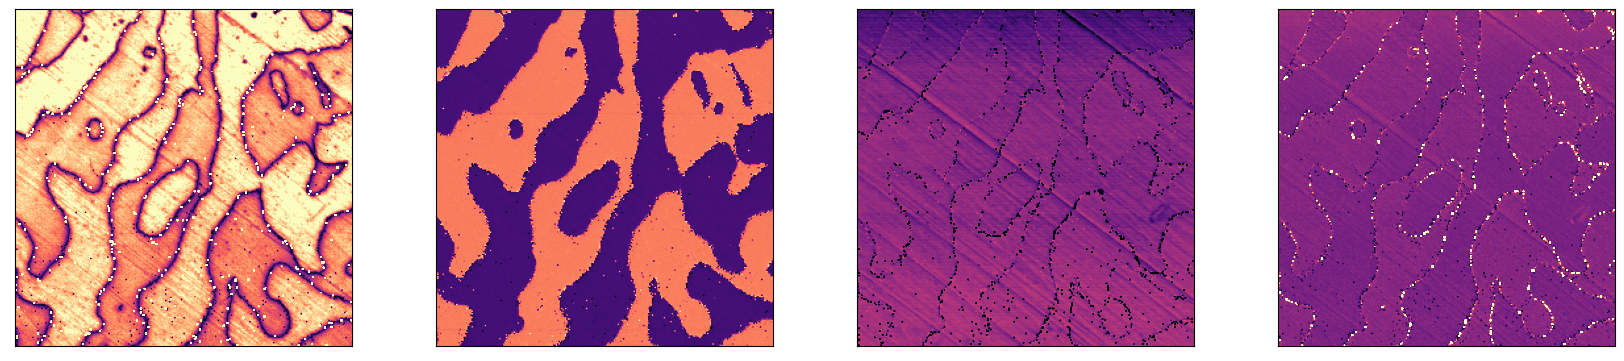

In [19]:
fig=plt.figure(figsize=(20,5))

fontsize = 22

deadchirp=20
numchirp=256

# First row will be of post-RPFM image - 12 um x 12 um
gs1= gridspec.GridSpec(1, 4, hspace=0.15,wspace=0.25,top=0.95, bottom=0.05, left=0.1, right=0.90)# wspace=0.1)
mins=[0,0,335,0]
maxs=[1.2,360,360,150]
pad=0.05
name = 'SN024_2'

#####Plot the Amp iMage
ax= fig.add_subplot(gs1[0,0])
#plt.xlabel("Amplitude "+units["Amp"],labelpad=25)
data=image_data(samp, name, 'Amp',deadchirp, numchirp)
im=plt.imshow(data/1e3, cmap="magma",vmin=mins[0],vmax=maxs[0],aspect='equal')
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=pad)
#cbar=plt.colorbar(im, cax=cax,orientation='vertical')
#ticks=gen_ticks(mins[0],maxs[0],'Amp')
#cbar.set_ticks(ticks)
#cbar.set_ticklabels(ticks)
#cbar.ax.tick_params(labelsize=fontsize)

#####Plot the Phase iMage
ax= fig.add_subplot(gs1[0,1])
#plt.xlabel("Phase "+units["Phase"],labelpad=25)
data=image_data(samp, name, 'Phase',deadchirp, numchirp)
data= data*(180/np.pi)
im=plt.imshow(data, cmap="magma",vmin=mins[1],vmax=maxs[1],aspect='equal')
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
divider = make_axes_locatable(ax)
plt.clim(0,360)
# cax = divider.append_axes("right", size="5%", pad=pad)
# cbar=plt.colorbar(im, cax=cax,orientation='vertical')
# ticks=gen_ticks(90,270,'Phase')
# cbar.set_ticks(ticks)
# cbar.set_ticklabels(ticks)
# cbar.ax.tick_params(labelsize=fontsize)

#####Plot the Res iMage
ax= fig.add_subplot(gs1[0,2])
#plt.xlabel("Frequency "+units["Res"],labelpad=25)
data=image_data(samp, name, 'Res',deadchirp, numchirp)
data= data/1e3
im=plt.imshow(data, cmap="magma",vmin=mins[2],vmax=maxs[2],aspect='equal')
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=pad)
# cbar=plt.colorbar(im, cax=cax, orientation='vertical')
# ticks=gen_ticks(mins[2],maxs[2],'Res')
# cbar.set_ticks(ticks)
# cbar.set_ticklabels(ticks)
# cbar.ax.tick_params(labelsize=fontsize)

#####Plot the Q iMage
ax= fig.add_subplot(gs1[0,3])
#plt.xlabel("Q (a.u.)",labelpad=25)
data=image_data(samp, name, 'Q',deadchirp, numchirp)
im=plt.imshow(data, cmap="magma",vmin=mins[3],vmax=maxs[3],aspect='equal')
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=pad)
# cbar=plt.colorbar(im, cax=cax, orientation='vertical')
# ticks=gen_ticks(mins[3],maxs[3],'Q')
# cbar.set_ticks(ticks)
# cbar.set_ticklabels(ticks)
# cbar.ax.tick_params(labelsize=fontsize)

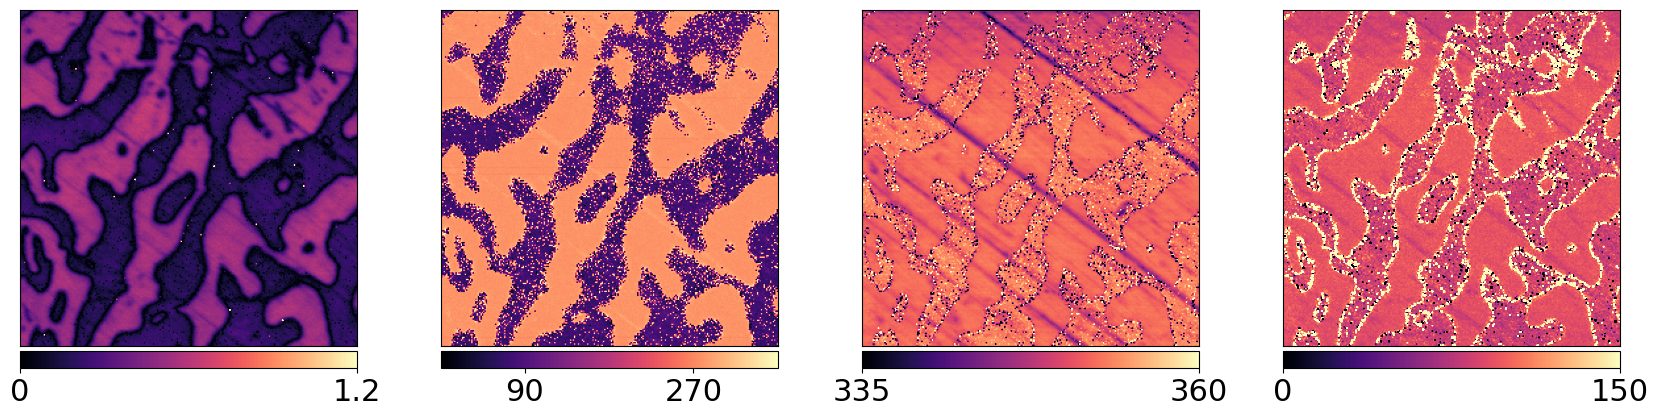

In [20]:
######
fig=plt.figure(figsize=(20, 5))

# First row will be of post-RPFM image - 12 um x 12 um
gs2= gridspec.GridSpec(1, 4,hspace=0.05,wspace=0.25,top=0.95, bottom=0.05, left=0.1, right=0.90)
mins=[0,0,335,0]
maxs=[1.2,360,360,150]
pad=0.05
name = 'SN024_4'

deadchirp=20
numchirp=256

#####Plot the Amp iMage
ax= fig.add_subplot(gs2[0,0])
#plt.xlabel("Amplitude "+units["Amp"],labelpad=10, fontsize=fontsize)
data=image_data(samp, name, 'Amp',deadchirp, numchirp)
im=plt.imshow(data/1e3, cmap="magma",vmin=mins[0],vmax=maxs[0])
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=pad)
cbar=plt.colorbar(im, cax=cax,orientation='horizontal')
ticks=gen_ticks(mins[0],maxs[0],'Amp')
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
cbar.ax.tick_params(labelsize=fontsize)


#####Plot the Phase iMage
ax= fig.add_subplot(gs2[0,1])
#plt.xlabel("Phase "+units["Phase"],labelpad=10, fontsize=fontsize)
data=image_data(samp, name, 'Phase',deadchirp, numchirp)
data= data*(180/np.pi)
im=plt.imshow(data, cmap="magma",vmin=mins[1],vmax=maxs[1])
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
divider = make_axes_locatable(ax)
plt.clim(0,360)
cax = divider.append_axes("bottom", size="5%", pad=pad)
cbar=plt.colorbar(im, cax=cax,orientation='horizontal')
ticks=gen_ticks(90,270,'Phase')
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
cbar.ax.tick_params(labelsize=fontsize)


#####Plot the Res iMage
ax= fig.add_subplot(gs2[0,2])
#plt.xlabel("Frequency "+units["Res"],labelpad=10, fontsize=fontsize)
data=image_data(samp, name, 'Res',deadchirp, numchirp)
data= data/1e3
im=plt.imshow(data, cmap="magma",vmin=mins[2],vmax=maxs[2])
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=pad)
cbar=plt.colorbar(im, cax=cax, orientation='horizontal')
ticks=gen_ticks(mins[2],maxs[2],'Res')
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
cbar.ax.tick_params(labelsize=fontsize)


#####Plot the Q iMage
ax= fig.add_subplot(gs2[0,3])
#plt.xlabel("Q (a.u.)",labelpad=10, fontsize=fontsize)
data=image_data(samp, name, 'Q',deadchirp, numchirp)
im=plt.imshow(data, cmap="magma",vmin=mins[3],vmax=maxs[3])
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=pad)
cbar=plt.colorbar(im, cax=cax, orientation='horizontal')
ticks=gen_ticks(mins[3],maxs[3],'Q')
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
cbar.ax.tick_params(labelsize=fontsize)

## Figure 2 - Clustering PR

### Scree plot function definition

Elbow Method
In the Elbow method, we are actually varying the number of clusters ( K ) from 1 – 10. For each value of K, we are calculating WCSS ( Within-Cluster Sum of Square ). 
WCSS is the sum of squared distance between each point and the centroid in a cluster. When we plot the WCSS with the K value, the plot looks like an Elbow. 
As the number of clusters increases, the WCSS value will start to decrease. WCSS value is largest when K = 1. 
When we analyze the graph we can see that the graph will rapidly change at a point and thus creating an elbow shape. 
From this point, the graph starts to move almost parallel to the X-axis. The K value corresponding to this point is the optimal K value or an optimal number of clusters.

In [38]:
# Scree plot
def plot_scree(data,ax):
    test = data/data.max().max()
    inertias = []
    clusters = range(1, 11)
    for i in clusters:
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(test)
        inertias.append(kmeans.inertia_)
    ax.plot(clusters, inertias,'o-',linewidth=2.0, color='green', label='Full Cycle')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.ticklabel_format(axis='y', style='sci',scilimits=(0,3))
    ax.set_xticks([3,6,9])
    

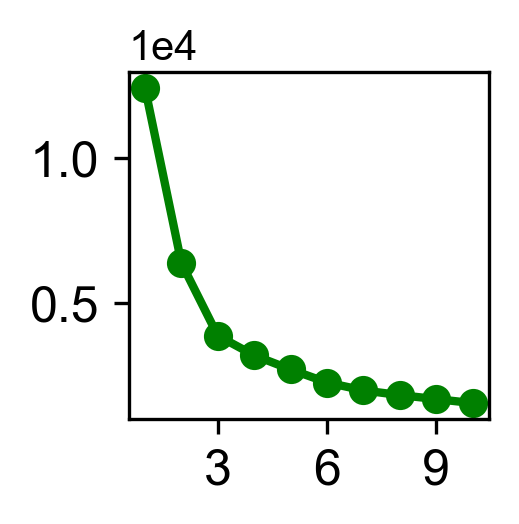

In [40]:
# Plotting
plt.rcParams["font.family"] = "Arial"

#Plot the scree
fig = plt.figure(figsize=(1.55,1.5),dpi=300)
ax = plt.gca()

#Get a data subset
data = out_fill['PR']
plot_scree(data,ax)

### Silhouette Plot (reviewer comments)

For n_clusters = 2 The average silhouette_score is : 0.47143159430221715
For n_clusters = 3 The average silhouette_score is : 0.5141008023900924
For n_clusters = 4 The average silhouette_score is : 0.3774539263093191
For n_clusters = 5 The average silhouette_score is : 0.38180467770178306
For n_clusters = 6 The average silhouette_score is : 0.39689447610682
For n_clusters = 7 The average silhouette_score is : 0.3374728467096896
For n_clusters = 8 The average silhouette_score is : 0.3312069428900302
For n_clusters = 9 The average silhouette_score is : 0.2907193614164902


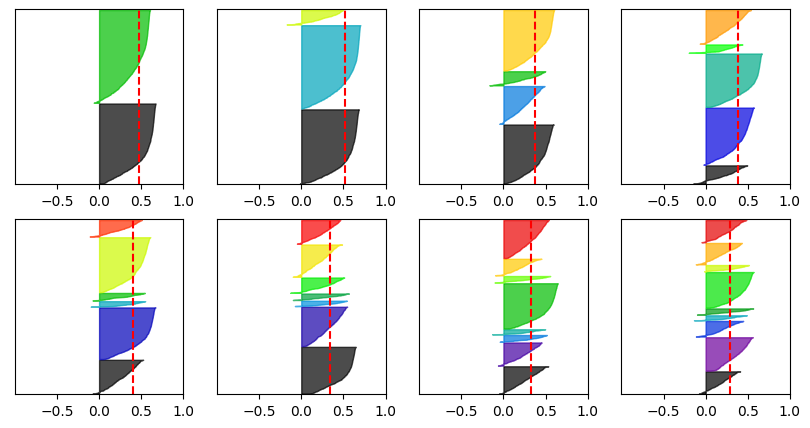

In [24]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm

var = "PR"
df = out_fill
X = pd.concat(dict(P1_c1=df[var][0],P1_c2=df[var][1],P1_c3=df[var][2]),axis=1)

range_n_clusters = [2, 3, 4, 5, 6,7,8,9]

sil_score = []

fig, axes = plt.subplots(2, 4, figsize=(10,5))
axes = axes.ravel()

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    #fig, (ax1, ax2) = plt.subplots(1, 2)
    #fig.set_size_inches(18, 7)
    
    ax1= axes[n_clusters-2]
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init = 'k-means++', random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    sil_score.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        #ax1.text(-0.12, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    #ax1.set_xlabel("The silhouette coefficient values")
    #ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.5, 0, 0.5, 1])

#     # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    

#     im = cluster_labels.reshape(gridSize,gridSize)
#     ax2.imshow(im,origin='upper')
#     ax2.get_yaxis().set_ticks([])
#     ax2.get_xaxis().set_ticks([]);
#     ax2.scatter(
#         X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
#     )

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(
#         centers[:, 0],
#         centers[:, 1],
#         marker="o",
#         c="white",
#         alpha=1,
#         s=200,
#         edgecolor="k",
#     )

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

#     plt.suptitle(
#         "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
#         % n_clusters,
#         fontsize=14,
#         fontweight="bold",
#     )

plt.show()

In [ ]:
# Plot of average silhouette score
fig = plt.figure(figsize=(2,2))
ax = plt.gca()
ax.plot(range_n_clusters, sil_score,'o-',linewidth=2.0, color='green')
#ax.ticklabel_format(axis='y', style='sci',scilimits=(0,3))
ax.set_xticks([3,6,9])
ax.set_ylim([0,0.8])

In [ ]:
np.shape(clusterer.cluster_centers_)

### k=3 and k=10 case

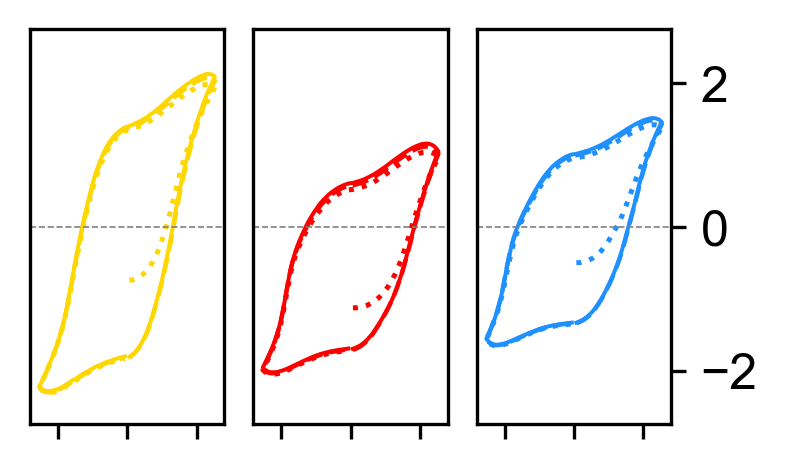

In [57]:
# K-Means clustering on off-F PR

# Parameter
var = "PR"
df = out_fill
Var_stk = pd.concat(dict(P1_c1=df[var][0],P1_c2=df[var][1],P1_c3=df[var][2]),axis=1)

##### Performing K-Means

# Number of clusters
n=3
kmeans = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
kmeans.fit(Var_stk)
kmeans_comps=pd.DataFrame(kmeans.cluster_centers_,columns=Var_stk.columns)

### Plotting
fig=plt.figure(figsize=(2.85, 1.55),dpi=300)
gs= gridspec.GridSpec(1, 3,hspace=0.10,wspace=0.15,top=0.95, bottom=0.1, left=0.05, right=0.80)

c = ['red','dodgerblue','gold']
cscale = matplotlib.colors.ListedColormap(c)

# Order of plots
reorder = [2,0,1]

for i in np.arange(n):
    ax= fig.add_subplot(gs[0,i])
    color=c[reorder[i]]
    plot_parameters(kmeans_comps/1e3,reorder[i],c=color,param="P1")
    plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_ylim([-2.75, 2.75])
    ax.set_xlim([-14, 14])
    #ax.tick_params(axis='x', labelsize=9.5)
    #ax.tick_params(axis='y', labelsize=9.75)
    ax.set_xticklabels([])
    if i !=n-1:
        ax.set_yticklabels([])
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel(' ')

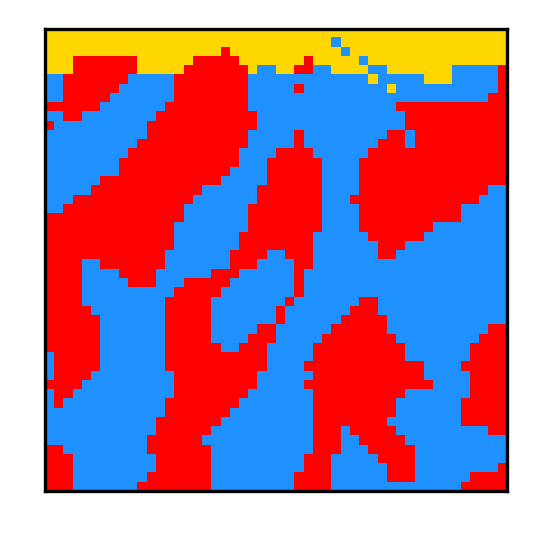

In [59]:
#Figure
fig = plt.figure(figsize=(2, 2),dpi=300)
ax = fig.add_subplot()
im = kmeans.labels_.reshape(gridSize,gridSize)
plt.imshow(im, cmap=cscale, origin='upper')
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([]);

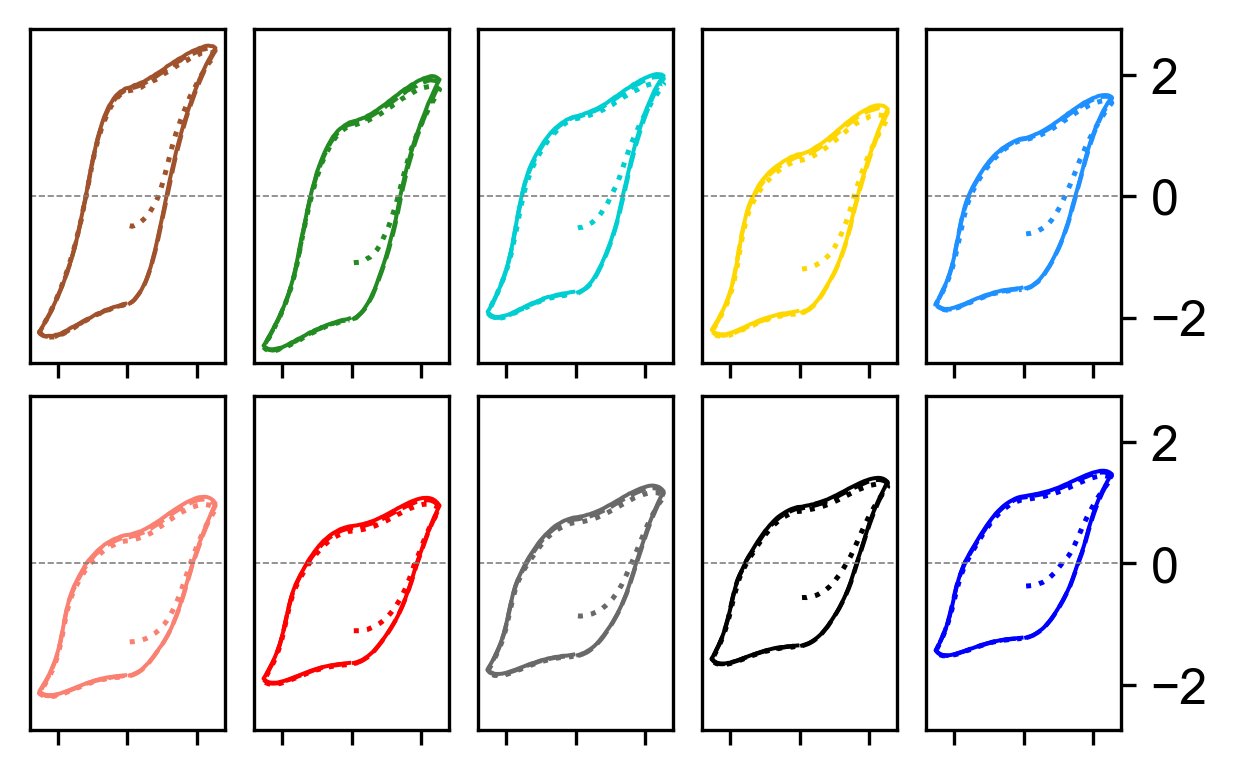

In [61]:
# K-Means clustering on off-F PR

# Parameter
var = "PR"
df = out_fill
Var_stk = pd.concat(dict(P1_c1=df[var][0],P1_c2=df[var][1],P1_c3=df[var][2]),axis=1)

##### Performing K-Means

# Number of clusters
n=10
kmeans = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
kmeans.fit(Var_stk)
kmeans_comps=pd.DataFrame(kmeans.cluster_centers_,columns=Var_stk.columns)

###

# Colors
c1='burlywood'
c2='indigo'
c3='yellowgreen'
c4='darkorange'
c5='gold'
c6='navy'
c7='darkgreen'
c8='navajowhite'
c9='black'
c10='blueviolet'
c11='darkslateblue'
c12='orange'
c13='red'
c15='saddlebrown'
c16='pink'
c14='tomato'
c17='purple'
c18='paleturquoise'

# Domain bulk
dom1_b = convert_rgb_to_names((204,0,0))
dom2_b = convert_rgb_to_names((51,153,255))

# Domain walls
dom1_w = 'darkblue'
dom2_w = 'navy'
dom3_w = 'black'

# electrostatic behavior - yellow (darker shades)
dom0_es = convert_rgb_to_names((255,255,153))
dom1_es = convert_rgb_to_names((0,204,204))
dom2_es = convert_rgb_to_names((255,102,102))
dom3_es = 'cyan'
dom4_es = convert_rgb_to_names((153,255,255))

dom_es_top=convert_rgb_to_names((204,204,0))
dom_es_top_2=convert_rgb_to_names((153,153,0))
dom_es_bottom=convert_rgb_to_names((0,102,204))
dom_es_middle='cyan'

# Topography
dom_t = 'black'
dom_t_2='gray'

fig=plt.figure(figsize=(4.85, 2.75),dpi=300)
gs= gridspec.GridSpec(2, 5,hspace=0.10,wspace=0.15,top=0.95, bottom=0.1, left=0.05, right=0.80)

# Plots of components
# Colors
# First ecm regime
dom_ecm_0 = 'sienna'
# Domain 1 gradient
dom1_ecm_2 = 'salmon'
dom1_ecm_1 = 'gold'
dom1_ecm_3 = 'red'
# Domain 2 gradient
dom2_ecm_1 = 'forestgreen'
dom2_ecm_2 = 'darkturquoise'
dom2_ecm_3 = 'dodgerblue'
dom2_ecm_4 = 'blue'
# Domain wall gradient
dom_w_ecm_1 = 'black'
dom_w_ecm_2 = 'dimgray'

#c = [dom2_ecm_4, dom1_ecm_2, dom2_ecm_3, dom2_ecm_1, dom_ecm_0, dom_w_ecm_2, dom1_ecm_1, dom2_ecm_2, dom1_ecm_3, dom_w_ecm_1]

#c = [dom1_ecm_3, dom2_ecm_4, dom2_ecm_2, dom2_ecm_1, dom_w_ecm_2, dom1_ecm_2, dom_ecm_0, dom2_ecm_3, dom1_ecm_1, dom_w_ecm_1]
c = [dom2_ecm_2, dom_w_ecm_2, dom_w_ecm_1, dom1_ecm_2, dom1_ecm_1, dom_ecm_0, dom2_ecm_1, dom2_ecm_3, dom1_ecm_3, dom2_ecm_4]
cscale = matplotlib.colors.ListedColormap(c)

# Order of plots
#reorder = [8,2,7,9,1,0,5,6,4,3]
#reorder = [4, 3, 6, 7, 1, 9, 2, 0, 8, 5]
reorder=[5, 6, 0, 4, 7, 3, 8, 1, 2, 9]

#reorder = [6, 3, 2, 8, 7, 5, 0, 4, 9, 1]

for i in np.arange(5):
    ax= fig.add_subplot(gs[0,i])
    color=c[reorder[i]]
    plot_parameters(kmeans_comps/1e3,reorder[i],c=color,param="P1")
    plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    ax.set_ylim([-2.75, 2.75])
    ax.set_xlim([-14, 14])
    #ax.tick_params(axis='x', labelsize=9.5)
    #ax.tick_params(axis='y', labelsize=9.75)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xticklabels([])
    if i !=4:
        ax.set_yticklabels([])
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel(' ')
        
    ax= fig.add_subplot(gs[1,i])
    color=c[reorder[5+i]]
    plot_parameters(kmeans_comps/1e3,reorder[5+i],c=color,param="P1")
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    ax.set_ylim([-2.75, 2.75])
    ax.set_xlim([-14, 14])
    #plt.ylabel("PR (a.u.)")
    plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    #ax.tick_params(axis='x', labelsize=9.5)
    #ax.tick_params(axis='y', labelsize=9.75)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xticklabels([])
    
    if i !=4:
        ax.set_yticklabels([])
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel(' ')
        
#ax.legend(ncol=3,bbox_to_anchor=(-1, -0.75, 2, 0.5),frameon=False); 
reorder=[5, 6, 0, 4, 7, 3, 8, 1, 2, 9]

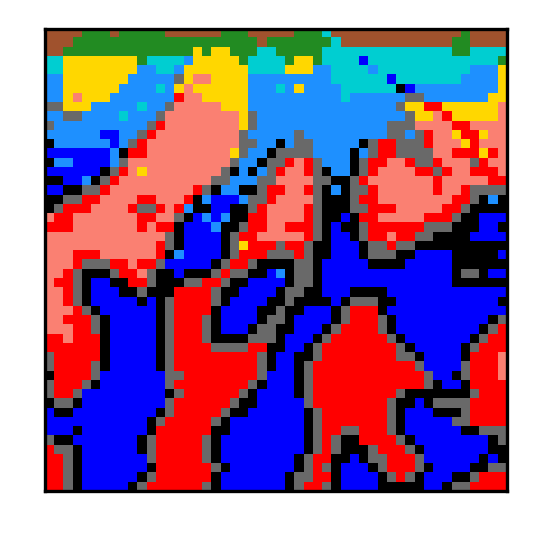

In [56]:
#Figure
fig = plt.figure(figsize=(2, 2),dpi=300)
ax = fig.add_subplot()
im = kmeans.labels_.reshape(gridSize,gridSize)
plt.imshow(im, cmap=cscale, origin='upper')
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([]);

#### Transposed Response

Here we switch the rows and columns:

In [ ]:
# Python3 program to rotate a matrix by 90 degrees
N = gridSize
 
# An Inplace function to rotate
# N x N matrix by 90 degrees in
# anti-clockwise direction
def rotateMatrix(mat):
 
    # Consider all squares one by one
    for x in range(0, int(N / 2)):
 
        # Consider elements in group
        # of 4 in current square
        for y in range(x, N-x-1):
 
            # store current cell in temp variable
            temp = mat[x][y]
 
            # move values from right to top
            mat[x][y] = mat[y][N-1-x]
 
            # move values from bottom to right
            mat[y][N-1-x] = mat[N-1-x][N-1-y]
 
            # move values from left to bottom
            mat[N-1-x][N-1-y] = mat[N-1-y][x]
 
            # assign temp to left
            mat[N-1-y][x] = temp
    return mat

In [ ]:
df = out_fill.copy()

orig = np.ones(gridSize**2).astype(int)

for i in range(len(orig)):
    orig[i]=i

rotated = rotateMatrix(orig.reshape(gridSize,gridSize).copy())

#Figure
fig, axs = plt.subplots(2)
im_1 = orig.reshape(gridSize,gridSize)
axs[0].imshow(im_1, cmap='cividis', origin='upper')
axs[0].get_yaxis().set_ticks([])
axs[0].get_xaxis().set_ticks([]);
im_2 = rotated
axs[1].imshow(im_2, cmap='cividis', origin='upper')
axs[1].get_yaxis().set_ticks([])
axs[1].get_xaxis().set_ticks([]);


In [ ]:
im_1

In [ ]:
rotated.flatten()
out_fill_rt=out_fill.copy()
out_fill_rt=out_fill_rt.reindex(rotated.flatten())

# K-Means clustering on off-F PR

# Parameter
var = "PR"
df = out_fill_rt
Var_stk = pd.concat(dict(P1_c1=df[var][0],P1_c2=df[var][1],P1_c3=df[var][2]),axis=1)

##### Performing K-Means

# Number of clusters
n=10
kmeans = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
kmeans.fit(Var_stk)
kmeans_comps=pd.DataFrame(kmeans.cluster_centers_,columns=Var_stk.columns)

###

# Colors
c1='burlywood'
c2='indigo'
c3='yellowgreen'
c4='darkorange'
c5='gold'
c6='navy'
c7='darkgreen'
c8='navajowhite'
c9='black'
c10='blueviolet'
c11='darkslateblue'
c12='orange'
c13='red'
c15='saddlebrown'
c16='pink'
c14='tomato'
c17='purple'
c18='paleturquoise'

# Domain bulk
dom1_b = convert_rgb_to_names((204,0,0))
dom2_b = convert_rgb_to_names((51,153,255))

# Domain walls
dom1_w = 'darkblue'
dom2_w = 'navy'
dom3_w = 'black'

# electrostatic behavior - yellow (darker shades)
dom0_es = convert_rgb_to_names((255,255,153))
dom1_es = convert_rgb_to_names((0,204,204))
dom2_es = convert_rgb_to_names((255,102,102))
dom3_es = 'cyan'
dom4_es = convert_rgb_to_names((153,255,255))

dom_es_top=convert_rgb_to_names((204,204,0))
dom_es_top_2=convert_rgb_to_names((153,153,0))
dom_es_bottom=convert_rgb_to_names((0,102,204))
dom_es_middle='cyan'

# Topography
dom_t = 'black'
dom_t_2='gray'

fig=plt.figure(figsize=(4.85, 2.75))
gs= gridspec.GridSpec(2, 5,hspace=0.10,wspace=0.15,top=0.95, bottom=0.1, left=0.05, right=0.80)

# Plots of components
# Colors
# First ecm regime
dom_ecm_0 = 'sienna'
# Domain 1 gradient
dom1_ecm_2 = 'salmon'
dom1_ecm_1 = 'gold'
dom1_ecm_3 = 'red'
# Domain 2 gradient
dom2_ecm_1 = 'forestgreen'
dom2_ecm_2 = 'darkturquoise'
dom2_ecm_3 = 'dodgerblue'
dom2_ecm_4 = 'blue'
# Domain wall gradient
dom_w_ecm_1 = 'black'
dom_w_ecm_2 = 'dimgray'

#c = [dom2_ecm_4, dom1_ecm_2, dom2_ecm_3, dom2_ecm_1, dom_ecm_0, dom_w_ecm_2, dom1_ecm_1, dom2_ecm_2, dom1_ecm_3, dom_w_ecm_1]

c = [dom1_ecm_3, dom2_ecm_4, dom2_ecm_2, dom2_ecm_1, dom_w_ecm_2, dom1_ecm_2, dom_ecm_0, dom2_ecm_3, dom1_ecm_1, dom_w_ecm_1]

cscale = matplotlib.colors.ListedColormap(c)

# Order of plots
#reorder = [8,2,7,9,1,0,5,6,4,3]
#reorder = [4, 3, 6, 7, 1, 9, 2, 0, 8, 5]
# reorder = range(n)

reorder = [6, 3, 2, 8, 7, 5, 0, 4, 9, 1]

for i in np.arange(5):
    ax= fig.add_subplot(gs[0,i])
    color=c[reorder[i]]
    plot_parameters(kmeans_comps/1e3,reorder[i],c=color,param="P1")
    plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    ax.set_ylim([-2.75, 2.75])
    ax.set_xlim([-14, 14])
    ax.tick_params(axis='x', labelsize=9.5)
    ax.tick_params(axis='y', labelsize=9.75)
    ax.set_xticklabels([])
    if i !=4:
        ax.set_yticklabels([])
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel(' ')
        
    ax= fig.add_subplot(gs[1,i])
    color=c[reorder[5+i]]
    plot_parameters(kmeans_comps/1e3,reorder[5+i],c=color,param="P1")
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    ax.set_ylim([-2.75, 2.75])
    ax.set_xlim([-14, 14])
    #plt.ylabel("PR (a.u.)")
    plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    ax.tick_params(axis='x', labelsize=9.5)
    ax.tick_params(axis='y', labelsize=9.75)
    ax.set_xticklabels([])
    
    if i !=4:
        ax.set_yticklabels([])
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel(' ')
        
#ax.legend(ncol=3,bbox_to_anchor=(-1, -0.75, 2, 0.5),frameon=False);   

In [ ]:
kmeans_comps.transpose()
np.shape(kmeans.labels_)

In [ ]:
#Figure
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
im = kmeans.labels_.reshape(gridSize,gridSize)
plt.imshow(im, cmap=cscale, origin='upper')
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([]);

In [ ]:
# K-Means clustering on off-F PR

# Parameter
var = "PR"
df = out_fill
Var_stk = pd.concat(dict(P1_c1=df[var][0],P1_c2=df[var][1],P1_c3=df[var][2]),axis=1)

##### Performing K-Means

# Number of clusters
n=10
kmeans = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
kmeans.fit(Var_stk.transpose())
kmeans_comps=pd.DataFrame(kmeans.cluster_centers_,columns=Var_stk.transpose().columns)

###

# Colors
c1='burlywood'
c2='indigo'
c3='yellowgreen'
c4='darkorange'
c5='gold'
c6='navy'
c7='darkgreen'
c8='navajowhite'
c9='black'
c10='blueviolet'
c11='darkslateblue'
c12='orange'
c13='red'
c15='saddlebrown'
c16='pink'
c14='tomato'
c17='purple'
c18='paleturquoise'

# Domain bulk
dom1_b = convert_rgb_to_names((204,0,0))
dom2_b = convert_rgb_to_names((51,153,255))

# Domain walls
dom1_w = 'darkblue'
dom2_w = 'navy'
dom3_w = 'black'

# electrostatic behavior - yellow (darker shades)
dom0_es = convert_rgb_to_names((255,255,153))
dom1_es = convert_rgb_to_names((0,204,204))
dom2_es = convert_rgb_to_names((255,102,102))
dom3_es = 'cyan'
dom4_es = convert_rgb_to_names((153,255,255))

dom_es_top=convert_rgb_to_names((204,204,0))
dom_es_top_2=convert_rgb_to_names((153,153,0))
dom_es_bottom=convert_rgb_to_names((0,102,204))
dom_es_middle='cyan'

# Topography
dom_t = 'black'
dom_t_2='gray'

fig=plt.figure(figsize=(4.85, 2.75))
gs= gridspec.GridSpec(2, 5,hspace=0.10,wspace=0.15,top=0.95, bottom=0.1, left=0.05, right=0.80)

# Plots of components
# Colors
# First ecm regime
dom_ecm_0 = 'sienna'
# Domain 1 gradient
dom1_ecm_2 = 'salmon'
dom1_ecm_1 = 'gold'
dom1_ecm_3 = 'red'
# Domain 2 gradient
dom2_ecm_1 = 'forestgreen'
dom2_ecm_2 = 'darkturquoise'
dom2_ecm_3 = 'dodgerblue'
dom2_ecm_4 = 'blue'
# Domain wall gradient
dom_w_ecm_1 = 'black'
dom_w_ecm_2 = 'dimgray'

#c = [dom2_ecm_4, dom1_ecm_2, dom2_ecm_3, dom2_ecm_1, dom_ecm_0, dom_w_ecm_2, dom1_ecm_1, dom2_ecm_2, dom1_ecm_3, dom_w_ecm_1]

c = [dom1_ecm_3, dom2_ecm_4, dom2_ecm_2, dom2_ecm_1, dom_w_ecm_2, dom1_ecm_2, dom_ecm_0, dom2_ecm_3, dom1_ecm_1, dom_w_ecm_1]

cscale = matplotlib.colors.ListedColormap(c)

# Order of plots
#reorder = [8,2,7,9,1,0,5,6,4,3]
#reorder = [4, 3, 6, 7, 1, 9, 2, 0, 8, 5]
# reorder = range(n)

reorder = [6, 3, 2, 8, 7, 5, 0, 4, 9, 1]

for i in np.arange(5):
    ax= fig.add_subplot(gs[0,i])
    color=c[reorder[i]]
    #plot_parameters(kmeans_comps/1e3,reorder[i],c=color,param="P1")
    plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    ax.set_ylim([-2.75, 2.75])
    ax.set_xlim([-14, 14])
    ax.tick_params(axis='x', labelsize=9.5)
    ax.tick_params(axis='y', labelsize=9.75)
    ax.set_xticklabels([])
    if i !=4:
        ax.set_yticklabels([])
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel(' ')
        
    ax= fig.add_subplot(gs[1,i])
    color=c[reorder[5+i]]
    #plot_parameters(kmeans_comps/1e3,reorder[5+i],c=color,param="P1")
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    ax.set_ylim([-2.75, 2.75])
    ax.set_xlim([-14, 14])
    #plt.ylabel("PR (a.u.)")
    plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    ax.tick_params(axis='x', labelsize=9.5)
    ax.tick_params(axis='y', labelsize=9.75)
    ax.set_xticklabels([])
    
    if i !=4:
        ax.set_yticklabels([])
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel(' ')
        
#ax.legend(ncol=3,bbox_to_anchor=(-1, -0.75, 2, 0.5),frameon=False);   

#### On-Field PR (not needed atm)

In [ ]:
# K-Means clustering on off-F PR

#Parameter
var = "PR"
df = in_fill
Response = pd.concat(dict(P1_c1=df[var][0],P1_c2=df[var][1],P1_c3=df[var][2]),axis=1)

##### Performing K-Means

# Number of clusters
n=10
kmeans = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
kmeans.fit(Response)

kmeans_comps=pd.DataFrame(kmeans.cluster_centers_,columns=Response.columns)

In [ ]:
###
# Colors
# Domain bulk
dom1_b = convert_rgb_to_names((204,0,0))
dom2_b = convert_rgb_to_names((51,153,255))

# Domain walls
dom1_w = 'maroon'
dom2_w = 'navy'
dom3_w = 'black'

# electrostatic behavior - yellow (darker shades)
dom0_es = convert_rgb_to_names((255,255,153))
dom1_es = convert_rgb_to_names((0,204,204))
dom2_es = convert_rgb_to_names((255,102,102))
dom3_es = 'cyan'
dom4_es = convert_rgb_to_names((153,255,255))

dom_es_top=convert_rgb_to_names((204,204,0))
dom_es_top_2=convert_rgb_to_names((153,153,0))
dom_es_bottom=convert_rgb_to_names((0,102,204))
dom_es_middle='cyan'


# Topography
dom_t = 'black'
dom_t_2='gray'

# Remaining figures - plots of components
# Change units to mV add voltage axis for other plots
reorder = [5, 6, 2, 4, 1,3, 7, 8, 9, 0]

c = [dom1_w,dom3_es,dom4_es,dom2_b,dom0_es,dom_es_top_2,dom_es_top,dom2_w,dom2_es,dom1_b]

if n==3:
    c=[dom1_b,dom2_b,dom_es_top]
    reorder=[2,0,1]
    fig=plt.figure(figsize=(5, 3))
if n==4:
    c=[dom_t,dom2_b,dom1_b,dom_es_top]
    reorder=[3,2,1,0]
    fig=plt.figure(figsize=(6, 2.5))
if n==5:
    c=[dom1_b,dom_t,dom2_es,dom2_b,dom1_es]
    reorder=[2,4,0,3,1]
    fig=plt.figure(figsize=(7, 2.5))   
if n==6:
    c=[dom2_es,dom2_b,dom1_b,dom2_w,dom1_es,dom1_w]
    reorder=[0,4,2,1,3,5]
    fig=plt.figure(figsize=(8, 2.5))   

## Second row is for K-Means results on off-F PR
fig=plt.figure(figsize=(12.85, 1.5))
gs= gridspec.GridSpec(1, n, hspace=0.15,wspace=0.1,top=0.95, bottom=0.1, left=0.05, right=0.80)

cscale = matplotlib.colors.ListedColormap(c)

for i in range(n):
    ax= fig.add_subplot(gs[0,i])
    color=c[reorder[i]]
    plot_parameters(kmeans_comps/1e3,reorder[i],c=color,param="P1")
    ax.annotate(r"$k_{}$".format(i+1),(0.75,0.9),xycoords='axes fraction',fontsize=fontsize)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    ax.set_ylim([-4.0, 4.0])
    ax.set_xlim([-14, 14])
    #ax.set_xticks([])
    plt.ylabel("On-F PR (mV)",fontsize=fontsize)
    plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)  
    
    if i !=n-1:
        ax.set_yticklabels([])
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel(' ')

In [ ]:
# Figure
fig=plt.figure(figsize=(5, 5))
ax= fig.add_subplot()
im=kmeans.labels_.reshape(gridSize,gridSize)
plt.imshow(im, cmap=cscale,origin='upper')
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])

## Figure 3 (and Supplementary figs)

[]

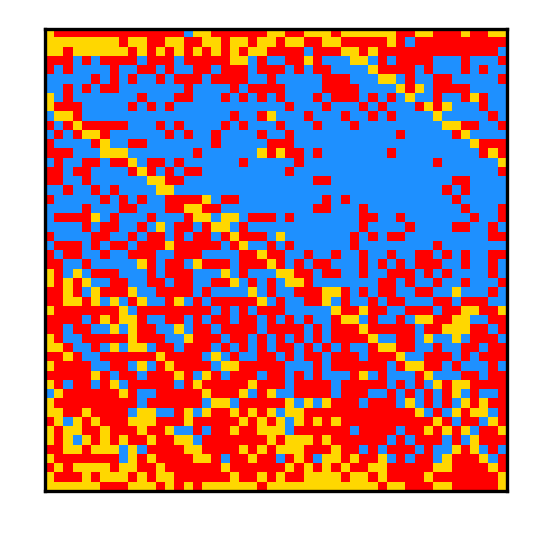

In [75]:
# K-Means on various parameters with k=3 clusters

# colors
dom1_b = 'red'
dom2_b = 'dodgerblue'
dom_es_top = 'gold'

# Pick variable and signal type
var = 'Q'
sig = 'Raw'

if sig == 'Raw':
    df = out_fill
elif sig == 'Global Normalized':
    df = out_norm_global
elif sig == 'Local Normalized':
    df = out_norm_local
elif sig == 'Global Standardized':
    df = out_z_global
elif sig == 'Local Standardized':
    df = out_z_local
else:
    df = out_norm # Combined Normalization
    

Var_stk_out = pd.concat(dict(P1_c1=df[var][0],P1_c2=df[var][1],P1_c3=df[var][2]),axis=1)

##### Performing K-Means

# Number of clusters
n=3
kmeans = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
kmeans.fit(Var_stk_out)

kmeans_comps=pd.DataFrame(kmeans.cluster_centers_,columns=Var_stk_out.columns)
if sig == 'Raw':
    if var== 'Amp':
        c = [dom1_b,dom2_b,dom_es_top]
    elif var== 'Phase':
        c = [dom1_b,dom2_b,dom_es_top]
    elif var== 'Res':
        c = [dom2_b,dom_es_top,dom1_b]
    elif var== 'Q':
        c = [dom2_b,dom_es_top,dom1_b] 
    elif var == 'PR':
        c = [dom_es_top,dom1_b,dom2_b] 
elif sig == 'Global Normalized':
    if var== 'Amp':
        c = [dom1_b,dom2_b,dom_es_top]
    elif var== 'Phase':
        c = [dom1_b,dom2_b,dom_es_top]
    elif var== 'Res':
        c = [dom2_b,dom_es_top,dom1_b]
    elif var== 'Q':
        c = [dom_es_top,dom2_b,dom1_b] 
elif sig == 'Global Standardized':
    if var== 'Amp':
        c = [dom1_b,dom2_b,dom_es_top]
    elif var== 'Phase':
        c = [dom1_b,dom2_b,dom_es_top]
    elif var== 'Res':
        c = [dom1_b,dom_es_top,dom2_b]
    elif var== 'Q':
        c = [dom_es_top,dom2_b,dom1_b]
elif sig == 'Local Normalized':
    if var== 'Amp':
        c = [dom1_b,dom2_b,dom_es_top]
    elif var== 'Phase':
        c = [dom2_b,dom_es_top,dom1_b]
    elif var== 'Res':
        c = [dom1_b,dom_es_top,dom2_b]
    elif var== 'Q':
        c = [dom1_b,dom_es_top,dom2_b]
elif sig == 'Local Standardized':
    if var== 'Amp':
        c = [dom1_b,dom2_b,dom_es_top]
    elif var== 'Phase':
        c = [dom_es_top,dom2_b,dom1_b]
    elif var== 'Res':
        c = [dom_es_top,dom2_b,dom1_b]
    elif var== 'Q':
        c = [dom2_b,dom1_b,dom_es_top]
else: # Combined Normalization
    if var== 'Amp':
        c = [dom1_b,dom2_b,dom_es_top]
    elif var== 'Phase':
        c = [dom1_b,dom2_b,dom_es_top]
    elif var== 'Res':
        c = [dom2_b,dom_es_top,dom1_b]
    elif var== 'Q':
        c = [dom_es_top,dom2_b,dom1_b]

#c=['red','blue','gold']
cscale = matplotlib.colors.ListedColormap(c)

# Quick check on image
fig=plt.figure(figsize=(2,2),dpi=300)
ax= fig.add_subplot()
im=kmeans.labels_.reshape(gridSize,gridSize)
plt.imshow(im, cmap=cscale,origin='upper')
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])

IndexError: list index out of range

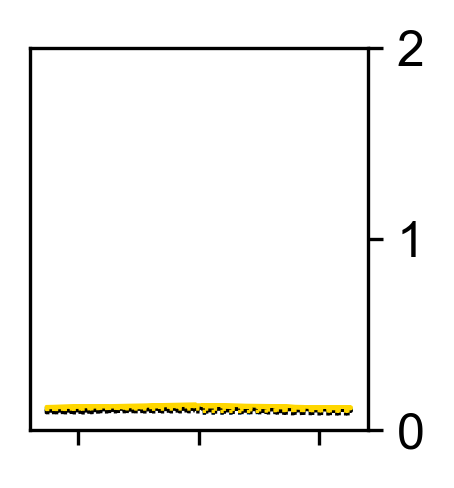

In [103]:
cscale = matplotlib.colors.ListedColormap(c)

# For Figure 2
#fig=plt.figure(figsize=(2.75,1.5))

# For Figure 3
fig=plt.figure(figsize=(1.5,1.5),dpi=300)

## Second row is for K-Means results on off-F PR
gs= gridspec.GridSpec(1, 1,hspace=0.15,wspace=0.15,top=0.95, bottom=0.1, left=0.05, right=0.80)

# fontsize
fontsize = 12
reorder=[2,1,0]

# Remaining figures - plots of components
ax= fig.add_subplot(gs[0,0])
for i in np.arange(0,n):
    color=c[reorder[i]]
    #ax= fig.add_subplot(gs[0,i])
    if sig == 'Raw':
        if var=='Phase' or var == 'Res' or var =='Q':
            plot_parameters(kmeans_comps,reorder[i],c=color,param="P1")
        else:
            plot_parameters(kmeans_comps/1e3,reorder[i],c=color,param="P1")
        # Setting axis limits   
        if var == 'Amp':
            ax.set_yticks([0, 1, 2])
        elif var == 'Phase':
            ax.set_yticks([-180, -90, 0])
            ax.set_ylim([-200,20])
        elif var == 'PR':
            ax.set_yticks([-1, 0, 1])
            plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
        elif var == 'Res':
            ax.set_yticks([352, 356, 360])
        elif var == 'Q':
            ax.set_yticks([90, 110, 130])
            ax.set_ylim([80, 140])
    elif sig == 'Global Normalized':
        plot_parameters(kmeans_comps,reorder[i],c=color,param="P1")
        ax.set_yticks([0, 0.5, 1])
        #plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
        #plt.axhline(y=1, color='gray', linestyle='--',linewidth=0.4)
        ax.set_ylim([-0.1, 1.1])
    elif sig == 'Local Normalized':
        plot_parameters(kmeans_comps,reorder[i],c=color,param="P1")
        ax.set_yticks([0, 0.5, 1])
        #plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
        #plt.axhline(y=1, color='gray', linestyle='--',linewidth=0.4)
        ax.set_ylim([-0.1, 1.1])
    elif sig == 'Global Standardized':
        plot_parameters(kmeans_comps,reorder[i],c=color,param="P1")
        ax.set_ylim([-2.5, 2.5])
        ax.set_yticks([-2, 0, 2])
        # Setting axis limits   
        # if var == 'Amp':
        #     ax.set_ylim([-5, 5])
        # elif var == 'Phase':
        #     ax.set_ylim([-5.5, 5.5])
        # elif var == 'Res':
        #     ax.set_ylim([-10, 2.5])
        # elif var == 'Q':
        #     ax.set_ylim([-5, 5])
    elif sig == 'Local Standardized':
        plot_parameters(kmeans_comps,reorder[i],c=color,param="P1")
        ax.set_yticks([-2, 0, 2])
        # Setting axis limits   
        if var == 'Amp':
            ax.set_ylim([-3, 2.5])
        elif var == 'Phase':
            ax.set_ylim([-3, 2.5])
        elif var == 'Res':
            ax.set_ylim([-3, 2.5])
        elif var == 'Q':
            ax.set_ylim([-3, 2.5])
    else:
        plot_parameters(kmeans_comps,reorder[i],c=color,param="P1")
        #plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
        #plt.axhline(y=1, color='gray', linestyle='--',linewidth=0.4)
        ax.set_ylim([-0.1, 1.1])
        ax.set_yticks([0, 0.5, 1])
    
    #plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    #ax.set_ylim([-0.2, 1.1])
    #ax.set_ylim([-30, 210])
    ax.set_xlim([-14, 14])
    #ax.set_yticks([-2,0,2])
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    #ax.set_ylabel('Amp (mV)')
    ax.set_xticklabels([])
    #ax.set_yticklabels([])
    
    # if i !=n-1:
    #     ax.set_yticklabels([])
    #     ax.get_yaxis().set_ticks([])
    #     ax.set_ylabel(' ')

## Figure 4 - K-Means on Scaled Parameters (dimensional stacking)

In [86]:
# K-Means clustering on raw or scaled parameters

# Dimensional stacking - 1 variable
# We want to understand how K-Means groups based on the datasets we concatenate
# As a first pass we'll look at the in-field and out-field separately for a few variables
# mainly, Resonance, Amplitude, Phase, and PR
# Then, we'll start combining to see what happens:

var = 'Amp'
var2='Phase'
var3 = 'Res'
var4='Q'


# Using Dataframe
df = out_norm.copy()

# Scaling for SI Figures
sig_type = None # Change to None if don't want to convert to base SI units

if sig_type == 'Base SI':
    df['Amp']=df['Amp']*1e-6
    df['Res']=df['Res']*1e3

    
# Amplitude - Phase stack
Amp_Ph_stk=pd.concat(dict(P1_c1=df[var][0], P1_c2=df[var][1],P1_c3=df[var][2],
                      P2_c1=df[var2][0],P2_c2=df[var2][1],P2_c3=df[var2][2]),axis=1)

# Resonance - Q stack
Res_Q_stk=pd.concat(dict(P1_c1=df[var3][0], P1_c2=df[var3][1], P1_c3=df[var3][2],
                     P2_c1=df[var4][0], P2_c2=df[var4][1], P2_c3=df[var4][2]),axis=1)

# All stack
All_stk = pd.concat(dict(P1_c1=df[var][0], P1_c2=df[var][1],P1_c3=df[var][2],
                         P2_c1=df[var2][0], P2_c2=df[var2][1],P2_c3=df[var2][2],
                         P3_c1=df[var3][0], P3_c2=df[var3][1],P3_c3=df[var3][2],
                         P4_c1=df[var4][0], P4_c2=df[var4][1],P4_c3=df[var4][2]),axis=1)

In [177]:
##### Performing K-Means

# Number of clusters
n=5

# Stack 1 - Amp_Phase_stk
kmeans1 = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
kmeans1.fit(Amp_Ph_stk)

kmeans1_comps=pd.DataFrame(kmeans1.cluster_centers_,columns=Amp_Ph_stk.columns)

# Stack 2 - Res_Q_stk
kmeans2 = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
kmeans2.fit(Res_Q_stk)

kmeans2_comps=pd.DataFrame(kmeans2.cluster_centers_,columns=Res_Q_stk.columns)

# Stack 3 - All parameter stack
kmeans3 = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
kmeans3.fit(All_stk)

kmeans3_comps=pd.DataFrame(kmeans3.cluster_centers_,columns=All_stk.columns)

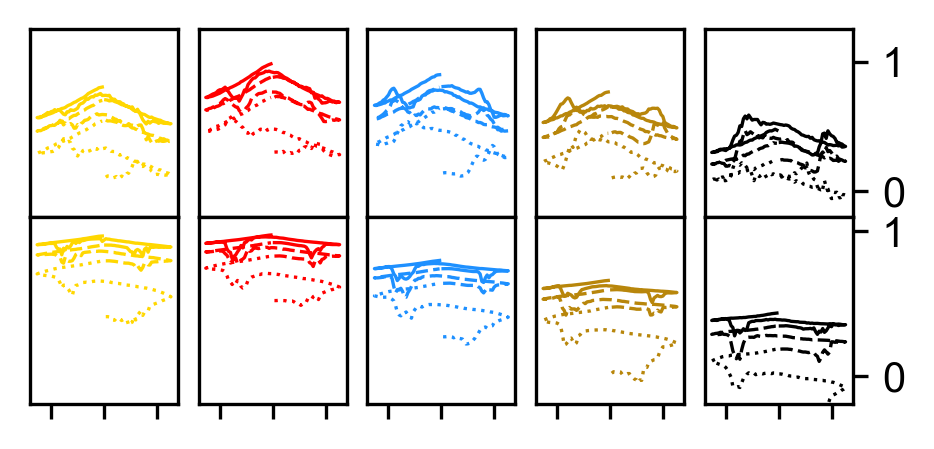

In [181]:
width_ratios=[5,]

for i in range(n):
    width_ratios.append(1.5)

# Number of parameters in stack
num_var = 4

# Domain bulk
dom1_b = convert_rgb_to_names((204,0,0))
dom2_b = convert_rgb_to_names((51,153,255))

# Domain walls
dom1_w = 'maroon'
dom2_w = 'navy'
dom3_w = 'black'

# electrostatic behavior - yellow (darker shades)
dom0_es = convert_rgb_to_names((255,255,153))
dom1_es = convert_rgb_to_names((0,204,204))
dom2_es = convert_rgb_to_names((255,102,102))
dom3_es = 'cyan'
dom4_es = convert_rgb_to_names((153,255,255))

dom_es_top=convert_rgb_to_names((204,204,0))
dom_es_bottom=convert_rgb_to_names((0,102,204))
dom_es_middle='cyan'


# Topography
dom_t = 'black'
dom_t_2='gray'



# Possible stack options
# 1. Amp-Ph
# 2. Res-Q
# 3. All stack

# User selects option:
opt =2

if n == 2:
    fig= plt.figure(figsize=(12,7))
    
    if opt==1:
        df=kmeans1_comps
        kmeans=kmeans1
        c = [dom1_b,dom2_b]
    elif opt==2:
        df=kmeans2_comps
        kmeans=kmeans2
        c = [dom1_b,dom2_b]
    else:
        df=kmeans3_comps
        kmeans=kmeans3
        c = [dom1_b,dom2_b]
        c=[dom1_b,dom2_b] # In SI Units
    
elif n ==3:
    fig= plt.figure(figsize=(12,7))
 
    if opt==1: 
        df=kmeans1_comps
        kmeans=kmeans1
        c = [dom1_b,dom2_b,dom_es_top] 
    elif opt==2:
        df=kmeans2_comps
        kmeans=kmeans2
        c = [c12,c10,c7]  
    else: # It must be last stack
        df=kmeans3_comps
        kmeans=kmeans3
        #c = [dom1_b,dom2_b,dom_es_top] 
        c=[dom2_b,dom1_b,dom_es_top] # SI Units  
        
elif n ==4:
    
    #fig= plt.figure(figsize=(8,2),dpi=300)
    fig= plt.figure(figsize=(5,2.5),dpi=300)
    if opt==1: # It must be last stack
        df=kmeans1_comps
        kmeans=kmeans1
        # For figure 4a
        #c = [dom3_w,dom2_b,dom1_b,dom_es_top]
        
        # For figure 4c-1
        #c = ['white',dom2_b,dom1_b,'white']
        
        # For figure 4c-2
        c = ['lavender','indigo','indigo','indigo']
        
        reorder=[3,2,1,0] # plot 4a
        
    elif opt==2:
        df=kmeans2_comps
        kmeans=kmeans2
        c = [dom1_b,dom_t,dom2_b,dom_es_top]
        reorder=[0,3,1,2]
        
    else:
        df=kmeans3_comps
        kmeans=kmeans3
        c = [dom1_b,dom_t,dom2_b,dom_es_top] # With typical units
        #c=[c7,c9,c12,c10] # With SI Units
        reorder=[3,2,1,0] # Plot 4a
        #reorder = [3,1,2,0]
        
elif n ==5:
    fig= plt.figure(figsize=(5.75,2.5),dpi=300)
    
    if opt==1: 
        df=kmeans1_comps
        kmeans=kmeans1
        c = [dom2_b,dom1_b,dom_es_top,dom_t,dom3_es]  
    
    elif opt==2:
        df=kmeans2_comps
        kmeans=kmeans2
        
        # For full
        #c = ['red','dodgerblue','black','darkgoldenrod','gold']
        c=['red','black','dodgerblue','gold','darkgoldenrod']
        reorder = [3,0,2,4,1]
        #reorder= [0,1,2,3,4]
        # Fig 4c-1
        #c= ['darkorange','chocolate','white','saddlebrown','tan'] # ECM Regimes
        #c=['darkorange','white','chocolate','tan','saddlebrown']
        #c= ['tan','darkorange','chocolate','saddlebrown','white']
        #Fig 4c-2 - topography
        #c = ['lightgray','black','lightgray','lightgray','lightgray']
        
    else: 
        fig= plt.figure(figsize=(8.5,3))
        df=kmeans3_comps
        kmeans=kmeans3
        #c = ['red','black','dodgerblue','gold','darkgoldenrod'] # Colors for Amp in V and Res in Hz
        c=['red','dodgerblue','darkgoldenrod','gold','black'] # Colors in instrument units
        #reorder = [3,0,2,4,1] # # Colors for Amp in V and Res in Hz 
        reorder = [2,3,0,1,4] # Colors in base SI units
        
elif n ==6:
    fig= plt.figure(figsize=(14,5))
    
    if opt==1: # It must be last stack
        df=kmeans1_comps
        kmeans=kmeans1
        c = [dom1_w,dom2_b,dom2_w,dom3_es,dom_es_top,dom1_b]   
    elif opt==2:
        df=kmeans2_comps
        kmeans=kmeans2
        c = ['royalblue','gold','darkkhaki','slategrey','khaki','navy']
        
        reorder=[1,2,4,3,0,5]         
    else:
        df=kmeans3_comps
        kmeans=kmeans3
        c = [dom1_w,dom2_b,dom2_w,dom3_es,dom_es_top,dom1_b]  
        
elif n ==7:
    fig= plt.figure(figsize=(15,5))
    
    if opt==1: 
        df=kmeans1_comps
        kmeans=kmeans1
        c = [dom1_w,dom2_b,dom2_w,dom1_es,dom_es_top,dom1_b,dom2_es]    
    else:
        df=kmeans2_comps
        kmeans=kmeans2
        c = [dom_t,dom2_es,dom2_b,dom4_es,dom1_b,dom1_es,dom_es_top]

elif n ==8:
    fig= plt.figure(figsize=(16,5))
    if opt==1:
        df=kmeans1_comps
        kmeans=kmeans1
        c = [dom2_w,dom2_b,dom1_b,dom1_es,dom0_es,dom_es_top,dom2_es,dom1_w]
    else:
        df=kmeans2_comps
        kmeans=kmeans2
        c = [dom0_es,dom1_es,dom2_es,dom_es_top,dom_t,dom4_es,dom2_b,dom1_b]
    
        
elif n ==9:
    fig= plt.figure(figsize=(16,5))
    if opt==1:
        df=kmeans1_comps
        kmeans=kmeans1
        c = [dom1_w,dom2_b,dom_es_top,dom3_w,dom2_es,dom0_es,dom1_es,dom2_w,dom1_b]
    else:
        df=kmeans2_comps
        kmeans=kmeans2
        c = [dom1_b,dom2_b,dom4_es,dom0_es,dom_t,dom2_es,dom1_es,dom2_es,dom_es_top]
         
#####Plot the first Variable
cscale = matplotlib.colors.ListedColormap(c)

# wspace = 0.075 for main figures

gs= gridspec.GridSpec(num_var,n+1, height_ratios=2*np.ones(num_var), width_ratios=width_ratios, top=1, bottom=0,wspace=0.1, hspace=0.0)


for i,j in zip(reorder,range(n)):
#for i,j in zip(range(n),range(n)):
    color=c[i]
    #print(color,i)
    ax=fig.add_subplot(gs[0,j+1])
    im=plot_parameters(df,i,c=color,param="P2")
    #ax.annotate(r'$k_{'+str(i+1)+'}$',(0.25,0.85),xycoords='axes fraction',fontsize=12)
    #ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    #ax.ticklabel_format(axis='y', style='sci',scilimits=(0,3))
    #plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    #plt.axhline(y=1, color='gray', linestyle='--',linewidth=0.4)
    #ax.set_ylim([-0.1e3, 2.6e3])
    ax.set_ylim([-0.1, 1.1])
    if opt == 2:
        ax.set_ylim([-0.2, 1.25])
    #ax.set_yticks([0,1e3,2e3],fontsize=12)
    ax.set_xlim([-14, 14])
    #ax.set_ylim([-0.1, 1.1])
    plt.gca().axes.get_yaxis().set_visible(False)
    #ax.set_yticks([])
    ax.set_xticks([])
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # If Base SI Units
#     ax.set_ylim([-200*1e-6, 2500*1e-6])
#     ax.set_yticks([250*1e-6,1125*1e-6,2000*1e-6],fontsize=12)
#     ax.set_yticklabels([250*1e-6,'',2000*1e-6],fontsize=12)
    # If regular units
    #ax.set_ylim([-200/1e3, 2500/1e3])
    #ax.set_yticks([250/1e3,1125/1e3,2000/1e3],fontsize=12)
    #ax.set_yticklabels([250/1e3,'',2000/1e3],fontsize=12)
    
    
    if j+1 == n:
        plt.gca().axes.get_yaxis().set_visible(True)
        #ax.set_yticks([0,1])
        
for i,j in zip(reorder,range(n)):
    color=c[i]
    ax=fig.add_subplot(gs[1,j+1])
    im=plot_parameters(df,i,c=color,param="P1")
    #ax.annotate(r"$k_{}$".format(i+1),(0.05,0.80),xycoords='axes fraction',fontsize=10)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    #ax.set_ylim([-30, 230])
    ax.set_ylim([-0.2, 1.1])
    ax.set_xlim([-14, 14])
    plt.gca().axes.get_yaxis().set_visible(False)
    #ax.set_yticks([0,90,180],fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    #ax.set_xticks([])
    #plt.gca().axes.get_xaxis().set_visible(False)
    #ax.set_xticks([-10,0,10])
    ax.set_xticklabels([])
    
    #ax.set_ylim([-200, 20])
    #ax.set_yticks([-180,-90,0],fontsize=12)
    #ax.set_yticklabels([-180,'',0],fontsize=12)
       

    if j+1 == n:
        #plt.ylabel(var,fontsize=10)
        plt.gca().axes.get_yaxis().set_visible(True)
        #ax.set_yticks([0,1])

# for i,j in zip(reorder,range(n)):
#     color=c[i]
#     ax=fig.add_subplot(gs[2,j+1])
#     im=plot_parameters(df,i,c=color,param="P3")
#     #ax.annotate(r"$k_{}$".format(i+1),(0.05,0.80),xycoords='axes fraction',fontsize=10)
#     ax.yaxis.set_label_position("right")
#     ax.yaxis.set_ticks_position("right")
#     #ax.ticklabel_format(axis='y', style='sci',scilimits=(0,3))
    
#    #ax.set_ylim([-0.1, 1.1])
#     # If base SI Units
# #     ax.set_ylim([352000, 362000])
# #     ax.set_yticks([354000,357000,360000],fontsize=12)
# #     ax.set_yticklabels([354000,'',360000],fontsize=12)
#     # Instrument units
    
#     ax.set_ylim([352, 362])
#     ax.set_yticks([354,357,360],fontsize=12)
#     ax.set_yticklabels([354,'',360],fontsize=12)
    
#     ax.set_xlim([-14, 14])
#     #ax.set_yticks([355,358,361])
#     plt.gca().axes.get_xaxis().set_visible(False)
#     plt.gca().axes.get_yaxis().set_visible(False)
#     ax.set_xticks([])
#     ax.tick_params(axis='both', which='major', labelsize=12)
    
#     if j+1 == n:
#         plt.gca().axes.get_yaxis().set_visible(True)

# for i,j in zip(reorder,range(n)):
#     color=c[i]
#     ax=fig.add_subplot(gs[3,j+1])
#     im=plot_parameters(df,i,c=color,param="P4")
#     #ax.annotate(r"$k_{}$".format(i+1),(0.05,0.80),xycoords='axes fraction',fontsize=10)
#     ax.yaxis.set_label_position("right")
#     ax.yaxis.set_ticks_position("right")
#     #ax.set_ylim([300, 370])
#     ax.set_xlim([-14, 14])
#     ax.set_ylim([70, 140])
#     ax.set_yticks([90,112.5,135],fontsize=12)
#     ax.set_yticklabels([90,'',135],fontsize=12)
#     ax.set_xticklabels([],fontsize=12)
#     #ax.set_ylim([-0.1, 1.1])
#     #ax.set_yticks([pr_min+incr_pr,0, pr_max-incr_pr])
#     plt.gca().axes.get_xaxis().set_visible(True)
#     plt.gca().axes.get_yaxis().set_visible(False)
#     #ax.set_yticks([])
#     ax.tick_params(axis='both', which='major', labelsize=12)


#     if j+1 == n:
#         plt.gca().axes.get_yaxis().set_visible(True)
        
plt.show();


##### Supplementary Fig Locally normalized parameters

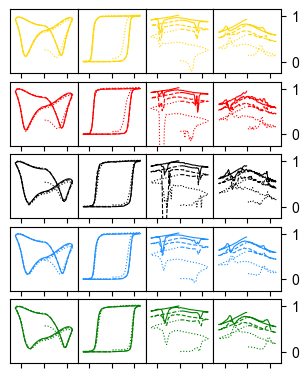

In [109]:
# Colors


# Variables
var1 = 'Amp'
var2 = 'Phase'
var3 = 'Res'
var4 = 'Q'
num_var = 4

# Dataframe of interest
df = out_norm_local.copy()

# Next we form the stack
A_Ph_Res_Q_stk=pd.concat(dict(P1_c1=df[var1][0], P1_c2=df[var1][1],P1_c3=df[var1][2],
                              P2_c1=df[var2][0], P2_c2=df[var2][1],P2_c3=df[var2][2],
                              P3_c1=df[var3][0], P3_c2=df[var3][1],P3_c3=df[var3][2],
                              P4_c1=df[var4][0], P4_c2=df[var4][1],P4_c3=df[var4][2]),axis=1)

# Next we perform k-Means on the desired stack
stack = A_Ph_Res_Q_stk

# Select number of clusters desired
n=5

# Perform clustering
kmeans = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
kmeans.fit(stack)
kmeans_comps=pd.DataFrame(kmeans.cluster_centers_,columns=stack.columns)
df = kmeans_comps

# Plotting the response
if n ==2:
    fig= plt.figure(figsize=(15,10))
    c = [c1,c2]
elif n ==3:
    fig= plt.figure(figsize=(3.5,5))
    c = ['red','dodgerblue','black']   # colors for dimensionally stacked case
    reorder = [0,2,1]
elif n ==4:
    fig= plt.figure(figsize=(3.5,5.5))
    c = ['dodgerblue','red','black','gold']
    reorder=[3,1,2,0]
elif n ==5:
    fig= plt.figure(figsize=(3.5,5.75))
    c=['dodgerblue','red','black','gold','green']
    reorder=[3,1,2,0,4]
elif n ==6:
    fig= plt.figure(figsize=(15,10))
    c = [c1,c2,c3,c4,c5,c6,cnone]    
    

# Assign colors to cmap

cscale = matplotlib.colors.ListedColormap(c)

# Grid spec parameters
height_ratios=[5,]

for i in range(n):
    height_ratios.append(1.5)

# Create grid for parameter responses
#gs= gridspec.GridSpec(num_var,n+1, height_ratios=5*np.ones(num_var), width_ratios=width_ratios, top=1, bottom=0,wspace=0.0,hspace=0.0)

gs= gridspec.GridSpec(n+1,num_var, height_ratios=height_ratios, width_ratios=np.ones(num_var), top=1, bottom=0,wspace=0.0,hspace=0.10)

# Font size
fontsize =12

# First parameter - Amplitude
for i,j in zip(reorder,range(n)):
    color=c[i]
    #print(color,i)
    ax=fig.add_subplot(gs[j+1,0])
    im=plot_parameters(df,i,c=color,param="P1")
    #ax.annotate(r'$k_{'+str(i+1)+'}$',(0.05,0.90),xycoords='axes fraction',fontsize=fontsize)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    #plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    #plt.axhline(y=1, color='gray', linestyle='--',linewidth=0.4)
    #ax.set_ylim([-0.25, 1.15])
    ax.set_xlim([-15, 15])
    ax.set_ylim([-0.25, 1.15])
    plt.gca().axes.get_yaxis().set_visible(False)
 
    ax.set_xticks([-10, 0, 10])
    ax.set_xticklabels([])
    #ax.set_yticks([0,1])
    #if j == 0:
    #    ax.set_title('A',fontsize=fontsize)
    if i+1 == n:
        #plt.ylabel('A',fontsize=fontsize)
        plt.gca().axes.get_yaxis().set_visible(True)
        
# Second parameter - Phase
for i,j in zip(reorder,range(n)):
    color=c[i]
    #print(color,i)
    ax=fig.add_subplot(gs[j+1,1])
    im=plot_parameters(df,i,c=color,param="P2")
    #ax.annotate(r'$k_{'+str(i+1)+'}$',(0.05,0.85),xycoords='axes fraction',fontsize=12)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    #plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    #plt.axhline(y=1, color='gray', linestyle='--',linewidth=0.4)
    ax.set_ylim([-0.25, 1.15])
    ax.set_xlim([-15, 15])
    plt.gca().axes.get_yaxis().set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([-10, 0, 10])
    ax.set_xticklabels([])
    
    #if j == 0:
   #     ax.set_title('$\Theta$',fontsize=fontsize)

    if i+1 == n:
        #plt.ylabel('$\Theta$',fontsize=fontsize)
        plt.gca().axes.get_yaxis().set_visible(True)        

# Third parameter - Resonance
for i,j in zip(reorder,range(n)):
    color=c[i]
    #print(color,i)
    ax=fig.add_subplot(gs[j+1,2])
    im=plot_parameters(df,i,c=color,param="P3")
    #ax.annotate(r'$k_{'+str(i+1)+'}$',(0.05,0.85),xycoords='axes fraction',fontsize=12)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    #plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    #plt.axhline(y=1, color='gray', linestyle='--',linewidth=0.4)
    ax.set_ylim([-0.25, 1.15])
    ax.set_xlim([-15, 15])
    
    plt.gca().axes.get_yaxis().set_visible(False)

    ax.set_xticks([-10, 0, 10])
    ax.set_xticklabels([])

   # if j == 0:
   #     ax.set_title('$\omega$',fontsize=fontsize)

    if i+1 == n:
        #plt.ylabel('$\omega$',fontsize=fontsize)
        plt.gca().axes.get_yaxis().set_visible(True)
        
# Fourth parameter - Quality factor
for i,j in zip(reorder,range(n)):
    color=c[i]
    #print(color,i)
    ax=fig.add_subplot(gs[j+1,3])
    im=plot_parameters(df,i,c=color,param="P4")
    #ax.annotate(r'$k_{'+str(i+1)+'}$',(0.05,0.85),xycoords='axes fraction',fontsize=12)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    #plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    #plt.axhline(y=1, color='gray', linestyle='--',linewidth=0.4)
    ax.set_ylim([-0.25, 1.15])
    ax.set_xlim([-15, 15])
    plt.gca().axes.get_yaxis().set_visible(True)
    ax.set_yticks([0,1])
    ax.set_xticks([-10, 0, 10])
    ax.set_xticklabels([])

    #if j == 0:
    #    ax.set_title('Q',fontsize=fontsize)
        
    if i+1 == n:
        #plt.ylabel('Q',fontsize=fontsize)
        plt.gca().axes.get_yaxis().set_visible(True)
        
plt.show();       

### Map Figure

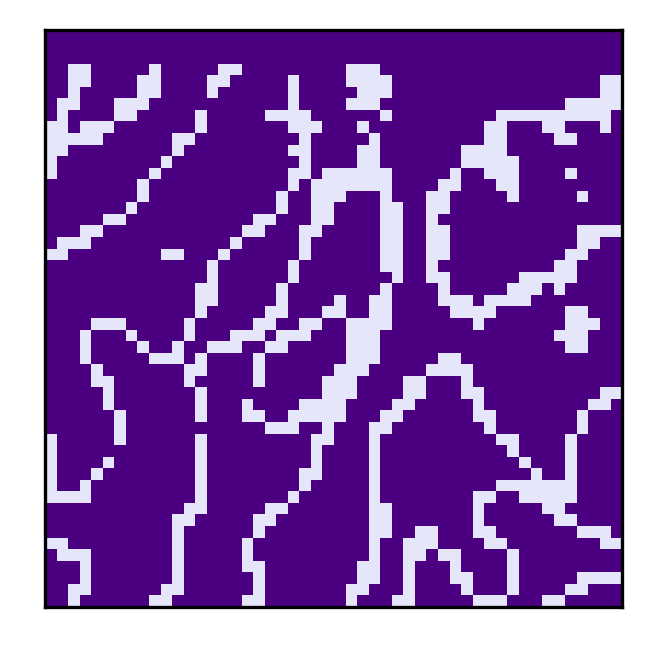

In [176]:
#Plot the Label Map
fig= plt.figure(figsize=(2.5,2.5),dpi=300)
ax = fig.add_subplot()
im = kmeans.labels_.reshape(gridSize,gridSize)
plt.imshow(im, cmap=cscale,origin='upper')
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)

plt.show()

#### Visualizing chirp response at specific locations

In [ ]:

mask_loc = np.full((gridSize**2),False) # Initialize array of false
sft = 5
locs_1 = np.arange(sft+630,sft+636)
locs_2 = np.arange(sft+680,sft+686)
locs_3 = np.arange(sft+730,sft+736)
locs_4 = np.arange(sft+780,sft+786)
locs_5 = np.arange(sft+830,sft+836)

locs = np.concatenate((locs_1,locs_2,locs_3,locs_4,locs_5))
mask_loc[locs] = True

c1 = 'white'
c2 = 'black'

cscale = matplotlib.colors.ListedColormap([c1, c2])


fig= plt.figure(figsize=(5,5))
ax = fig.add_subplot()
plt.imshow(mask_loc.reshape((gridSize,gridSize)), cmap=cscale,origin='upper')
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)

plt.show()

# Plotting the response
num_row = 3
num_col = 10
num_plots = num_row * num_col
fig=plt.figure(figsize=(35.0,15))
gs= gridspec.GridSpec(num_row,num_col,hspace=0.3)

df=out_fill_new


for i in np.arange(num_plots):
    pnt = locs[i]
    if i < 10:
        ax= fig.add_subplot(gs[0,i])
    elif i < 20:
        ax= fig.add_subplot(gs[1,i-10])
    else:
        ax= fig.add_subplot(gs[2,i-20])
        
    pnt_plot_gs(df,pnt,'Q')  
    ax.set_ylim([70,160])
    ax.set_title('loc:'+str(pnt))
    if i != 0:
        ax.set_yticks([])

## plotting average from group of locations

# fig=plt.figure(figsize=(6,6))

# df=out_fill_new

# locs = np.arange(630,650)

# ax= fig.add_subplot()
# ave_plot_gs(df.iloc[locs,:],'Q')  



## Figure 5 - Differential Loops

Scree plot differential loop

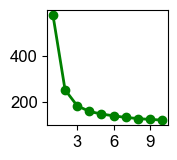

In [182]:
# Plotting
#Plot the scree
fig = plt.figure(figsize=(1.55,1.5))
ax = plt.gca()

#Get a data subset
data = in_fill['PR'].values-out_fill['PR'].values
plot_scree(data,ax)

[]

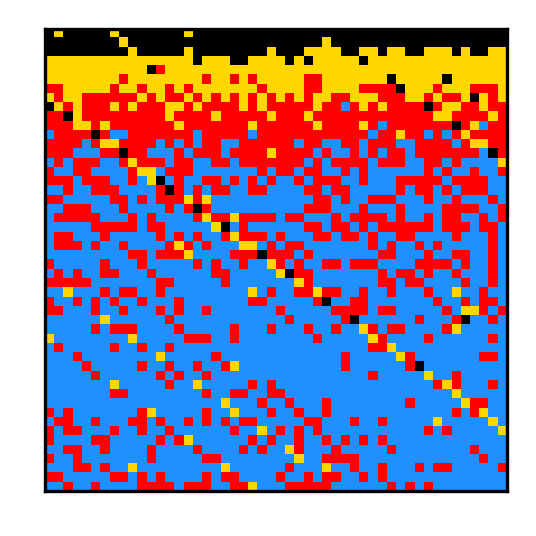

In [264]:
# Calculating diferential loop
df = in_fill['PR'].values-out_fill['PR'].values

df = pd.DataFrame(df,columns=out_fill['PR'].columns)

differential = pd.concat(dict(P1_c1=df[0],P1_c2=df[1],P1_c3=df[2]),axis=1)

##### Performing K-Means

# Number of clusters
n=4
kmeans = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
kmeans.fit(differential)

kmeans_comps=pd.DataFrame(kmeans.cluster_centers_,columns=differential.columns)

if n==3:
    c=['blue','gold','red']
if n==4:
    c=['red','black','dodgerblue','gold']
if n==5:
    c=['blue','gold','firebrick','olive','darkorange']
if n==6:
    c=['darkorange','gold','black','blue','olive','red']
if n==7:
    c=['blue','olive','firebrick','darkorange','darkturquoise','gold','black']

cscale = matplotlib.colors.ListedColormap(c)

# Quick check on image
fig=plt.figure(figsize=(2,2),dpi=300)
ax= fig.add_subplot()
im=kmeans.labels_.reshape(gridSize,gridSize)
plt.imshow(im, cmap=cscale,origin='upper')
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])


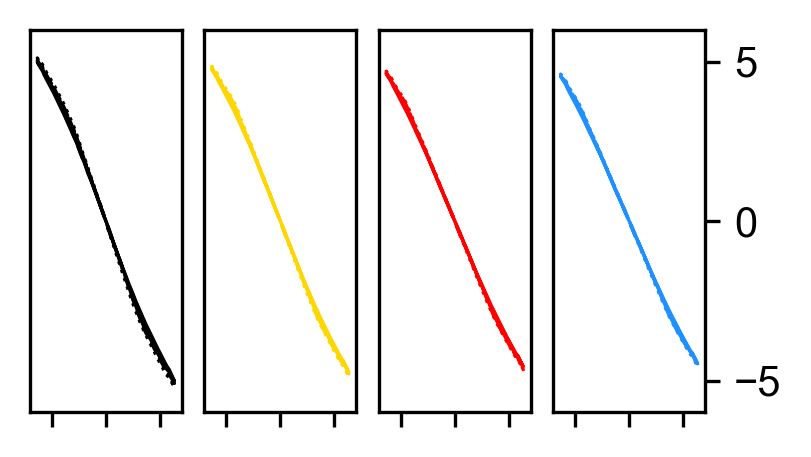

In [266]:
cscale = matplotlib.colors.ListedColormap(c)


if n==3:
    reorder=[1,2,0]
    fig=plt.figure(figsize=(3,1.5))
if n==4:
    
    reorder=[1, 3, 0, 2]
    fig=plt.figure(figsize=(3,1.5),dpi=300)
if n==5:
    reorder=[3,1,4,2,0]
    #reorder=[0,1,2,3,4]
    fig=plt.figure(figsize=(5,1.5))
if n==6:
    reorder=[2,4,1,0,5,3]
    #reorder=[0,1,2,3,4,5]
    fig=plt.figure(figsize=(5.75,1.5))

    
## Second row is for K-Means results on off-F PR
gs= gridspec.GridSpec(1, n,hspace=0.15,wspace=0.15,top=0.95, bottom=0.1, left=0.05, right=0.80)

# fontsize
fontsize = 10

#ax= fig.add_subplot()
# Remaining figures - plots of components
for i in np.arange(0,n):
    color=c[reorder[i]]
    ax= fig.add_subplot(gs[0,i])
    
    plot_parameters(kmeans_comps/1e3,reorder[i],c=color,param="P1")
    #ax.annotate(r'$k_{'+str(i+1)+'}$',(0.70,0.90),xycoords='axes fraction',fontsize=fontsize,color=color)
    #plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    #plt.axvline(x=0, color='gray', linestyle='--',linewidth=0.4)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    ax.set_xlim([-14, 14])
    ax.set_ylim([-6, 6])
    ax.set_yticks([-5,0,5])
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xticklabels([])
    
    if i !=n-1:
        ax.set_yticklabels([])
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel(' ')

In [ ]:

N1=kmeans_comps.iloc[reorder[0],:].values
N2=kmeans_comps.iloc[reorder[1],:].values
N3=kmeans_comps.iloc[reorder[2],:].values
N4=kmeans_comps.iloc[reorder[3],:].values
#N5=kmeans_comps.iloc[reorder[4],:].values

x=kmeans_comps.columns.get_level_values('xaxis').astype(float)

df_csv = pd.DataFrame({'Bias(V)': x,
                       'N1': N1,
                       'N2': N2,
                       'N3': N3,
                       'N4': N4})
#df_csv.to_csv(path_or_buf="N1_to_N5_Differentials",index=False)

In [ ]:
### Plotting the centroids (mean and median version)
# Generating the average response for each cluster across all four parameters

k_labels = kmeans.labels_
k1 = np.where(k_labels==reorder[0])[0]
k2 = np.where(k_labels==reorder[1])[0]    
k3 = np.where(k_labels==reorder[2])[0]
k4 = np.where(k_labels==reorder[3])[0]
#k5 = np.where(k_labels==reorder[4])[0]

# Figures for final Clusters

fontsize=10

# 1st Row - Off-F PR where each cell has 2 curves corresponding to up/down domains
data=out_fill
x=data['Amp'].columns.get_level_values('xaxis').astype(float)

var_list = ['Amp','Phase','Res','Q']

gs= gridspec.GridSpec(4,4,wspace=0.075,hspace=0.075)

fig= plt.figure(figsize=(6,6))

# Limits
Amin, Amax = [0,2.5]
Phmin, Phmax = [-220, 20]
Wmin,Wmax = [354, 362]
Qmin, Qmax = [75, 137]

for var,i in zip(var_list,np.arange(0,4)):
    
    # 1st column
    ax=fig.add_subplot(gs[i,0])
    if var == 'Amp':
        #y=data[var].iloc[k_dom1_ecm2].mean(axis=0).values/1e3
        y=data[var].iloc[k1].mean(axis=0).values/1e3
        ax.set_ylim([Amin,Amax])
        ax.xaxis.set_ticks([])
    elif var == 'Phase':
        #y=data[var].iloc[k_dom1_ecm2].mean(axis=0).values
        y=data[var].iloc[k1].mean(axis=0).values
        ax.set_ylim([Phmin,Phmax])
        ax.xaxis.set_ticks([])
    elif var == 'Res':
        #y=data[var].iloc[k_dom1_ecm2].mean(axis=0).values
        y=data[var].iloc[k1].mean(axis=0).values
        ax.set_ylim([Wmin,Wmax])
        ax.xaxis.set_ticks([])
    else:
        #y=data[var].iloc[k_dom1_ecm2].mean(axis=0).values
        y=data[var].iloc[k1].mean(axis=0).values
        ax.set_ylim([Qmin,Qmax])
        ax.set_ylim([70,150])
        #ax.set_xlabel('Bias (V)')   
        
    ax.plot(x,y,color=c[reorder[0]],linestyle='-', markersize=1.5,linewidth=0.8) 
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xlim([-14,14])    
    ax.yaxis.set_ticks([])
    
    # 2nd column
    ax=fig.add_subplot(gs[i,1])
    if var == 'Amp':
        #y=data[var].iloc[k_dom1_ecm3].mean(axis=0).values/1e3
        y=data[var].iloc[k2].mean(axis=0).values/1e3
        ax.set_ylim([Amin,Amax])
        ax.xaxis.set_ticks([])
    elif var == 'Phase':
        #y=data[var].iloc[k_dom1_ecm3].mean(axis=0).values
        y=data[var].iloc[k2].mean(axis=0).values
        ax.set_ylim([Phmin,Phmax])
        ax.xaxis.set_ticks([])
    elif var == 'Res':
        #y=data[var].iloc[k_dom1_ecm3].mean(axis=0).values
        y=data[var].iloc[k2].mean(axis=0).values
        ax.set_ylim([Wmin,Wmax])
        ax.xaxis.set_ticks([])
    else:
        #y=data[var].iloc[k_dom1_ecm3].mean(axis=0).values
        y=data[var].iloc[k2].mean(axis=0).values
        ax.set_ylim([Qmin,Qmax])
        ax.set_ylim([70,150])
        #ax.set_xlabel('Bias (V)')   
    ax.plot(x,y,color=c[reorder[1]],linestyle='-', markersize=1.5,linewidth=0.8)

    ax.set_xlim([-14,14])    
    ax.yaxis.set_ticks([])
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    
    # 3rd column
    ax=fig.add_subplot(gs[i,2])
    if var == 'Amp':
        #y=data[var].iloc[k_dom1_ecm3].mean(axis=0).values/1e3
        y=data[var].iloc[k3].mean(axis=0).values/1e3
        ax.set_ylim([Amin,Amax])
        ax.xaxis.set_ticks([])
    elif var == 'Phase':
        #y=data[var].iloc[k_dom1_ecm3].mean(axis=0).values
        y=data[var].iloc[k3].mean(axis=0).values
        ax.set_ylim([Phmin,Phmax])
        ax.xaxis.set_ticks([])
    elif var == 'Res':
        #y=data[var].iloc[k_dom1_ecm3].mean(axis=0).values
        y=data[var].iloc[k3].mean(axis=0).values
        ax.set_ylim([Wmin,Wmax])
        ax.xaxis.set_ticks([])
    else:
        #y=data[var].iloc[k_dom1_ecm3].mean(axis=0).values
        y=data[var].iloc[k3].mean(axis=0).values
        ax.set_ylim([Qmin,Qmax])
        ax.set_ylim([70,150])
        ax.set_xlabel('Bias (V)')   
    ax.plot(x,y,color=c[reorder[2]],linestyle='-', markersize=1.5,linewidth=0.8)

    ax.set_xlim([-14,14])    
    ax.yaxis.set_ticks([])
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    
    # 4th column
    ax=fig.add_subplot(gs[i,3])
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    
    if var == 'Amp':
        #y=data[var].iloc[k_dom1_ecm4].mean(axis=0).values/1e3
        y=data[var].iloc[k4].mean(axis=0).values/1e3
        ax.set_ylim([Amin,Amax])
        ax.xaxis.set_ticks([])
        ax.set_ylabel('A (mV)')
        ax.set_yticks([0,1, 2])
        ax.set_yticklabels([0,'',2])
        ax.get_yaxis().set_label_coords(1.2,0.40)
    elif var == 'Phase':
        #y=data[var].iloc[k_dom1_ecm4].mean(axis=0).values
        y=data[var].iloc[k4].mean(axis=0).values
        ax.set_ylim([Phmin,Phmax])
        ax.xaxis.set_ticks([])
        ax.set_ylabel('$\Theta(\circ)$')
        ax.set_yticks([-180,-90, 0])
        ax.set_yticklabels([-180,'',0])
        ax.get_yaxis().set_label_coords(1.2,0.45)
    elif var == 'Res':
        #y=data[var].iloc[k_dom1_ecm4].mean(axis=0).values
        y=data[var].iloc[k4].mean(axis=0).values
        ax.set_ylim([Wmin,Wmax])
        ax.xaxis.set_ticks([])
        ax.set_ylabel('$\omega$(kHz)')
        ax.set_yticks([353,357, 361])
        ax.set_yticklabels([353,'',361])
        ax.get_yaxis().set_label_coords(1.2,0.48)
    else:
        #y=data[var].iloc[k_dom1_ecm4].mean(axis=0).values
        y=data[var].iloc[k4].mean(axis=0).values
        ax.set_ylim([Qmin,Qmax])
        #ax.set_xlabel('Bias (V)') 
        ax.set_ylabel('Q')
        ax.get_yaxis().set_label_coords(1.2,0.6)
        ax.set_yticks([85,107.5, 130])
        ax.set_yticklabels([80,'',130])
        
    ax.plot(x,y,color=c[reorder[3]],linestyle='-',linewidth=0.8)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xlim([-14,14])    
      
    #plt.tight_layout()

### Characterizing differential loops

In [ ]:

def PR_diff_loop_stats_linearFit(df): 
    num_rows = np.shape(df)[0]
    x=df.columns.get_level_values('xaxis').astype(float)
    y=np.zeros((num_rows,len(x)))
    y_max= np.zeros(num_rows)
    y_min= np.zeros(num_rows)
    line_eval=np.zeros((num_rows,len(x)))
    line_diff=np.zeros((num_rows,len(x)))
    y_mean = np.zeros(num_rows) # Mean response
    rss = np.zeros(num_rows) # Residual Sum Squares (least-squares fit)
    tss = np.zeros(num_rows) # Total Sum Squares
    R_squared = np.zeros(num_rows) # Total Sum Squares
    slope = np.zeros(num_rows) # Slope of each line
    y_intercept = np.zeros(num_rows) # y-intercept of each line

    for i in np.arange(0,num_rows):
        y[i,:]=df.iloc[i].values
        y_mean[i] = np.mean(y[i,:])
        y_max[i]= np.max(y[i,:])
        y_min[i]= np.min(y[i,:])
        for j in np.arange(len(y[i,:])):
            tss[i]+=(y[i,j]-y_mean[i])**2 
        linfit = np.polyfit(x, y[i,:], deg=1,full=True) # Linear fit
        slope[i]=linfit[0][0]
        y_intercept[i]=linfit[0][1]
        rss[i]=linfit[1][0]
        R_squared[i]=1-rss[i]/tss[i]
        line_eval[i,:] = np.polyval([slope[i], y_intercept[i]], x)
        line_diff[i,:]=y[i,:]-line_eval[i,:]
        
    return y_max,y_min,slope,R_squared,x,line_diff

def PR_diff_loop_stats_cubicFit(df): 
    num_rows = np.shape(df)[0]
    x=df.columns.get_level_values('xaxis').astype(float)
    y=np.zeros((num_rows,len(x)))
    y_max= np.zeros(num_rows)
    y_min= np.zeros(num_rows)
    line_eval=np.zeros((num_rows,len(x)))
    line_diff=np.zeros((num_rows,len(x)))
    y_mean = np.zeros(num_rows) # Mean response
    rss = np.zeros(num_rows) # Residual Sum Squares (least-squares fit)
    tss = np.zeros(num_rows) # Total Sum Squares
    R_squared = np.zeros(num_rows) # Total Sum Squares
    slope = np.zeros(num_rows) # Slope of each line
    y_intercept = np.zeros(num_rows) # y-intercept of each line

    for i in np.arange(0,num_rows):
        y[i,:]=df.iloc[i].values
        y_mean[i] = np.mean(y[i,:])
        y_max[i]= np.max(y[i,:])
        y_min[i]= np.min(y[i,:])
        for j in np.arange(len(y[i,:])):
            tss[i]+=(y[i,j]-y_mean[i])**2 
        cubefit = np.polyfit(x, y[i,:], deg=3,full=True) # Cubic fit
        slope[i]=cubefit[0][2]
        y_intercept[i]=cubefit[0][3]
        rss[i]=cubefit[1][0]
        R_squared[i]=1-rss[i]/tss[i]
        line_eval[i,:] = np.polyval([slope[i], y_intercept[i]], x)
        line_diff[i,:]=y[i,:]-line_eval[i,:]
        
    return y_max,y_min,slope,R_squared,x,line_diff

In [ ]:
# This function will assume you're passing it clustered data unless you pull things beforehand
#df = kmeans_comps # for k-means

# For raw measurements
df = in_fill['PR'].values-out_fill['PR'].values

df = pd.DataFrame(df,columns=out_fill['PR'].columns)


max_PR_dif,min_PR_dif,PR_dif_slope,PR_dif_R_squared,x,PR_line_diff=PR_diff_loop_stats_cubicFit(df)



In [ ]:
# Here we will plot the map for normalization parameters meaning max_PR_dif and min_PR_dif

#Plotting cluster map - max_PR_dif
resp = max_PR_dif
#norm_resp = resp/np.max(np.abs(resp))
norm_resp = resp/1e3


fig, ax= plt.subplots(figsize=(5, 5))
im=ax.imshow(norm_resp.reshape(50,50), cmap='viridis', origin='upper',vmin=4,vmax=6)
#plt.imshow(im, cmap='viridis', origin='upper')
ax.set_title('$PR_{on}-PR_{off}$ Maximum [a.u.]')
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([]);
plt.colorbar(im, orientation="vertical")
plt.show();

# # Plotting cluster map - min_PR_dif
# resp = min_PR_dif
# #norm_resp = resp/np.max(np.abs(resp))
# norm_resp = resp/1e3

# fig, ax= plt.subplots(figsize=(5, 5))
# im=ax.imshow(norm_resp.reshape(50,50), cmap='viridis', origin='upper',vmin=-6,vmax=-4)
# #plt.imshow(im, cmap='viridis', origin='upper')
# ax.set_title('$PR_{on}-PR_{off}$ Minimum [a.u.]')
# ax.get_yaxis().set_ticks([])
# ax.get_xaxis().set_ticks([]);
# plt.colorbar(im, orientation="vertical")
# plt.show();

# # Plotting cluster map - max-min difference
# resp = max_PR_dif-min_PR_dif
# norm_resp = resp/1e3

# fig, ax= plt.subplots(figsize=(5, 5))
# im=ax.imshow(norm_resp.reshape(50,50), cmap='viridis', origin='upper',vmin=8,vmax=12)
# #plt.imshow(im, cmap='viridis', origin='upper')
# ax.set_title('Max($PR_{on}-PR_{off}$)-Min($PR_{on}-PR_{off}$) [a.u.]')
# ax.get_yaxis().set_ticks([])
# ax.get_xaxis().set_ticks([]);
# plt.colorbar(im, orientation="vertical")
# plt.show();


# # Plotting cluster map - slope
# resp = PR_dif_slope/1e3
# #norm_resp = resp/np.max(np.abs(resp))
# norm_resp = resp

# fig, ax= plt.subplots(figsize=(5, 5))
# im=ax.imshow(norm_resp.reshape(50,50), cmap='viridis', origin='upper',vmin=-0.6,vmax=-0.3)
# #plt.imshow(im, cmap='viridis', origin='upper')
# ax.set_title('$PR_{on}-PR_{off}$ Slope [a.u./V]')
# ax.get_yaxis().set_ticks([])
# ax.get_xaxis().set_ticks([]);
# plt.colorbar(im, orientation="vertical")
# plt.show();



## Figure 6

In [238]:
## Generating Features
# Array of masks
mask_A1 = np.full((gridSize**2),False) #### array of false
mask_A2 = np.full((gridSize**2),False)
mask_A3 = np.full((gridSize**2),False)
mask_A4 = np.full((gridSize**2),False)

# Step 1 - Ferroelectric Domains Clusters
data = Amp_Ph_stk

# Select number of clusters desired
n=4
# Perform clustering
kmeans = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
kmeans.fit(data)

A = kmeans.labels_

mask_A1[np.where(A==3)[0]]=True
mask_A2[np.where(A==0)[0]]=True
mask_A3[np.where(A==1)[0]]=True
mask_A4[np.where(A==2)[0]]=True


# Step 4 - Regions with different electrostatic response 
data=Res_Q_stk

mask_B1 = np.full((gridSize**2),False)
mask_B2 = np.full((gridSize**2),False)
mask_B3 = np.full((gridSize**2),False)
mask_B4 = np.full((gridSize**2),False)
mask_B5 = np.full((gridSize**2),False)

n=5

# Perform clustering
kmeans = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
kmeans.fit(data)

B = kmeans.labels_

mask_B1[np.where(B==1)[0]]=True
mask_B2[np.where(B==4)[0]]=True
mask_B3[np.where(B==2)[0]]=True
mask_B4[np.where(B==0)[0]]=True
mask_B5[np.where(B==3)[0]]=True


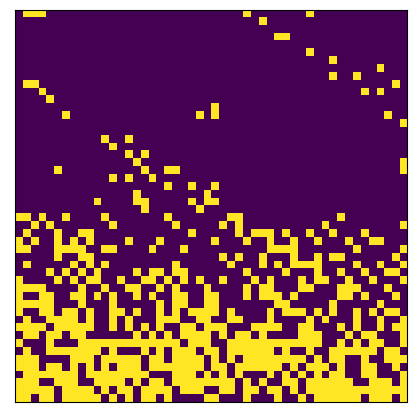

In [241]:
# Visualizing Maps
mask_map =mask_B2.reshape(gridSize,gridSize)  
fig=plt.figure(figsize=(4.0,4.0))
plt.imshow(mask_map,origin='upper')
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
fig.tight_layout(pad=0.1)

# Observations
# A1 - ECM-Regime 1
# A2 - Domain wall effects
# A3 - Domain 2 (blue)
# A4 - Domain 1 (red)
# B1 - Topography
# B2 - ECM Regime 4
# B3 - ECM Regime 3
# B4 - ECM Regime 2
# B5 - ECM Regime 1

### Defining overlapping region for additional analyses (K-Means vs averaging)

In [242]:
# Observations
# A1 - ECM-Regime 1
# A2 - Domain wall effects
# A3 - Domain 2 (blue)
# A4 - Domain 1 (red)
# B1 - Topography
# B2 - ECM Regime 4
# B3 - ECM Regime 3
# B4 - ECM Regime 2
# B5 - ECM Regime 1

# Conversion to sets
set_A1=set(np.where(mask_A1==True)[0])
set_A2=set(np.where(mask_A2==True)[0])
set_A3=set(np.where(mask_A3==True)[0])
set_A4=set(np.where(mask_A4==True)[0])
set_B1=set(np.where(mask_B1==True)[0])
set_B2=set(np.where(mask_B2==True)[0])
set_B3=set(np.where(mask_B3==True)[0])
set_B4=set(np.where(mask_B4==True)[0])
set_B5=set(np.where(mask_B5==True)[0])


###### For Future Analyses #######

# Custom sets - Domain 1, no domain walls, no topography, ECM-2
k_dom1_ecm1_no_dw_top=list(set_A4.difference(set_A2).difference(set_B1).difference(set_B2).difference(set_B3).difference(set_B5))

# Custom sets - Domain 2, no domain walls, no topography, ECM-2
k_dom2_ecm1_no_dw_top=list(set_A3.difference(set_A2).difference(set_B1).difference(set_B2).difference(set_B3).difference(set_B5))

# Custom sets - Domain 1, no domain walls, no topography, ECM-3
k_dom1_ecm2_no_dw_top=list(set_A4.difference(set_A2).difference(set_B1).difference(set_B2).difference(set_B4).difference(set_B5))

# Custom sets - Domain 2, no domain walls, no topography, ECM-3
k_dom2_ecm2_no_dw_top=list(set_A3.difference(set_A2).difference(set_B1).difference(set_B2).difference(set_B4).difference(set_B5))

# Custom sets - Domain 1, no domain walls, no topography, ECM-4
k_dom1_ecm3_no_dw_top=list(set_A4.difference(set_A2).difference(set_B1).difference(set_B3).difference(set_B4).difference(set_B5))

# Custom sets - Domain 2, no domain walls, no topography, ECM-4
k_dom2_ecm3_no_dw_top=list(set_A3.difference(set_A2).difference(set_B1).difference(set_B3).difference(set_B4).difference(set_B5))

cluster = 13


dom_walls=convert_rgb_to_names((229,204,255))
dom_bulk=convert_rgb_to_names((76,0,153))


#For plotting purposes
if cluster == 1:
    k = k1
    c1='yellow'
    c2='blue'
elif cluster == 2:
    k = k2
    c1='yellow'
    c2='blue'
elif cluster == 3:
    k = k3
    c1='yellow'
    c2='blue'
elif cluster == 4:
    k = k4
    c1='yellow'
    c2='blue'
elif cluster == 5:
    k = k5
    c1='yellow'
    c2='blue'
elif cluster == 6:
    k = k6
    c1='yellow'
    c2='blue'
elif cluster == 7:
    k = k7
    c1='yellow'
    c2='blue'
elif cluster == 8:
    k = k8
    c1='yellow'
    c2='blue'
elif cluster == 9:
    k = k_outliers
    c1='yellow'
    c2='blue'
elif cluster == 10:
    # Colors for A map
    c1=dom2_b
    c2=dom1_b 
elif cluster == 11:
    # Colors for B map
    c1='lightgray'
    c2='black'   
elif cluster == 12:
    # Colors for C map
    c1=dom_bulk
    c2=dom_walls   
elif cluster == 13:
    # Colors for D map
    #c3='black'
    #c1=dom_es_top
    #c2=dom0_es
    c1 = 'white'
    c2 = 'black'
      
cmap = matplotlib.colors.ListedColormap([c1, c2])


# Make a duplicate of Kmeans and update the labels accordingly
# Then for full plot inclucde 2nd row with ave Q response (keep the mean offsets)
# mask = np.full((gridSize**2),False)
# mask[k_dom2_ecm3_no_dw_top]=True
# mask_map =mask.reshape(gridSize,gridSize)  
# fig=plt.figure(figsize=(4.0,4.0))
# plt.imshow(mask_map,origin='upper',cmap=cmap)
# plt.gca().axes.get_yaxis().set_visible(False)
# plt.gca().axes.get_xaxis().set_visible(False)
# fig.tight_layout(pad=0.1)

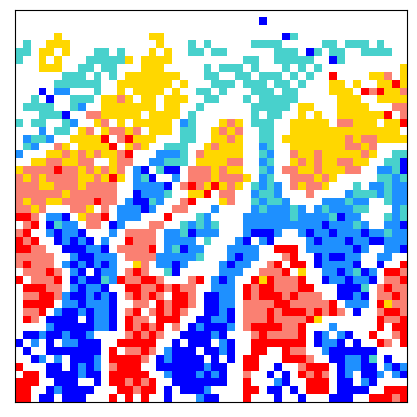

In [243]:

############## Colors ############################
###################################################

# Rest
c_rest = 'white'
# ECM 1
c_ecm1_dom1 = 'gold'
c_ecm1_dom2 = 'mediumturquoise'
# ECM 2
c_ecm2_dom1 = 'salmon'
c_ecm2_dom2 = 'dodgerblue'

# ECM 3
c_ecm3_dom1 = 'red'
c_ecm3_dom2 = 'blue'

colors = [c_rest, \
          c_ecm1_dom1, c_ecm2_dom1, c_ecm3_dom1, \
          c_ecm1_dom2, c_ecm2_dom2, c_ecm3_dom2]

# 
k1=k_dom1_ecm1_no_dw_top
k2=k_dom1_ecm2_no_dw_top
k3=k_dom1_ecm3_no_dw_top
k4=k_dom2_ecm1_no_dw_top
k5=k_dom2_ecm2_no_dw_top
k6=k_dom2_ecm3_no_dw_top

# Assigning index to clusters in order of appearance/colors

cluster_map = np.zeros(gridSize**2).astype(int)


cluster_map[k1] = 1
cluster_map[k2] = 2
cluster_map[k3] = 3
cluster_map[k4] = 4
cluster_map[k5] = 5
cluster_map[k6] = 6    

cmap = matplotlib.colors.ListedColormap(colors)

fig=plt.figure(figsize=(4.0,4.0))
plt.imshow(cluster_map.reshape((gridSize,gridSize)),origin='upper',cmap=cmap)
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
fig.tight_layout(pad=0.1)



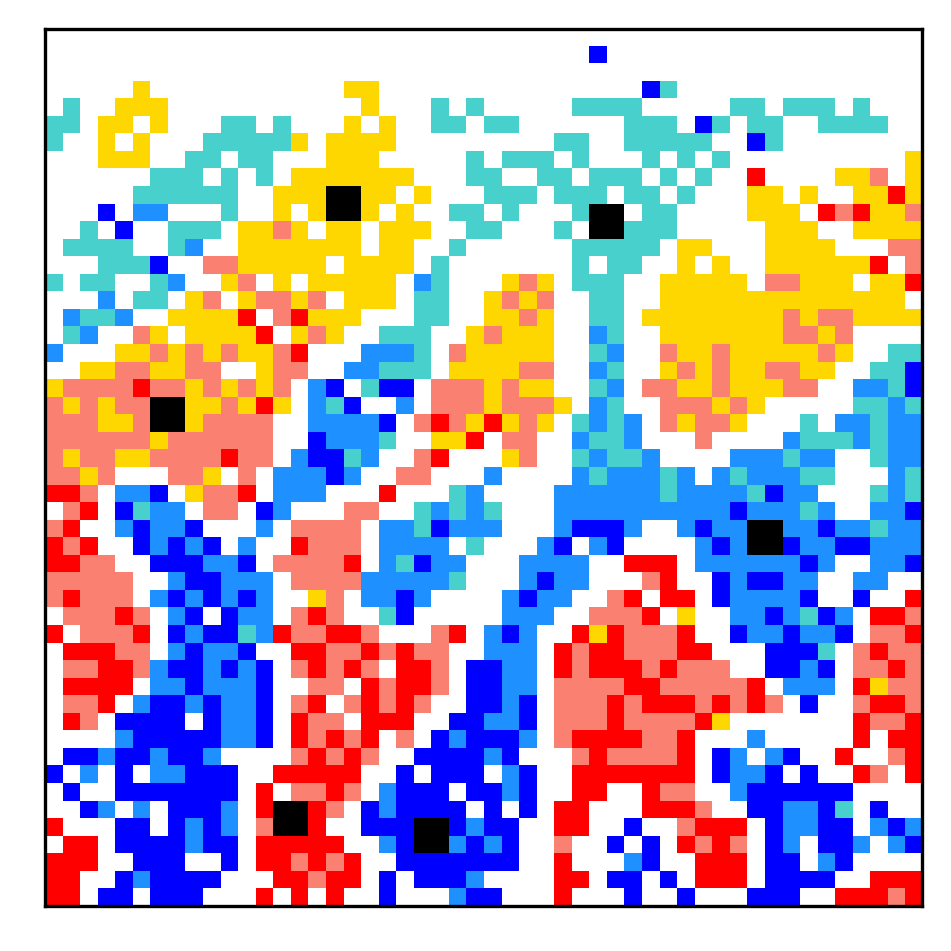

In [245]:
# Selecting locations in each regime for further statistical analyses
# We ignore domain walls and topography
# We will ignore ECM1 as domain walls are not as well defined
p1 = 466
p2 = 531
p3 = 1056
p4 = 1440
p5 = 2213
p6 = 2271

k_dom1_ecm1 = [p1, p1+1, p1+50, p1+51]
k_dom2_ecm1 = [p2, p2+1, p2+50, p2+51]
k_dom1_ecm2 = [p3, p3+1, p3+50, p3+51]
k_dom2_ecm2 = [p4, p4+1, p4+50, p4+51]
k_dom1_ecm3 = [p5, p5+1, p5+50, p5+51]
k_dom2_ecm3 = [p6, p6+1, p6+50, p6+51]

k_study = np.concatenate((k_dom1_ecm1,k_dom2_ecm1,k_dom1_ecm2,k_dom2_ecm2,k_dom1_ecm3,k_dom2_ecm3))

c_study = 'black'

colors = [c_rest, \
          c_ecm1_dom1, c_ecm2_dom1, c_ecm3_dom1, \
          c_ecm1_dom2, c_ecm2_dom2, c_ecm3_dom2, c_study]

cluster_map[k_study] = 7
    
cmap = matplotlib.colors.ListedColormap(colors)

fig=plt.figure(figsize=(3.0,3.0),dpi=300)
plt.imshow(cluster_map.reshape((gridSize,gridSize)),origin='upper',cmap=cmap)
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
fig.tight_layout(pad=0.1)


In [246]:

# Scatter Function showing all data including filled values
def plot_parameters_v2(df,pnts,c,var):   
    if var == "Amp":
        y1=df[var][0].iloc[pnts].median(axis=0).values/1e3 # cycle 1
        y2=df[var][1].iloc[pnts].median(axis=0).values/1e3 # cycle 2
        y3=df[var][2].iloc[pnts].median(axis=0).values/1e3 # cycle 2
        
        x=df[var][0].columns.get_level_values('xaxis').astype(float)
    else: 
        y1=df[var][0].iloc[pnts].median(axis=0).values # cycle 1
        y2=df[var][1].iloc[pnts].median(axis=0).values # cycle 2
        y3=df[var][2].iloc[pnts].median(axis=0).values # cycle 2
        
        x=df[var][0].columns.get_level_values('xaxis').astype(float)
        
    plt.plot(x,y1,color=c,linestyle='-', linewidth=1.0, markersize=0.7,label='cycle 1')
    plt.plot(x,y2,color=c,linestyle='-', linewidth=1.0, markersize=0.7,label='cycle 2')
    plt.plot(x,y3,color=c,linestyle='-', linewidth=1.0, markersize=0.7,label='cycle 3')
    return 

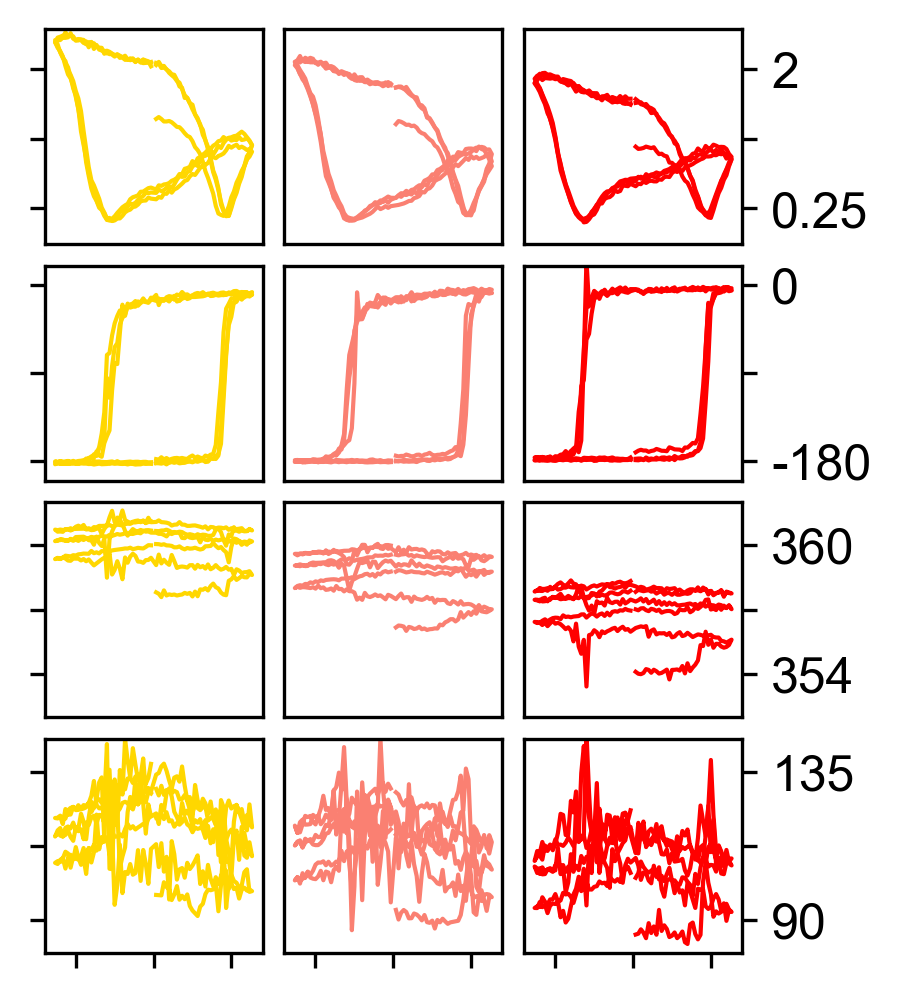

In [249]:
# Generating the average response for each cluster across all four parameters
# Defining points for median plotting
k1=k_dom1_ecm1 
k4=k_dom2_ecm1 
k2=k_dom1_ecm2
k5=k_dom2_ecm2 
k3=k_dom1_ecm3
k6=k_dom2_ecm3

# Figures for final Clusters

fontsize=10
plt.rcParams['font.size'] = fontsize

# 1st Row - Off-F PR where each cell has 2 curves corresponding to up/down domains
data=out_fill
x=data['Amp'].columns.get_level_values('xaxis').astype(float)

c = [c_ecm1_dom1,c_ecm2_dom1,c_ecm3_dom1] 

var_list = ['Amp','Phase','Res','Q']

gs= gridspec.GridSpec(4,3,wspace=0.10,hspace=0.10)

fig= plt.figure(figsize=(3,4),dpi=300)

# Limits
Amin, Amax = [-0.2,2.5]
Phmin, Phmax = [-200, 20]
Wmin,Wmax = [352, 362]
Qmin, Qmax = [80, 145]

for var,i in zip(var_list,np.arange(0,4)):
    
    # 1st column
    ax=fig.add_subplot(gs[i,0])
    if var == 'Amp':
        plot_parameters_v2(data,k1,c[0],var)
        ax.set_ylim([Amin,Amax])
        ax.xaxis.set_ticks([])
        ax.set_yticks([0.25,1.125, 2])
        
    elif var == 'Phase':
        plot_parameters_v2(data,k1,c[0],var)
        ax.set_ylim([Phmin,Phmax])
        ax.xaxis.set_ticks([])
        ax.set_yticks([-180,-90,0])
        
    elif var == 'Res':
        plot_parameters_v2(data,k1,c[0],var)
        ax.set_ylim([Wmin,Wmax])
        ax.xaxis.set_ticks([])
        ax.set_yticks([354,357,360])
        
    else:
        plot_parameters_v2(data,k1,c[0],var)
        ax.set_ylim([Qmin,Qmax])
        ax.set_yticks([90,112.5,135])
        #ax.set_xlabel('Bias (V)')   
        
    ax.set_xlim([-14,14])    
    ax.yaxis.tick_left()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # 2nd column
    ax=fig.add_subplot(gs[i,1])
    if var == 'Amp':
        plot_parameters_v2(data,k2,c[1],var)
        ax.set_ylim([Amin,Amax])
        ax.xaxis.set_ticks([])
    elif var == 'Phase':
        plot_parameters_v2(data,k2,c[1],var)
        ax.set_ylim([Phmin,Phmax])
        ax.xaxis.set_ticks([])
    elif var == 'Res':
        plot_parameters_v2(data,k2,c[1],var)
        ax.set_ylim([Wmin,Wmax])
        ax.xaxis.set_ticks([])
    else:
        plot_parameters_v2(data,k2,c[1],var)
        ax.set_ylim([Qmin,Qmax])
        #ax.set_xlabel('Bias (V)')   

    ax.set_xlim([-14,14])    
    ax.yaxis.set_ticks([])
    ax.set_xticklabels([])
    
    # 3rd column
    ax=fig.add_subplot(gs[i,2])
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    if var == 'Amp':
        plot_parameters_v2(data,k3,c[2],var)
        ax.set_ylim([Amin,Amax])
        ax.xaxis.set_ticks([])
        ax.set_yticks([0.25,1.125, 2])
        ax.set_yticklabels([0.25,'', 2])
        #ax.set_ylabel('A (mV)')
    elif var == 'Phase':
        plot_parameters_v2(data,k3,c[2],var)
        ax.set_ylim([Phmin,Phmax])
        ax.xaxis.set_ticks([])
        ax.set_yticks([-180,-90,0])
        ax.set_yticklabels([-180,'',0])
        #ax.set_ylabel('$\Theta(\circ)$')
    elif var == 'Res':
        plot_parameters_v2(data,k3,c[2],var)
        ax.set_ylim([Wmin,Wmax])
        ax.xaxis.set_ticks([])
        ax.set_yticks([354,357,360])
        ax.set_yticklabels([354,'',360])
        #ax.set_ylabel('$\omega$(kHz)')
    else:
        plot_parameters_v2(data,k3,c[2],var)
        ax.set_ylim([Qmin,Qmax])
        ax.set_yticks([90,112.5,135])
        ax.set_yticklabels([90,'',135])
        #ax.set_xlabel('Bias (V)') 
        #ax.set_ylabel('Q')
    ax.set_xlim([-14,14]) 
    ax.set_xticklabels([])
    
    ax.tick_params(axis='both', which='major', labelsize=12)
      
    #plt.tight_layout()

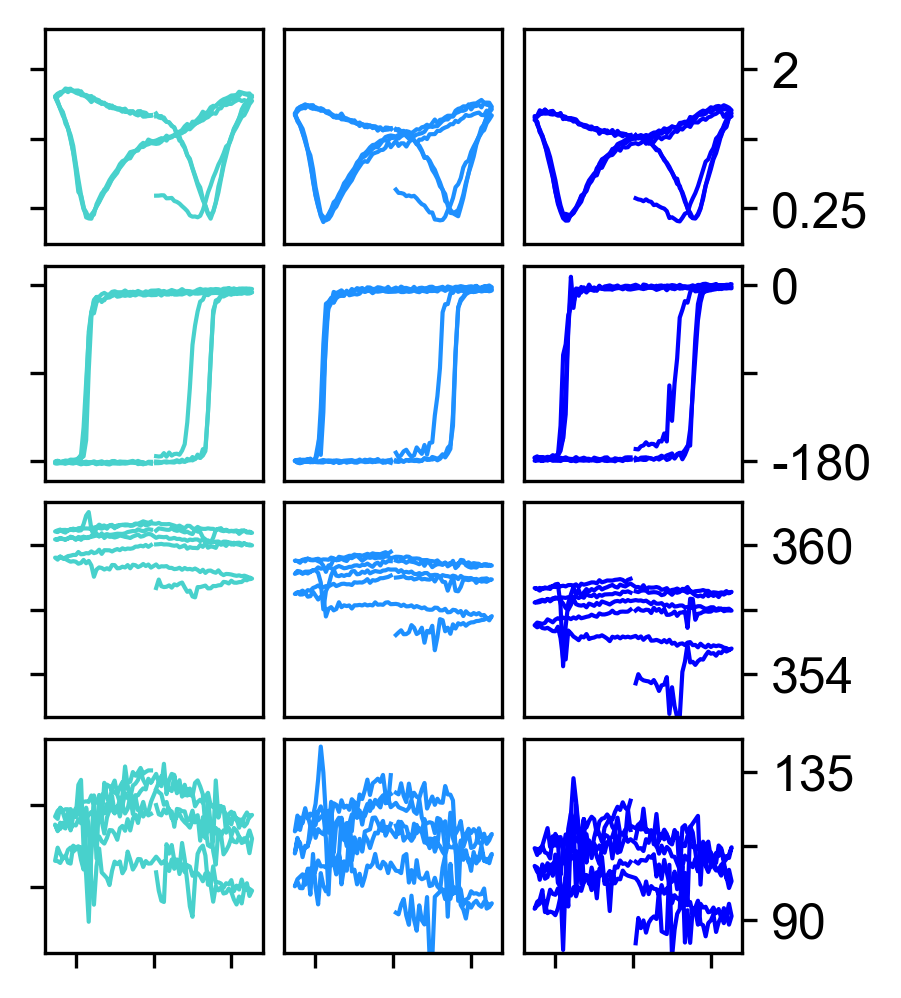

In [267]:
# Generating the average response for each cluster across all four parameters

# Figures for final Clusters

fontsize=10
plt.rcParams['font.size'] = fontsize

# 1st Row - Off-F PR where each cell has 2 curves corresponding to up/down domains
data=out_fill
x=data['Amp'].columns.get_level_values('xaxis').astype(float)

c = [c_ecm1_dom2,c_ecm2_dom2,c_ecm3_dom2] 

var_list = ['Amp','Phase','Res','Q']

gs= gridspec.GridSpec(4,3,wspace=0.10,hspace=0.10)

fig= plt.figure(figsize=(3,4),dpi=300)

# Limits
Amin, Amax = [-0.2,2.5]
Phmin, Phmax = [-200, 20]
Wmin,Wmax = [352, 362]
Qmin, Qmax = [80, 145]

for var,i in zip(var_list,np.arange(0,4)):
    
    # 1st column
    ax=fig.add_subplot(gs[i,0])
    if var == 'Amp':
        plot_parameters_v2(data,k4,c[0],var)
        ax.set_ylim([Amin,Amax])
        ax.xaxis.set_ticks([])
        ax.set_yticks([0.25,1.125, 2])
    elif var == 'Phase':
        plot_parameters_v2(data,k4,c[0],var)
        ax.set_ylim([Phmin,Phmax])
        ax.xaxis.set_ticks([])
        ax.set_yticks([-180,-90,0])
    elif var == 'Res':
        plot_parameters_v2(data,k4,c[0],var)
        ax.set_ylim([Wmin,Wmax])
        ax.xaxis.set_ticks([])
        ax.set_yticks([354,357,360])
    else:
        plot_parameters_v2(data,k4,c[0],var)
        ax.set_ylim([Qmin,Qmax])
        #ax.set_xlabel('Bias (V)')   
        
    ax.set_xlim([-14,14])    
    ax.set_xticklabels([])
    ax.yaxis.tick_left()
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # 2nd column
    ax=fig.add_subplot(gs[i,1])
    if var == 'Amp':
        plot_parameters_v2(data,k5,c[1],var)
        ax.set_ylim([Amin,Amax])
        ax.xaxis.set_ticks([])
    elif var == 'Phase':
        plot_parameters_v2(data,k5,c[1],var)
        ax.set_ylim([Phmin,Phmax])
        ax.xaxis.set_ticks([])
    elif var == 'Res':
        plot_parameters_v2(data,k5,c[1],var)
        ax.set_ylim([Wmin,Wmax])
        ax.xaxis.set_ticks([])
        ax.set_yticks([354,357,360])
    else:
        plot_parameters_v2(data,k5,c[1],var)
        ax.set_ylim([Qmin,Qmax])
        ax.set_yticks([90,112.5,135])
        #ax.set_xlabel('Bias (V)')   

    ax.set_xlim([-14,14])    
    ax.yaxis.set_ticks([])
    ax.set_xticklabels([])
    
    # 3rd column
    ax=fig.add_subplot(gs[i,2])
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    if var == 'Amp':
        plot_parameters_v2(data,k6,c[2],var)
        ax.set_ylim([Amin,Amax])
        ax.xaxis.set_ticks([])
        ax.set_yticks([0.25,1.125, 2])
        ax.set_yticklabels([0.25,'', 2])
        #ax.set_ylabel('A (mV)')
    elif var == 'Phase':
        plot_parameters_v2(data,k6,c[2],var)
        ax.set_ylim([Phmin,Phmax])
        ax.xaxis.set_ticks([])
        ax.set_yticks([-180,-90,0])
        ax.set_yticklabels([-180,'',0])
        #ax.set_ylabel('$\Theta(\circ)$')
    elif var == 'Res':
        plot_parameters_v2(data,k6,c[2],var)
        ax.set_ylim([Wmin,Wmax])
        ax.xaxis.set_ticks([])
        ax.set_yticks([354,357,360])
        ax.set_yticklabels([354,'',360])
        #ax.set_ylabel('$\omega$(kHz)')
    else:
        plot_parameters_v2(data,k6,c[2],var)
        ax.set_ylim([Qmin,Qmax])
        ax.set_yticks([90,112.5,135])
        ax.set_yticklabels([90,'',135])
        #ax.set_xlabel('Bias (V)') 
        #ax.set_ylabel('Q')
    ax.set_xlim([-14,14]) 
    ax.set_xticklabels([])
    
    ax.tick_params(axis='both', which='major', labelsize=12)
    #plt.tight_layout()

## Figure 7

#### Attempt 1

<Figure size 1500x1000 with 0 Axes>

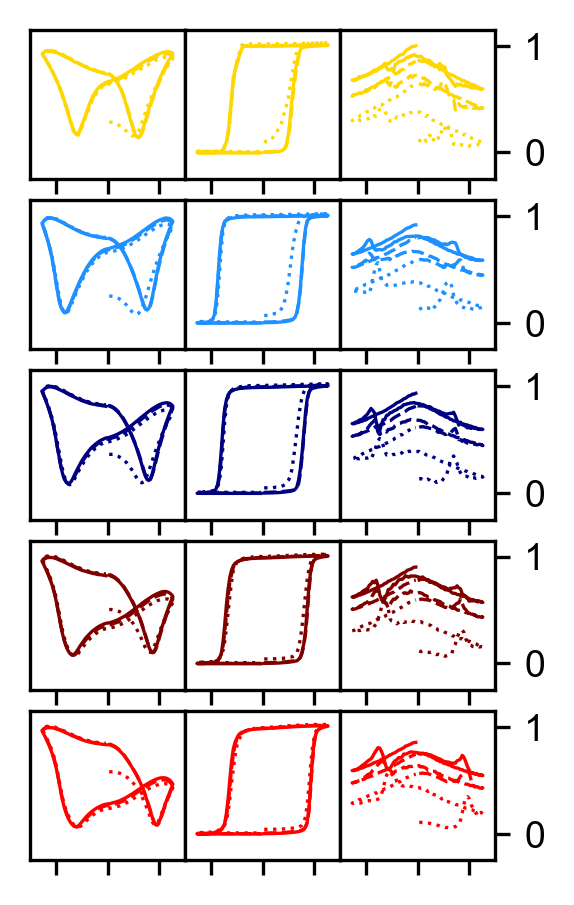

In [283]:
# Colors
c1='blue'
c2='red'
c3='green'
c4='gold'
c5='purple'
c6='navy'
c7='darkgreen'
c8='navajowhite'
c9='black'
c10='blueviolet'
c11='darkslateblue'
c12='orange'
c13='tomato'
c14='paleturquoise'
c15='saddlebrown'
cnone = 'white'

# First, we grab the indices corresponding to this regime
#k = k_dom2_ecm3_no_dw_top

# Variables
var1 = 'Amp'
var2 = 'Phase'
var3 = 'Res'
var4 = 'Q'
num_var = 3

# Dataframe of interest
df = out_norm_local

# Next we form the stack
A_Ph_Res_Q_stk=pd.concat(dict(P1_c1=df[var1][0], P1_c2=df[var1][1],P1_c3=df[var1][2],
                              P2_c1=df[var2][0], P2_c2=df[var2][1],P2_c3=df[var2][2],
                              P3_c1=df[var3][0], P3_c2=df[var3][1],P3_c3=df[var3][2],
                              P4_c1=df[var4][0], P4_c2=df[var4][1],P4_c3=df[var4][2]),axis=1)

A_Ph_Q_stk=pd.concat(dict(P1_c1=df[var1][0], P1_c2=df[var1][1],P1_c3=df[var1][2],
                              P2_c1=df[var2][0], P2_c2=df[var2][1],P2_c3=df[var2][2],
                              P3_c1=df[var4][0], P3_c2=df[var4][1],P3_c3=df[var4][2]),axis=1)


Q_stk = pd.concat(dict(P1_c1=df[var4][0], P1_c2=df[var4][1],P1_c3=df[var4][2]),axis=1)
Res_stk = pd.concat(dict(P1_c1=df[var3][0], P1_c2=df[var3][1],P1_c3=df[var3][2]),axis=1)

# Next we perform k-Means on the desired stack
stack = A_Ph_Q_stk

# Select number of clusters desired
n=5

# Perform clustering
kmeans = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
kmeans.fit(stack)
kmeans_comps=pd.DataFrame(kmeans.cluster_centers_,columns=stack.columns)
df = kmeans_comps

# Plotting the response
if n ==2:
    fig= plt.figure(figsize=(15,10))
    c = [c1,c2]
elif n ==3:
    #fig= plt.figure(figsize=(15,10))
    c = ['dodgerblue','red','black']   # colors for dimensionally stacked case
    reorder=[0,2,1]
elif n ==4:
    fig= plt.figure(figsize=(15,10))
    c = ['dodgerblue','gold','red','black']
elif n ==5:
    fig= plt.figure(figsize=(15,10))
    c = ['red','dodgerblue','maroon','gold','navy']
elif n ==6:
    fig= plt.figure(figsize=(15,10))
    c = [c1,c2,c3,c4,c5,c6,cnone]    
    
reorder = [3,1,4,2,0]

# Assign colors to cmap

cmap = matplotlib.colors.ListedColormap(c)

# Grid spec parameters
height_ratios=[5,]

for i in range(n):
    height_ratios.append(1.5)

# Create grid for parameter responses
#gs= gridspec.GridSpec(num_var,n+1, height_ratios=5*np.ones(num_var), width_ratios=width_ratios, top=1, bottom=0,wspace=0.0,hspace=0.0)

gs= gridspec.GridSpec(n+1,num_var, height_ratios=height_ratios, width_ratios=np.ones(num_var), top=1, bottom=0,wspace=0.0,hspace=0.10)

fig= plt.figure(figsize=(2.0,4.5),dpi=300)

# Font size
fontsize =12

# First parameter - Amplitude
for i,j in zip(reorder,range(n)):
    color=c[i]
    #print(color,i)
    ax=fig.add_subplot(gs[j+1,0])
    im=plot_parameters(df,i,c=color,param="P1")
    #ax.annotate(r'$k_{'+str(i+1)+'}$',(0.05,0.90),xycoords='axes fraction',fontsize=fontsize)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    #plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    #plt.axhline(y=1, color='gray', linestyle='--',linewidth=0.4)
    #ax.set_ylim([-0.25, 1.15])
    ax.set_xlim([-15, 15])
    ax.set_ylim([-0.25, 1.15])
    #plt.gca().axes.get_yaxis().set_visible(False)
 
    ax.set_xticks([-10, 0, 10])
    ax.set_xticklabels([])
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.set_yticklabels([])
    #ax.set_yticks([0,1])
    #if j == 0:
    #    ax.set_title('A',fontsize=fontsize)
    if i+1 == n:
        #plt.ylabel('A',fontsize=fontsize)
        plt.gca().axes.get_yaxis().set_visible(True)
        
# Second parameter - Phase
for i,j in zip(reorder,range(n)):
    color=c[i]
    #print(color,i)
    ax=fig.add_subplot(gs[j+1,1])
    im=plot_parameters(df,i,c=color,param="P2")
    #ax.annotate(r'$k_{'+str(i+1)+'}$',(0.05,0.85),xycoords='axes fraction',fontsize=12)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    #plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    #plt.axhline(y=1, color='gray', linestyle='--',linewidth=0.4)
    ax.set_ylim([-0.25, 1.15])
    ax.set_xlim([-15, 15])
    #plt.gca().axes.get_yaxis().set_visible(False)
    #ax.set_yticks([0,1])
    ax.set_xticks([-10, 0, 10])
    ax.set_xticklabels([])
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.set_yticklabels([])
    #if j == 0:
   #     ax.set_title('$\Theta$',fontsize=fontsize)

    if i+1 == n:
        #plt.ylabel('$\Theta$',fontsize=fontsize)
        plt.gca().axes.get_yaxis().set_visible(True)        

# Third parameter - Resonance
for i,j in zip(reorder,range(n)):
    color=c[i]
    #print(color,i)
    ax=fig.add_subplot(gs[j+1,2])
    im=plot_parameters(df,i,c=color,param="P3")
    #ax.annotate(r'$k_{'+str(i+1)+'}$',(0.05,0.85),xycoords='axes fraction',fontsize=12)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    #plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    #plt.axhline(y=1, color='gray', linestyle='--',linewidth=0.4)
    ax.set_ylim([-0.25, 1.15])
    ax.set_xlim([-15, 15])
    
    # plt.gca().axes.get_yaxis().set_visible(False)

    ax.set_xticks([-10, 0, 10])
    ax.set_xticklabels([])
    ax.tick_params(axis='both', which='major', labelsize=9)
   # if j == 0:
   #     ax.set_title('$\omega$',fontsize=fontsize)

    if i+1 == n:
        #plt.ylabel('$\omega$',fontsize=fontsize)
        plt.gca().axes.get_yaxis().set_visible(True)
        
#Fourth parameter - Quality factor
# for i,j in zip(reorder,range(n)):
#     color=c[i]
#     #print(color,i)
#     ax=fig.add_subplot(gs[j+1,3])
#     im=plot_parameters(df,i,c=color,param="P4")
#     #ax.annotate(r'$k_{'+str(i+1)+'}$',(0.05,0.85),xycoords='axes fraction',fontsize=12)
#     ax.yaxis.set_label_position("right")
#     ax.yaxis.set_ticks_position("right")
#     #plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
#     #plt.axhline(y=1, color='gray', linestyle='--',linewidth=0.4)
#     ax.set_ylim([-0.25, 1.15])
#     ax.set_xlim([-15, 15])
#     plt.gca().axes.get_yaxis().set_visible(True)
#     ax.set_yticks([0,1])
#     ax.set_xticks([-10, 0, 10])
#     ax.set_xticklabels([])
#     ax.tick_params(axis='both', which='major', labelsize=12)
#     #if j == 0:
#     #    ax.set_title('Q',fontsize=fontsize)
        
#     if i+1 == n:
#         #plt.ylabel('Q',fontsize=fontsize)
#         plt.gca().axes.get_yaxis().set_visible(True)
        
plt.show();       

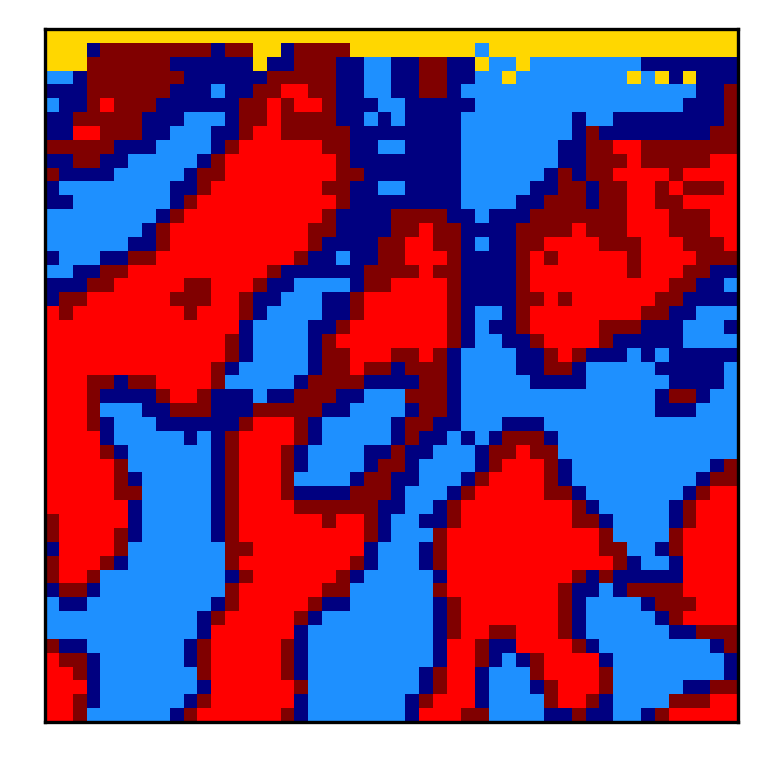

In [271]:
        
cscale = matplotlib.colors.ListedColormap(c)
#Plot the Label Map
fig= plt.figure(figsize=(3,3),dpi=300)
ax = fig.add_subplot()
# comp_map = np.zeros((gridSize**2),dtype=int)
# comp_map[:]=n
# comp_map[k] = kmeans.labels_
im = kmeans.labels_.reshape(gridSize,gridSize)
plt.imshow(im, cmap=cscale,origin='upper')
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()



In [ ]:
# Colors
c1='blue'
c2='red'
c3='green'
c4='gold'
c5='purple'
c6='navy'
c7='darkgreen'
c8='navajowhite'
c9='black'
c10='blueviolet'
c11='darkslateblue'
c12='orange'
c13='tomato'
c14='paleturquoise'
c15='saddlebrown'
cnone = 'white'

# First, we grab the indices corresponding to this regime
#k = k_dom2_ecm3_no_dw_top

# Variables
var1 = 'Amp'
var2 = 'Phase'
var3 = 'Res'
var4 = 'Q'
num_var = 4

# Dataframe of interest
df = out_fill.copy()

# Conversion to base SI units
df['Amp']=df['Amp']*1e-6
df['Res']=df['Res']*1e3

# Next we form the stack
A_Ph_Res_Q_stk=pd.concat(dict(P1_c1=df[var1][0], P1_c2=df[var1][1],P1_c3=df[var1][2],
                              P2_c1=df[var2][0], P2_c2=df[var2][1],P2_c3=df[var2][2],
                              P3_c1=df[var3][0], P3_c2=df[var3][1],P3_c3=df[var3][2],
                              P4_c1=df[var4][0], P4_c2=df[var4][1],P4_c3=df[var4][2]),axis=1)

# Next we perform k-Means on the desired stack
stack = A_Ph_Res_Q_stk

# Select number of clusters desired
n=5

# Perform clustering
kmeans = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
kmeans.fit(stack)
kmeans_comps=pd.DataFrame(kmeans.cluster_centers_,columns=stack.columns)
df = kmeans_comps

# Plotting the response
if n ==2:
    fig= plt.figure(figsize=(15,10))
    c = [c1,c2]
elif n ==3:
    fig= plt.figure(figsize=(15,10))
    c = ['dodgerblue','red','black']   # colors for dimensionally stacked case
elif n ==4:
    fig= plt.figure(figsize=(15,10))
    c = ['dodgerblue','gold','red','black']
elif n ==5:
    fig= plt.figure(figsize=(15,10))
    #c = ['red','dodgerblue','gold','black','green'] # Colors for instrument SI units
    c = ['green','dodgerblue','gold','red','black'] # Colors for base SI units
elif n ==6:
    fig= plt.figure(figsize=(15,10))
    c = [c1,c2,c3,c4,c5,c6,cnone]    
    
reorder = range(n)

# Assign colors to cmap

cmap = matplotlib.colors.ListedColormap(c)

# Create grid for parameter responses
#gs= gridspec.GridSpec(num_var,n+1, height_ratios=5*np.ones(num_var), width_ratios=width_ratios, top=1, bottom=0,wspace=0.0,hspace=0.0)

gs= gridspec.GridSpec(num_var,n+1, top=1, bottom=0,wspace=0.1,hspace=0.0)

fig= plt.figure(figsize=(5.5,2.5))

# Font size
fontsize =12

# Limits - for instrument units
# Amin, Amax = [-0.2*1e3,2.5*1e3]
# Phmin, Phmax = [40, 280]
# Wmin,Wmax = [352, 362]
# Qmin, Qmax = [80, 145]

# Limits - for base units
Amin, Amax = [-0.2*1e-3,2.5*1e-3]
Phmin, Phmax = [40, 280]
Wmin,Wmax = [352*1e3, 362*1e3]
Qmin, Qmax = [80, 145]


# First parameter - Amplitude
for i,j in zip(reorder,range(n)):
    color=c[i]
   
    ax=fig.add_subplot(gs[0,j])
    im=plot_parameters(df,i,c=color,param="P1")
    
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    
    ax.set_xlim([-15, 15])
    ax.set_ylim([Amin,Amax])
    # Instrument Units
    #ax.set_yticks([0.25*1e3,1.125*1e3, 2*1e3])
    #ax.set_yticklabels([250,'', 2000])
    
    # Base SI Units
    ax.set_yticks([0.25*1e-3,1.125*1e-3, 2*1e-3])
    ax.set_yticklabels([0.25e-3,'', 2e-3])
    
    plt.gca().axes.get_yaxis().set_visible(False)
    ax.set_xticks([-10, 0, 10])
    ax.set_xticklabels([])
    
    if j+1 == n:
        plt.gca().axes.get_yaxis().set_visible(True)
        
    #ax.set_yticks([0,1])
    #if j == 0:
    #    ax.set_title('A',fontsize=fontsize)

        
# Second parameter - Phase
for i,j in zip(reorder,range(n)):
    color=c[i]
    
    ax=fig.add_subplot(gs[1,j])
    im=plot_parameters(df,i,c=color,param="P2")
    
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    
    ax.set_xlim([-15, 15])
    ax.set_ylim([Phmin,Phmax])
    ax.set_yticks([70,160,250])
    ax.set_yticklabels([70,'',250])
    
    plt.gca().axes.get_yaxis().set_visible(False)
  
    ax.set_xticks([-10, 0, 10])
    ax.set_xticklabels([])
    
    if j+1 == n:
        plt.gca().axes.get_yaxis().set_visible(True)
    
# Third parameter - Resonance
for i,j in zip(reorder,range(n)):
    color=c[i]
    
    ax=fig.add_subplot(gs[2,j])
    im=plot_parameters(df,i,c=color,param="P3")
    
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    
    ax.set_xlim([-15, 15])
    ax.set_ylim([Wmin,Wmax])
    plt.gca().axes.get_yaxis().set_visible(False)
    
    # Instrument SI units
    #ax.set_yticks([354,357,360])
    #ax.set_yticklabels([354,'',360])
        
    # Base SI Units
    ax.set_yticks([354*1e3,357*1e3,360*1e3])
    ax.set_yticklabels([354000,'',360000])
    
    ax.set_xticks([-10, 0, 10])
    ax.set_xticklabels([])

    if j+1 == n:
        plt.gca().axes.get_yaxis().set_visible(True)
        
  
        
# Fourth parameter - Quality factor
for i,j in zip(reorder,range(n)):
    color=c[i]
    
    ax=fig.add_subplot(gs[3,j])
    im=plot_parameters(df,i,c=color,param="P4")
    
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    
    ax.set_xlim([-15, 15])
    ax.set_ylim([Qmin,Qmax])
    ax.set_yticks([90,112.5,135])
    ax.set_yticklabels([90,'',135])
    
    plt.gca().axes.get_yaxis().set_visible(False)
    
    ax.set_xticks([-10, 0, 10])
    ax.set_xticklabels([])

         
    if j+1 == n:
        plt.gca().axes.get_yaxis().set_visible(True);
        
plt.show();       

In [ ]:
        
cscale = matplotlib.colors.ListedColormap(c)
#Plot the Label Map
fig= plt.figure(figsize=(5,5))
ax = fig.add_subplot()
# comp_map = np.zeros((gridSize**2),dtype=int)
# comp_map[:]=n
# comp_map[k] = kmeans.labels_
im = kmeans.labels_.reshape(gridSize,gridSize)
plt.imshow(im, cmap=cscale,origin='upper')
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()



#### Average responses of parameters

In [ ]:
# Colors
c1='blue'
c2='red'
c3='green'
c4='gold'
c5='purple'
c6='navy'
c7='darkgreen'
c8='navajowhite'
c9='black'
c10='blueviolet'
c11='darkslateblue'
c12='orange'
c13='tomato'
c14='paleturquoise'
c15='saddlebrown'
cnone = 'white'

# First, we grab the indices corresponding to this regime
k = k_dom2_ecm2_no_dw_top

# Variables
var1 = 'Amp'
var2 = 'Phase'
var3 = 'Res'
var4 = 'Q'
num_var = 4

# Dataframe of interest
df = out_fill_new

x=df[var1].columns.get_level_values('xaxis').astype(float)
###
c = [dom1_b,'maroon',dom2_es,dom1_es,'navy',dom3_es,'dimgray','lightgray'] 

c = ['black','black','black','black'] 


A_resp = df[var1].iloc[k].mean(axis=0).values
Ph_resp = df[var2].iloc[k].mean(axis=0).values
Res_resp = df[var3].iloc[k].mean(axis=0).values
Q_resp = df[var4].iloc[k].mean(axis=0).values

gs= gridspec.GridSpec(1,4,wspace=0.85)
fig= plt.figure(figsize=(14,3))

ax=fig.add_subplot(gs[0,0])
ax.plot(x,A_resp,color=c[0],linestyle='-', markersize=1.5)
ax.set_title('Amplitude'+units['Amp'])
ax.set_ylim([0 ,2300])
ax=fig.add_subplot(gs[0,1])
ax.plot(x,Ph_resp,color=c[1],linestyle='-', markersize=1.5)
ax.set_title('Phase'+units['Phase'])
ax.set_ylim([-30 ,210])
ax=fig.add_subplot(gs[0,2])
ax.plot(x,Res_resp,color=c[2],linestyle='-', markersize=1.5)
ax.set_title('$\omega$'+units['Res'])
ax.set_ylim([353 ,361])
ax=fig.add_subplot(gs[0,3])
ax.plot(x,Q_resp,color=c[3],linestyle='-', markersize=1.5)
ax.set_title('Q')
ax.set_ylim([80 ,140])

plt.show()


## Supplemenrary Figures

### Scree plots

In [ ]:
#Plot the scree
fig = plt.figure(figsize=(1.75,1.05))
ax = plt.gca()


#Get a data subset based off of the above parameters
data = out_fill['Q']
plot_scree(data,ax)

#Plot the dendrogram
#fig = plt.figure()
#ax = plt.gca()

#plot_dend(PR_res,ax)

In [ ]:
fig = plt.figure(figsize=(2.5,2))
ax = plt.gca()
data = Amp_Ph_stk
test = data/data.max().max()
inertias = []
clusters = range(1, 11)
for i in clusters:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(test)
    inertias.append(kmeans.inertia_)
ax.plot(clusters, inertias,'o-',linewidth=2.0, color='green',label='Stack')

data = out_norm['Amp']
test = data/data.max().max()
inertias = []
clusters = range(1, 11)
for i in clusters:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(test)
    inertias.append(kmeans.inertia_)
ax.plot(clusters, inertias,'o-',linewidth=2.0, color='blue', label='A')

data = out_norm['Phase']
test = data/data.max().max()
inertias = []
clusters = range(1, 11)
for i in clusters:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(test)
    inertias.append(kmeans.inertia_)
ax.plot(clusters, inertias,'o-',linewidth=2.0, color='red', label='$\Theta$')
  
ax.ticklabel_format(axis='y', style='sci',scilimits=(0,3))
#ax.set_xlabel('Number of clusters [N]')
#ax.set_ylabel('Inertia [a.u.]')
ax.set_xticks([3,6,9])
ax.legend()

In [ ]:
ax = plt.gca()
cut_off = 0.35*ax.get_ylim()[1]

# Now plot the cutoff values
xvals = ax.get_xlim()
ax.plot(xvals,(cut_off,cut_off),'k--')

# The number of lines this cutoff line crosses is the ideal number of components

### Figure S2 - Distribution of raw parameters at one location (histograms)

In [ ]:
######### Plotting Functions - Part 1 ######################

# Response at individual location. Must specify whether input or output
def pnt_plot_gs(df,pnt,var):
    
    # Here we assume 3 cycles of data were collected
    # and we compute the mean values of each cycle
    ydata = df[var][0].iloc[pnt:pnt+1,:].values[0] 
    xdata = df[var][0].columns.get_level_values('xaxis').astype(float)
    ydata1 = df[var][1].iloc[pnt:pnt+1,:].values[0]
    xdata1 = df[var][1].columns.get_level_values('xaxis').astype(float)
    ydata2 = df[var][2].iloc[pnt:pnt+1,:].values[0]
    xdata2 = df[var][2].columns.get_level_values('xaxis').astype(float) 
    
    # Create an empty list that will find the min/max 
    # value of each parameter, essentially setting the bounds
    # of the y-axis plots
    lims_list=[]

    for i in [ydata,ydata1,ydata2]: #,ydata1,ydata2]:
        lims_list.append(i.max())
        lims_list.append(i.min())


    ymin=min(lims_list)
    ymax=max(lims_list)

    markersize = 8
# Plotting the variable response
    plt.plot(xdata,ydata,label="Cycle 1",ls='dotted',linewidth=1.4,color='black')
    plt.plot(xdata1,ydata1,label="Cycle 2",ls='dashed',linewidth=1.2,color='black')
    plt.plot(xdata2,ydata2,label="Cycle 3",ls='solid',linewidth=1.0,color='black')
    
# Set the y and x axis limits
    ax = plt.gca()
    yrange = np.abs(ymin-ymax)
    incr_range = yrange*0.08    
    ax.set_ylim([ymin-incr_range,ymax+incr_range]) # set y-axis limits
    ax.set_xlim([-14,14])                          # Here we assume voltage range during measurement - adjust as needed
    ax.set_xticks([-10,0,10])                 # Adjust ticks as needed as well
    ax.set_xticklabels([])
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    plt.yticks(fontsize=10)
    if var == 'Phase':
        ax.set_yticks([-180,-90,0])   
    
#

In [ ]:
import random
random.seed(42)

# Parameter selection
var='Amp'
pnt = 940

# Dataframe selection
df = out_fill[var].copy()

#avg_resp = df.values

avg_resp = df.loc[pnt]

# if var == 'Res':
#     bins = np.arange(348,362,0.2)
#     bottom = 0
#     top = 130
# else:        
#     bottom = 0
#     top = 40
    
fig=plt.figure(figsize=(4, 4))
ax= fig.add_subplot()
ax.hist(avg_resp, bins=50,color='dimgray')
#ax.set_title('Loc: '+str(pnt)+' '+var+' distribution', fontsize=17)
#ax.set_ylim(bottom, top)
#ax.set_xlim(350, 360)
ax.set_yticklabels('')
ax.set_yticks([])
ax.tick_params(axis='x', labelsize=17)  

In [ ]:
fig=plt.figure(figsize=(1.5, 1.5))
pnt_plot_gs(out_fill,pnt,var)

#### Clustering (Need to handle colors)

In [ ]:
# K-Means on various parameters with k=3 clusters

# Dataframe/response of interest
df = out_fill
# Variable
var = 'Q'
# Number of clusters
n=2

# Variable stack for clustering (choose cycles of interest, or all of them)
Var_stk = pd.concat(dict(P1_c1=df[var][0],P1_c2=df[var][1],P1_c3=df[var][2]),axis=1)

##### Performing K-Means
kmeans = KMeans(n_clusters = n, init = 'k-means++', random_state = 42)
kmeans.fit(Var_stk)
kmeans_comps=pd.DataFrame(kmeans.cluster_centers_,columns=Var_stk.columns)

# For each cluster set we assign the colors
if n == 2:
    if var== 'Amp':
        c = [dom1_b,dom2_b]
        reorder = [0,1]
    elif var== 'Phase':
        c = [dom1_b,dom_es_top]
    elif var== 'Res':
        c = [dom_es_top,dom2_b]
    elif var== 'Q':
        c = [dom_es_top,dom1_b] 
    elif var== 'PR':
        c = [dom_es_top,dom1_b] 
elif n == 3:
    if var== 'Amp':
        c = [dom1_b,dom2_b,dom_es_top]
    elif var== 'Phase':
        c = [dom1_b,dom2_b,dom_es_top]
    elif var== 'Res':
        c = [dom_es_top,dom2_b,dom1_b]
    elif var== 'Q':
        c = [dom_es_top,dom1_b,dom2_b] 
    elif var== 'PR':
        c = [dom_es_top,dom1_b,dom2_b] 
elif n == 4:
    if var== 'Amp':
        c = [dom_es_top,dom2_b,dom1_b]
    elif var== 'Phase':
        c = [dom1_b,dom_es_top,dom2_b]
    elif var== 'Res':
        c = [dom_es_top,dom2_b,dom1_b]
    elif var== 'Q':
        c = [dom1_b,dom2_b,dom_es_top]
    elif var== 'PR':
        c = [dom_es_top,dom1_b,dom2_b] 
elif n == 5:
    if var== 'Amp':
        c = [dom_es_top,dom2_b,dom1_b]
    elif var== 'Phase':
        c = [dom1_b,dom2_b,dom_es_top]
    elif var== 'Res':
        c = [dom1_b,dom2_b,dom_es_top]
    elif var== 'Q':
        c = [dom2_b,dom_es_top, dom1_b]
    elif var== 'PR':
        c = [dom_es_top,dom1_b,dom2_b] 

cscale = matplotlib.colors.ListedColormap(c)

fig=plt.figure()

## Second row is for K-Means results on off-F PR
gs= gridspec.GridSpec(1, n,hspace=0.15,wspace=0.0,top=0.95, bottom=0.1, left=0.05, right=0.80)

# fontsize
fontsize = 14

# Remaining figures - plots of components
for i in np.arange(0,n):
    ax= fig.add_subplot(gs[0,i])
    color=c[reorder[i]]
    if var=='Phase' or var == 'Res' or var =='Q':
        plot_parameters_2(kmeans_comps,reorder[i],c=color,param="P1")
    else:
        plot_parameters_2(kmeans_comps/1e3,reorder[i],c=color,param="P1")
        
    #ax.annotate(r"$k_{}$".format(i+1),(0.05,0.9),xycoords='axes fraction',fontsize=fontsize)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position("right")
    #ax.set_ylim([-2.75, 2.75])
    ax.set_xlim([-14, 14])
    
    #ax.set_xticks([])
    #plt.ylabel("Off-F PR (V)",fontsize=12)
    #plt.axhline(y=0, color='gray', linestyle='--',linewidth=0.4)
    if var == 'Amp':
        ax.set_yticks([0, 1, 2])
    elif var == 'Phase':
        ax.set_yticks([0, 90, 180])
    elif var == 'PR':
        ax.set_yticks([-2, 0, 2])
    elif var == 'Res':
        ax.set_yticks([352, 357, 362])
    elif var == 'Q':
        ax.set_yticks([80, 110, 140])
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    if i !=n-1:
        ax.set_yticklabels([])
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel(' ')
        
# Quick check on image
# From order of colors should be able to identify which cluster number is associated with a particular domain
fig=plt.figure()
ax= fig.add_subplot()
im=kmeans.labels_.reshape(gridSize,gridSize)
plt.imshow(im, cmap=cscale,origin='upper')
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])

### Section - Distributions of RPFM parameters across many points

In [ ]:
import random
random.seed(42)

# Parameter selection
var='Q'

# Dataframe selection
df = out_fill[var].copy()

deadChirps= 150

# grid Size
grid = 5

chirpNums = []
for i in range(0,grid**2):
    n = deadChirps+2*(18*i+random.randrange(1,18))
    chirpNums.append(n)   

fig=plt.figure(figsize=(10, 10))
gs= gridspec.GridSpec(grid,grid,hspace=0.5,wspace=0.3,top=0.95, bottom=0.1, left=0.1, right=0.85)

ix = 0
for i in range(grid):
    for j in range(grid):
        chirp = chirpNums[ix]
        ax= fig.add_subplot(gs[i,j])
        chirpResp = df.iloc[:,df.columns.get_level_values(1)==chirp].values
        ax.hist(chirpResp, bins=50)
        ax.set_title('Chirp #'+str(chirp), fontsize=12)
        #ax.set_ylim(bottom, top)
        ax.set_yticklabels('')
        ax.set_yticks([])
        ax.tick_params(axis='x', labelsize=12)
        ix+=1
        

In [ ]:
grid = 5
deadChirps = 150
chirpNum = []
for i in range(0,grid**2):
    n = deadChirps+2*(18*i+random.randrange(1,18))
    chirpNum.append(n)
    
chirpNum

#### Distribution at random points for each parameter

In [ ]:
import random
random.seed(42)

# Parameter selection
var='Phase'

# Dataframe selection
df = out_fill[var].copy()

grid = 5

locations = []
for i in range(0,grid**2):
    n = 100*i+random.randint(0,100)
    locations.append(n)

if var == 'Res':
    bins = np.arange(348,362,0.2)
    bottom = 0
    top = 120
else:        
    bottom = 0
    top = 250    

fig=plt.figure(figsize=(10, 10))
gs= gridspec.GridSpec(grid,grid,hspace=0.4,wspace=0.0,top=0.95, bottom=0.1, left=0.1, right=0.85)

ix = 0
for i in range(grid):
    for j in range(grid):
        loc = locations[ix]
        if var == 'Res':
            if (df.iloc[loc,:].values < 340).any():
                c = 'red'
            else:
                c = 'black'
        ax= fig.add_subplot(gs[i,j])
        ax.hist(df.iloc[loc,:].values, bins=20)
        ax.set_title('Loc: '+str(loc), fontsize=12)
        ax.set_ylim(bottom, top)
        ax.set_yticklabels('')
        ax.set_yticks([])
        ax.tick_params(axis='x', labelsize=12)
        ix+=1
        